In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import pandas as pd
import json
import plotly.graph_objects as go  # Ensure graph_objects is imported
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pickle
from matplotlib.colors import ListedColormap

# Collecting the Data

In [2]:
df_Regression=pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Time/FinalTimeAndDistanceRTN.csv")

In [3]:
df_Regression

Distance (miles)  Cost_Airlines ($/Pax/mi)  Predicted Block Time (hours)  \
0                  50                  2.928912                      0.442886   
1                  51                  2.904538                      0.447147   
2                  52                  2.880350                      0.451798   
3                  53                  2.856349                      0.456813   
4                  54                  2.832534                      0.462167   
..                ...                       ...                           ...   
446               496                  0.318940                      1.759656   
447               497                  0.318557                      1.782866   
448               498                  0.318185                      1.807615   
449               499                  0.317825                      1.833972   
450               500                  0.317477                      1.862007   

     Predicted Time (hours)  
0                  1.002052  
1                  1.016751  
2                  1.031448  
3                  1.046145  
4                  1.060840  
..                      ...  
446                7.441538  
447                7.455715  
448                7.469891  
449                7.484065  
450                7.498239  

[451 rows x 4 columns]

In [4]:
df_Wages=pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Wages/TwoYearsAverageWageTN.csv")

In [5]:
# Calculating the wages for the overall Tennesse State by averaging over two years 2021 and 2022 for predicting the overall GCT value
# Source: https://www.bls.gov/oes/tables.htm

TN_Wages_2021_Median= 18.13
TN_Wages_2021_Mean= 	23.72
TN_Wages_2022_Median= 19.20
TN_Wages_2022_Mean= 25.39


TN_Wages_Median= (TN_Wages_2021_Median + TN_Wages_2022_Median)/2
TN_Wages_Mean= (TN_Wages_2021_Mean + TN_Wages_2022_Mean)/2


In [6]:
# Mileage rates (cents/mile)
# Source : https://www.irs.gov/tax-professionals/standard-mileage-rates

Business_2021= 56
Charity_2021 = 14
MedicalOrMilitary_2021= 16


Business_2022= (62.5 + 58.5)/2
Charity_2022 = (14 + 14)/2
MedicalOrMilitary_2022= (22 + 18)/2


# Calculating average for two years:
Business_mean= (Business_2021 + Business_2022)/2
Charity_mean = (Charity_2021 + Charity_2022)/2
MedicalOrMilitary_mean= (MedicalOrMilitary_2021 + MedicalOrMilitary_2022)/2

In [7]:
# Data related to the VSL
mean_VSL=12.15
mean_fatal_accident_rate_ground=1.592798223e-08
mean_fatal_accident_rate_air=5e-11

In [8]:
# Rename all columns by assigning a list to the `columns` attribute
df_Regression.columns = ['Distance', 'Cost_A', 'Time_A', 'Time_G']
df_Regression

Distance    Cost_A    Time_A    Time_G
0          50  2.928912  0.442886  1.002052
1          51  2.904538  0.447147  1.016751
2          52  2.880350  0.451798  1.031448
3          53  2.856349  0.456813  1.046145
4          54  2.832534  0.462167  1.060840
..        ...       ...       ...       ...
446       496  0.318940  1.759656  7.441538
447       497  0.318557  1.782866  7.455715
448       498  0.318185  1.807615  7.469891
449       499  0.317825  1.833972  7.484065
450       500  0.317477  1.862007  7.498239

[451 rows x 4 columns]

In [9]:
# Calculating the Cost for the ground transportation and changing it to $ from cents
df_Regression['Cost_G'] = df_Regression['Distance'] * (Business_mean/100)

In [10]:
# Update column 'Cost_A' by multiplying it by 'Distance'
df_Regression['Cost_A'] = df_Regression['Distance'] * df_Regression['Cost_A']

In [11]:
# Calculate the risk cost associated with air and ground transportation
df_Regression['Risk_A'] = df_Regression['Distance'] * mean_VSL * mean_fatal_accident_rate_air
df_Regression['Risk_G'] = df_Regression['Distance'] * mean_VSL * mean_fatal_accident_rate_ground

In [12]:
# Caculating GCT for Airlines
df_Regression['GCT_A'] = df_Regression['Cost_A'] + TN_Wages_Median * df_Regression['Time_A'] + df_Regression['Risk_A']

In [13]:
# Caculating GCT for Ground Transportation
df_Regression['GCT_G'] = df_Regression['Cost_G'] + TN_Wages_Median * df_Regression['Time_G'] + df_Regression['Risk_G']
df_Regression

Distance      Cost_A    Time_A    Time_G    Cost_G        Risk_A  \
0          50  146.445603  0.442886  1.002052   29.1250  3.037500e-08   
1          51  148.131415  0.447147  1.016751   29.7075  3.098250e-08   
2          52  149.778217  0.451798  1.031448   30.2900  3.159000e-08   
3          53  151.386517  0.456813  1.046145   30.8725  3.219750e-08   
4          54  152.956822  0.462167  1.060840   31.4550  3.280500e-08   
..        ...         ...       ...       ...       ...           ...   
446       496  158.194231  1.759656  7.441538  288.9200  3.013200e-07   
447       497  158.322655  1.782866  7.455715  289.5025  3.019275e-07   
448       498  158.456079  1.807615  7.469891  290.0850  3.025350e-07   
449       499  158.594649  1.833972  7.484065  290.6675  3.031425e-07   
450       500  158.738514  1.862007  7.498239  291.2500  3.037500e-07   

       Risk_G       GCT_A       GCT_G  
0    0.000010  154.712065   47.828312  
1    0.000010  156.477414   48.685162  
2    0.000010  158.211027   49.541991  
3    0.000010  159.912931   50.398797  
4    0.000010  161.583170   51.255582  
..        ...         ...         ...  
446  0.000096  191.038207  427.816412  
447  0.000096  191.599848  428.663522  
448  0.000096  192.195221  429.510611  
449  0.000097  192.825744  430.357678  
450  0.000097  193.492873  431.204723  

[451 rows x 9 columns]

In [14]:
#df_Regression.to_csv("/content/drive/MyDrive/NASA-Project/Dataset/Tennessee/GCTRTNwithRisk.csv", index=False)

# Data Visualization

In [15]:
df_Regression=pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/GCTRTNwithRisk.csv")

In [16]:
# Selecting only columns 'A' and 'C'
selected_columns = ['Distance', 'GCT_A','GCT_G']
new_df = df_Regression[selected_columns]
new_df

Distance       GCT_A       GCT_G
0          50  154.712065   47.828312
1          51  156.477414   48.685162
2          52  158.211027   49.541991
3          53  159.912931   50.398797
4          54  161.583170   51.255582
..        ...         ...         ...
446       496  191.038207  427.816412
447       497  191.599848  428.663522
448       498  192.195221  429.510611
449       499  192.825744  430.357678
450       500  193.492873  431.204723

[451 rows x 3 columns]

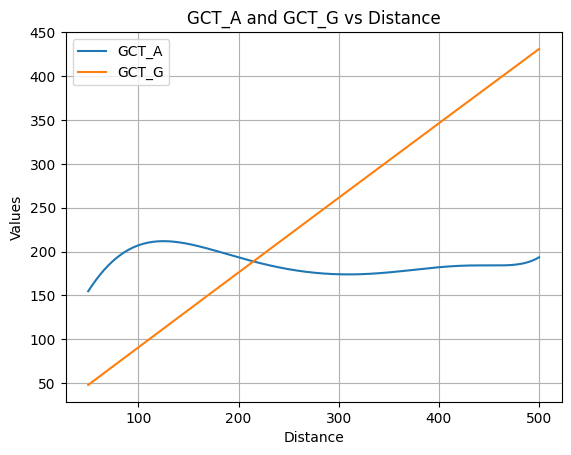

In [17]:
# Step 4: Visualize the DataFrame
new_df.plot(x='Distance', y=['GCT_A', 'GCT_G'], kind='line')
plt.title('GCT_A and GCT_G vs Distance')
plt.xlabel('Distance')
plt.ylabel('Values')
plt.legend(['GCT_A', 'GCT_G'])
plt.grid(True)
plt.show()

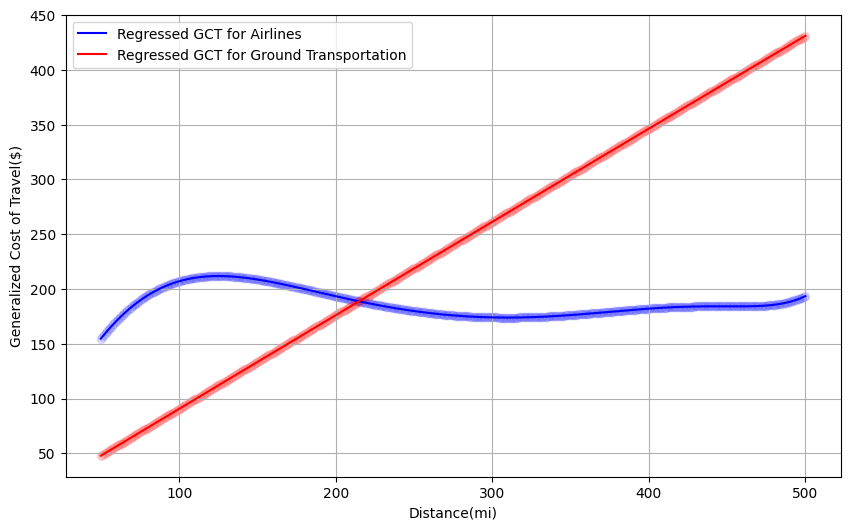

In [18]:
# Step 4: Visualize the DataFrame with Line and Scatter Plot
plt.figure(figsize=(10, 6))

# Line plot for GCT_A and GCT_G
plt.plot(new_df['Distance'], new_df['GCT_A'], label='Regressed GCT for Airlines', color='blue', linestyle='-')
plt.plot(new_df['Distance'], new_df['GCT_G'], label='Regressed GCT for Ground Transportation', color='red', linestyle='-')

# Scatter plot for GCT_A and GCT_G
plt.scatter(new_df['Distance'], new_df['GCT_A'], color='blue', alpha=0.1)
plt.scatter(new_df['Distance'], new_df['GCT_G'], color='red', alpha=0.1)

# plt.title('GCT_A and GCT_G vs Distance')
plt.xlabel('Distance(mi)')
plt.ylabel('Generalized Cost of Travel($)')
plt.legend()
plt.grid(True)
plt.show()

# Finding GCT ground and airlines between the MSAs

In [19]:
df=pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/FinalDistanceAndTimeRTN.csv")
df

Origin Destination  Distance_H Distance             Time
0    16860       17420   40.387499  53.1 mi     1 hour 1 min
1    16860       27180  204.203970   260 mi  3 hours 58 mins
2    16860       27740  189.655384   225 mi  3 hours 31 mins
3    16860       28700  195.743709   223 mi  3 hours 29 mins
4    16860       28940   93.080011   115 mi   1 hour 47 mins
..     ...         ...         ...      ...              ...
267   RTN3         MEM  113.814439   136 mi   2 hours 3 mins
268   RTN3         CHA  176.715823   223 mi  3 hours 23 mins
269   RTN3         TRI  325.926717   367 mi  5 hours 24 mins
270   RTN3         TYS  235.292065   269 mi  3 hours 59 mins
271   RTN3        RTN1  180.008711   219 mi  3 hours 41 mins

[272 rows x 5 columns]

In [20]:
# Converting 'Distance' column to numeric values for comparison
df['Distance_G'] = df['Distance'].str.replace(' mi', '').astype(float)

# # Values to delete
# values_to_delete = ['BNA', 'MEM', 'CHA', 'TYS', 'TRI']

# # Deleting rows where 'origin' or 'destination' is in the list of values_to_delete
# df_OD_pairs = df[~df['Origin'].isin(values_to_delete) & ~df['Destination'].isin(values_to_delete)]

df_OD_pairs=df.copy()

# # Display the filtered DataFrame
df_OD_pairs

Origin Destination  Distance_H Distance             Time  Distance_G
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1
1    16860       27180  204.203970   260 mi  3 hours 58 mins       260.0
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0
..     ...         ...         ...      ...              ...         ...
267   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0
268   RTN3         CHA  176.715823   223 mi  3 hours 23 mins       223.0
269   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0
270   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0
271   RTN3        RTN1  180.008711   219 mi  3 hours 41 mins       219.0

[272 rows x 6 columns]

In [21]:
# Load coefficients from the file
with open('/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Regression/polynomial_cost_coefficients.pkl', 'rb') as file:
    loaded_coefficients = pickle.load(file)



distances = df_OD_pairs['Distance_H'].values  # Read the distance values from the 'distance' column

# Assuming 'loaded_coefficients' contains the polynomial coefficients for prediction
predicted_cost = np.polyval(loaded_coefficients, distances)

df_OD_pairs=df_OD_pairs.copy()

# Add the predicted cost column to the original DataFrame
df_OD_pairs.loc[:, 'Cost_Airlines'] = predicted_cost * df_OD_pairs['Distance_H']

df_OD_pairs

Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   260 mi  3 hours 58 mins       260.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
267   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
268   RTN3         CHA  176.715823   223 mi  3 hours 23 mins       223.0   
269   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
270   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
271   RTN3        RTN1  180.008711   219 mi  3 hours 41 mins       219.0   

     Cost_Airlines  
0       128.148189  
1       171.626150  
2       176.735000  
3       174.570284  
4       189.552107  
..             ...  
267     194.498798  
268     181.352337  
269     151.687790  
270     162.116729  
271     180.184376  

[272 rows x 7 columns]

In [22]:
# Load coefficients from the file
with open('/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Regression/polynomial_blockTime_coefficients.pkl', 'rb') as file:
    loaded_coefficients = pickle.load(file)



distances = df_OD_pairs['Distance_H'].values  # Read the distance values from the 'distance' column

# Assuming 'loaded_coefficients' contains the polynomial coefficients for prediction
predicted_blockTime = np.polyval(loaded_coefficients, distances)

df_OD_pairs=df_OD_pairs.copy()

# Add the predicted cost column to the original DataFrame
df_OD_pairs.loc[:, 'Time_Airlines'] = predicted_blockTime

df_OD_pairs

Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   260 mi  3 hours 58 mins       260.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
267   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
268   RTN3         CHA  176.715823   223 mi  3 hours 23 mins       223.0   
269   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
270   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
271   RTN3        RTN1  180.008711   219 mi  3 hours 41 mins       219.0   

     Cost_Airlines  Time_Airlines  
0       128.148189       0.427514  
1       171.626150       1.094275  
2       176.735000       1.074419  
3       174.570284       1.082994  
4       189.552107       0.759036  
..             ...            ...  
267     194.498798       0.883126  
268     181.352337       1.054867  
269     151.687790       1.213533  
270     162.116729       1.128098  
271     180.184376       1.060031  

[272 rows x 8 columns]

In [23]:
# Function to convert time string to total minutes
def time_to_minutes(time_str):
    parts = time_str.split()
    hours = 0
    minutes = 0
    for i in range(0, len(parts), 2):
        if 'hour' in parts[i+1]:
            hours = int(parts[i])
        elif 'min' in parts[i+1]:
            minutes = int(parts[i])
    return hours * 60 + minutes

# Apply the function to the time column
df_OD_pairs.loc[:,'Time_Ground'] = (df_OD_pairs['Time'].apply(time_to_minutes))/60

df_OD_pairs

Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   260 mi  3 hours 58 mins       260.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
267   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
268   RTN3         CHA  176.715823   223 mi  3 hours 23 mins       223.0   
269   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
270   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
271   RTN3        RTN1  180.008711   219 mi  3 hours 41 mins       219.0   

     Cost_Airlines  Time_Airlines  Time_Ground  
0       128.148189       0.427514     1.016667  
1       171.626150       1.094275     3.966667  
2       176.735000       1.074419     3.516667  
3       174.570284       1.082994     3.483333  
4       189.552107       0.759036     1.783333  
..             ...            ...          ...  
267     194.498798       0.883126     2.050000  
268     181.352337       1.054867     3.383333  
269     151.687790       1.213533     5.400000  
270     162.116729       1.128098     3.983333  
271     180.184376       1.060031     3.683333  

[272 rows x 9 columns]

In [24]:
df_OD_pairs.loc[:,'GCT_G'] = (df_OD_pairs['Distance_G'] * Business_mean)/100  + TN_Wages_Median * df_OD_pairs['Time_Ground'] + df_OD_pairs['Distance_G'] * mean_VSL * mean_fatal_accident_rate_ground # Wages are not from MSAs, can be improved.
df_OD_pairs

Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   260 mi  3 hours 58 mins       260.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
267   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
268   RTN3         CHA  176.715823   223 mi  3 hours 23 mins       223.0   
269   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
270   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
271   RTN3        RTN1  180.008711   219 mi  3 hours 41 mins       219.0   

     Cost_Airlines  Time_Airlines  Time_Ground       GCT_G  
0       128.148189       0.427514     1.016667   49.906844  
1       171.626150       1.094275     3.966667  225.487884  
2       176.735000       1.074419     3.516667  196.701127  
3       174.570284       1.082994     3.483333  194.913960  
4       189.552107       0.759036     1.783333  100.273439  
..             ...            ...          ...         ...  
267     194.498798       0.883126     2.050000  117.483276  
268     181.352337       1.054867     3.383333  193.047460  
269     151.687790       1.213533     5.400000  314.568571  
270     162.116729       1.128098     3.983333  231.041469  
271     180.184376       1.060031     3.683333  196.316959  

[272 rows x 10 columns]

In [25]:
df_OD_pairs.loc[:,'GCT_A'] = df_OD_pairs['Cost_Airlines']  + TN_Wages_Median * df_OD_pairs['Time_Airlines'] + df_OD_pairs['Distance_H'] * mean_VSL * mean_fatal_accident_rate_air  # Wages are not from MSAs, can be improved.
df_total=df_OD_pairs.copy()
df_OD_pairs

Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   260 mi  3 hours 58 mins       260.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
267   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
268   RTN3         CHA  176.715823   223 mi  3 hours 23 mins       223.0   
269   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
270   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
271   RTN3        RTN1  180.008711   219 mi  3 hours 41 mins       219.0   

     Cost_Airlines  Time_Airlines  Time_Ground       GCT_G       GCT_A  
0       128.148189       0.427514     1.016667   49.906844  136.127740  
1       171.626150       1.094275     3.966667  225.487884  192.050801  
2       176.735000       1.074419     3.516667  196.701127  196.789023  
3       174.570284       1.082994     3.483333  194.913960  194.784362  
4       189.552107       0.759036     1.783333  100.273439  203.719521  
..             ...            ...          ...         ...         ...  
267     194.498798       0.883126     2.050000  117.483276  210.982344  
268     181.352337       1.054867     3.383333  193.047460  201.041436  
269     151.687790       1.213533     5.400000  314.568571  174.338379  
270     162.116729       1.128098     3.983333  231.041469  183.172683  
271     180.184376       1.060031     3.683333  196.316959  199.969850  

[272 rows x 11 columns]

# Finally GCT-RAM between MSAs

For using RAM from one MSA to another, we need to find the nearest airport to the origin MSA and then the nearest airport to the destination MSA

In [26]:
# List of relevant locations
locations = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA']

# Extracting unique origin-destination pairs where either Origin or Destination is in locations but not both
unique_pairs = df[((df['Origin'].isin(locations)) & (~df['Destination'].isin(locations))) |
                  ((~df['Origin'].isin(locations)) & (df['Destination'].isin(locations)))]

# Finding the nearest airport from each unique origin not including the airports in the origin
nearest_Airport = unique_pairs.loc[unique_pairs.groupby('Origin')['Distance_G'].idxmin()]
nearest_Airport = nearest_Airport[~nearest_Airport['Origin'].isin(locations)] # Remove rows where Origin is in the list of relevant locations

# Display the resulting DataFrame
nearest_Airport=nearest_Airport[['Origin','Destination']]

# Rename columns in one line
nearest_Airport.rename(columns={'Origin': 'Origin', 'Destination': 'Nearest_Airport_Origin'}, inplace=True)

nearest_Airport

Origin Nearest_Airport_Origin
11   16860                    CHA
153  17300                    BNA
27   17420                    CHA
42   27180                    MEM
60   27740                    TRI
76   28700                    TRI
93   28940                    TYS
106  32820                    MEM
125  34100                    TYS
137  34980                    BNA
252   RTN1                    CHA
266   RTN3                    BNA

In [27]:
locations = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA']
other_locations = ['16860', '17300', '17420', '27180', '27740', '28700', '28940', '32820', '34100', '34980', 'RTN1', 'RTN3']

# Ensure df has necessary columns
assert 'Origin' in df.columns and 'Destination' in df.columns and 'Distance' in df.columns

# Extract relevant origin-destination pairs
relevant_pairs = df[(df['Origin'].isin(locations) & df['Destination'].isin(other_locations)) |
                    (df['Destination'].isin(locations) & df['Origin'].isin(other_locations))]

# Create a DataFrame to store the shortest distances
shortest_distances = pd.DataFrame(columns=['Origin', 'Destination', 'Distance'])

# Iterate through each location to find the shortest distances to other locations
for loc in locations:
    # Extract pairs where loc is the origin and destination is in other_locations
    temp_df = relevant_pairs[(relevant_pairs['Origin'] == loc) & (relevant_pairs['Destination'].isin(other_locations))]
    shortest_distances = pd.concat([shortest_distances, temp_df])

# Reset index for clarity
shortest_distances.reset_index(drop=True, inplace=True)

# Find the shortest distance for each unique destination
nearest_MSA = shortest_distances.loc[shortest_distances.groupby('Destination')['Distance_G'].idxmin()]

# Reset index for clarity
nearest_MSA.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
nearest_MSA=nearest_MSA[['Origin','Destination']]

# Rename columns in one line
nearest_MSA.rename(columns={'Origin': 'Nearest_Airport_Destination', 'Destination': 'Destination'}, inplace=True)


nearest_MSA

Nearest_Airport_Destination Destination
0                          CHA       16860
1                          BNA       17300
2                          CHA       17420
3                          MEM       27180
4                          TRI       27740
5                          TRI       28700
6                          TYS       28940
7                          MEM       32820
8                          TYS       34100
9                          BNA       34980
10                         CHA        RTN1
11                         BNA        RTN3

In [28]:
df_OD_pairs

Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   260 mi  3 hours 58 mins       260.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
267   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
268   RTN3         CHA  176.715823   223 mi  3 hours 23 mins       223.0   
269   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
270   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
271   RTN3        RTN1  180.008711   219 mi  3 hours 41 mins       219.0   

     Cost_Airlines  Time_Airlines  Time_Ground       GCT_G       GCT_A  
0       128.148189       0.427514     1.016667   49.906844  136.127740  
1       171.626150       1.094275     3.966667  225.487884  192.050801  
2       176.735000       1.074419     3.516667  196.701127  196.789023  
3       174.570284       1.082994     3.483333  194.913960  194.784362  
4       189.552107       0.759036     1.783333  100.273439  203.719521  
..             ...            ...          ...         ...         ...  
267     194.498798       0.883126     2.050000  117.483276  210.982344  
268     181.352337       1.054867     3.383333  193.047460  201.041436  
269     151.687790       1.213533     5.400000  314.568571  174.338379  
270     162.116729       1.128098     3.983333  231.041469  183.172683  
271     180.184376       1.060031     3.683333  196.316959  199.969850  

[272 rows x 11 columns]

In [29]:
# Values to delete
values_to_delete = ['BNA', 'MEM', 'CHA', 'TYS', 'TRI']

# Deleting rows where 'origin' or 'destination' is in the list of values_to_delete to find the pairs of MSAs as OD
df_OD_pairs = df_OD_pairs[~df_OD_pairs['Origin'].isin(values_to_delete) & ~df_OD_pairs['Destination'].isin(values_to_delete)]
df_OD_pairs=df_OD_pairs[['Origin', 'Destination','Distance_H', 'Distance_G', 'Cost_Airlines', 'Time_Airlines', 'Time_Ground', 'GCT_G', 'GCT_A']]
df_OD_pairs

Origin Destination  Distance_H  Distance_G  Cost_Airlines  Time_Airlines  \
0    16860       17420   40.387499        53.1     128.148189       0.427514   
1    16860       27180  204.203970       260.0     171.626150       1.094275   
2    16860       27740  189.655384       225.0     176.735000       1.074419   
3    16860       28700  195.743709       223.0     174.570284       1.082994   
4    16860       28940   93.080011       115.0     189.552107       0.759036   
..     ...         ...         ...         ...            ...            ...   
262   RTN3       32820  109.274109       132.0     194.028922       0.859916   
263   RTN3       34100  267.740888       302.0     155.394580       1.149710   
264   RTN3       34980   89.055855       101.0     187.649591       0.729744   
265   RTN3       17300   68.490384       103.0     171.747642       0.564921   
271   RTN3        RTN1  180.008711       219.0     180.184376       1.060031   

     Time_Ground       GCT_G       GCT_A  
0       1.016667   49.906844  136.127740  
1       3.966667  225.487884  192.050801  
2       3.516667  196.701127  196.789023  
3       3.483333  194.913960  194.784362  
4       1.783333  100.273439  203.719521  
..           ...         ...         ...  
262     2.050000  115.153276  210.079251  
263     4.633333  262.396225  176.853913  
264     1.600000   88.696520  201.270266  
265     2.016667   97.638603  182.291901  
271     3.683333  196.316959  199.969850  

[132 rows x 9 columns]

In [30]:
# Merge the dataframes on the 'Origin' column
merged_df = df_OD_pairs.merge(nearest_Airport, on='Origin', how='left')

# Merge the result with nearest_MSA on the 'Destination' column
merged_df = merged_df.merge(nearest_MSA, on='Destination', how='left')

# Display the resulting dataframe
merged_df

Origin Destination  Distance_H  Distance_G  Cost_Airlines  Time_Airlines  \
0    16860       17420   40.387499        53.1     128.148189       0.427514   
1    16860       27180  204.203970       260.0     171.626150       1.094275   
2    16860       27740  189.655384       225.0     176.735000       1.074419   
3    16860       28700  195.743709       223.0     174.570284       1.082994   
4    16860       28940   93.080011       115.0     189.552107       0.759036   
..     ...         ...         ...         ...            ...            ...   
127   RTN3       32820  109.274109       132.0     194.028922       0.859916   
128   RTN3       34100  267.740888       302.0     155.394580       1.149710   
129   RTN3       34980   89.055855       101.0     187.649591       0.729744   
130   RTN3       17300   68.490384       103.0     171.747642       0.564921   
131   RTN3        RTN1  180.008711       219.0     180.184376       1.060031   

     Time_Ground       GCT_G       GCT_A Nearest_Airport_Origin  \
0       1.016667   49.906844  136.127740                    CHA   
1       3.966667  225.487884  192.050801                    CHA   
2       3.516667  196.701127  196.789023                    CHA   
3       3.483333  194.913960  194.784362                    CHA   
4       1.783333  100.273439  203.719521                    CHA   
..           ...         ...         ...                    ...   
127     2.050000  115.153276  210.079251                    BNA   
128     4.633333  262.396225  176.853913                    BNA   
129     1.600000   88.696520  201.270266                    BNA   
130     2.016667   97.638603  182.291901                    BNA   
131     3.683333  196.316959  199.969850                    BNA   

    Nearest_Airport_Destination  
0                           CHA  
1                           MEM  
2                           TRI  
3                           TRI  
4                           TYS  
..                          ...  
127                         MEM  
128                         TYS  
129                         BNA  
130                         BNA  
131                         CHA  

[132 rows x 11 columns]

In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Origin                       132 non-null    object 
 1   Destination                  132 non-null    object 
 2   Distance_H                   132 non-null    float64
 3   Distance_G                   132 non-null    float64
 4   Cost_Airlines                132 non-null    float64
 5   Time_Airlines                132 non-null    float64
 6   Time_Ground                  132 non-null    float64
 7   GCT_G                        132 non-null    float64
 8   GCT_A                        132 non-null    float64
 9   Nearest_Airport_Origin       132 non-null    object 
 10  Nearest_Airport_Destination  132 non-null    object 
dtypes: float64(7), object(4)
memory usage: 11.5+ KB


In [32]:
# List of airports
airports = ['BNA', 'MEM', 'CHA', 'TYS', 'TRI']

# Function to find the cost
def find_cost(origin, destination, df_total):
    row = df_total[(df_total['Origin'] == origin) & (df_total['Destination'] == destination)]
    if not row.empty:
        if origin in airports and destination in airports:
            # Both origin and destination are airports, choose GCT_A
            # print("airports")
            return row['GCT_A'].values[0]
        else:
            # Otherwise, choose GCT_G
            return row['GCT_G'].values[0]
    return 0

# Define the function to calculate the total trip cost
def calculate_total_trip_cost(row, df_total):
    cost1 = find_cost(row['Origin'], row['Nearest_Airport_Origin'], df_total)
    cost2 = find_cost(row['Nearest_Airport_Origin'], row['Nearest_Airport_Destination'], df_total)
    cost3 = find_cost(row['Nearest_Airport_Destination'], row['Destination'], df_total)
    return cost2, cost1 + cost3, cost1 + cost2 + cost3

# Apply the function to the dataframe and assign the results to new columns
merged_df[['Cost_RAM_A', 'Cost_RAM_G', 'Total_Trip_Cost']] = merged_df.apply(
    lambda row: calculate_total_trip_cost(row, df_total=df_total), axis=1, result_type='expand'
)

# Calculate the percentage of Cost_RAM_A in the Total_Trip_Cost and assign it to a new column
merged_df['Percentage'] = (merged_df['Cost_RAM_A'] / merged_df['Total_Trip_Cost'])

merged_df

Origin Destination  Distance_H  Distance_G  Cost_Airlines  Time_Airlines  \
0    16860       17420   40.387499        53.1     128.148189       0.427514   
1    16860       27180  204.203970       260.0     171.626150       1.094275   
2    16860       27740  189.655384       225.0     176.735000       1.074419   
3    16860       28700  195.743709       223.0     174.570284       1.082994   
4    16860       28940   93.080011       115.0     189.552107       0.759036   
..     ...         ...         ...         ...            ...            ...   
127   RTN3       32820  109.274109       132.0     194.028922       0.859916   
128   RTN3       34100  267.740888       302.0     155.394580       1.149710   
129   RTN3       34980   89.055855       101.0     187.649591       0.729744   
130   RTN3       17300   68.490384       103.0     171.747642       0.564921   
131   RTN3        RTN1  180.008711       219.0     180.184376       1.060031   

     Time_Ground       GCT_G       GCT_A Nearest_Airport_Origin  \
0       1.016667   49.906844  136.127740                    CHA   
1       3.966667  225.487884  192.050801                    CHA   
2       3.516667  196.701127  196.789023                    CHA   
3       3.483333  194.913960  194.784362                    CHA   
4       1.783333  100.273439  203.719521                    CHA   
..           ...         ...         ...                    ...   
127     2.050000  115.153276  210.079251                    BNA   
128     4.633333  262.396225  176.853913                    BNA   
129     1.600000   88.696520  201.270266                    BNA   
130     2.016667   97.638603  182.291901                    BNA   
131     3.683333  196.316959  199.969850                    BNA   

    Nearest_Airport_Destination  Cost_RAM_A  Cost_RAM_G  Total_Trip_Cost  \
0                           CHA    0.000000   55.873178        55.873178   
1                           MEM  176.544192   97.558021       274.102213   
2                           TRI  198.098821   39.887840       237.986661   
3                           TRI  198.098821   34.233839       232.332660   
4                           TYS  199.723451   38.699258       238.422708   
..                          ...         ...         ...              ...   
127                         MEM  193.445794   96.604937       290.050731   
128                         TYS  208.295710  131.843862       340.139572   
129                         BNA    0.000000   90.212270        90.212270   
130                         BNA    0.000000  154.703951       154.703951   
131                         CHA  210.649805  161.142533       371.792339   

     Percentage  
0      0.000000  
1      0.644082  
2      0.832395  
3      0.852652  
4      0.837686  
..          ...  
127    0.666938  
128    0.612383  
129    0.000000  
130    0.000000  
131    0.566579  

[132 rows x 15 columns]

In [33]:
df=merged_df[['Origin','Destination','Distance_G', 'GCT_G','GCT_A','Total_Trip_Cost','Percentage']].copy()
# Rename columns in one line
df.rename(columns={'Total_Trip_Cost': 'GCT_RAM'}, inplace=True)
df

Origin Destination  Distance_G       GCT_G       GCT_A     GCT_RAM  \
0    16860       17420        53.1   49.906844  136.127740   55.873178   
1    16860       27180       260.0  225.487884  192.050801  274.102213   
2    16860       27740       225.0  196.701127  196.789023  237.986661   
3    16860       28700       223.0  194.913960  194.784362  232.332660   
4    16860       28940       115.0  100.273439  203.719521  238.422708   
..     ...         ...         ...         ...         ...         ...   
127   RTN3       32820       132.0  115.153276  210.079251  290.050731   
128   RTN3       34100       302.0  262.396225  176.853913  340.139572   
129   RTN3       34980       101.0   88.696520  201.270266   90.212270   
130   RTN3       17300       103.0   97.638603  182.291901  154.703951   
131   RTN3        RTN1       219.0  196.316959  199.969850  371.792339   

     Percentage  
0      0.000000  
1      0.644082  
2      0.832395  
3      0.852652  
4      0.837686  
..          ...  
127    0.666938  
128    0.612383  
129    0.000000  
130    0.000000  
131    0.566579  

[132 rows x 7 columns]

# Visualization

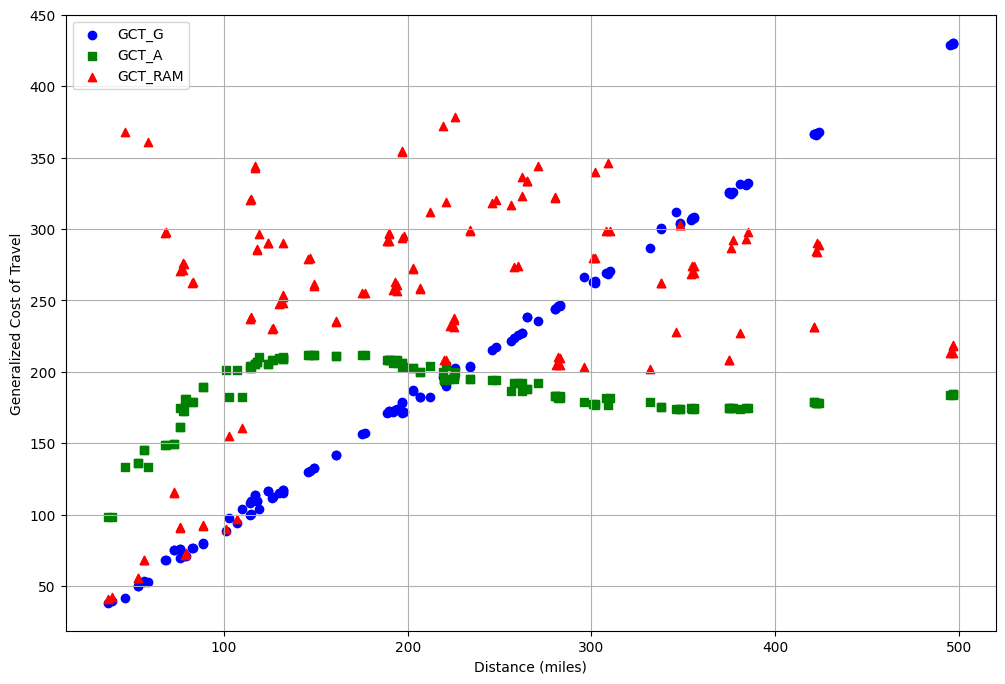

In [34]:
# Plot settings
plt.figure(figsize=(12, 8))

# Scatter plot for GCT_G
plt.scatter(df['Distance_G'], df['GCT_G'], label='GCT_G', color='blue', marker='o')
# Scatter plot for GCT_A
plt.scatter(df['Distance_G'], df['GCT_A'], label='GCT_A', color='green', marker='s')
# Scatter plot for GCT_RAM
plt.scatter(df['Distance_G'], df['GCT_RAM'], label='GCT_RAM', color='red', marker='^')

# # Annotate some outliers
# outliers = df[ (df['GCT_RAM'] > 350)]
# for i, row in outliers.iterrows():
#     plt.annotate(f"{row['Origin']}-{row['Destination']}",
#                  (row['Distance_G'], row['GCT_RAM']),
#                  textcoords="offset points", xytext=(0,10), ha='center')

# Titles and labels
# plt.title('GCT vs Distance for Ground, Air, and RAM')
plt.xlabel('Distance (miles)')
plt.ylabel('Generalized Cost of Travel')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [35]:
df_new=df[ (df['GCT_RAM'] < df['GCT_G'])]
df_new

Origin Destination  Distance_G       GCT_G       GCT_A     GCT_RAM  \
5    16860       32820       296.0  266.367224  178.891243  203.085280   
16   17420       32820       346.0  311.668567  174.278024  227.794535   
24   27180       27740       423.0  367.408999  178.266376  289.975401   
25   27180       28700       422.0  365.893248  177.811086  284.321400   
28   27180       34100       348.0  304.123234  173.947578  303.054885   
35   27740       27180       424.0  367.991499  178.266376  288.750901   
38   27740       32820       497.0  430.423346  184.117663  217.733968   
40   27740       34980       283.0  246.662471  181.904613  209.433871   
41   27740       17300       356.0  308.472152  174.259626  273.925552   
43   27740        RTN3       385.0  332.519575  174.489721  297.739974   
46   28700       27180       423.0  366.475749  177.811086  284.146650   
49   28700       32820       497.0  429.179013  184.084831  213.129717   
51   28700       34980       283.0  245.729221  182.925455  204.829620   
52   28700       17300       356.0  307.538902  174.740794  269.321301   
54   28700        RTN3       384.0  331.003824  174.305095  293.135724   
60   28940       32820       375.0  325.450239  174.333524  208.549448   
66   32820       16860       332.0  287.026148  178.891243  201.860780   
67   32820       17420       381.0  331.433907  174.278024  226.822869   
69   32820       27740       497.0  430.423346  184.117663  218.472635   
70   32820       28700       495.0  428.636179  184.084831  212.818634   
71   32820       28940       375.0  325.761323  174.333524  208.471364   
72   32820       34100       421.0  366.555081  178.648051  231.552119   
75   32820        RTN1       338.0  300.475815  175.364401  262.028375   
79   34100       27180       348.0  303.812151  173.947578  302.627302   
83   34100       32820       421.0  366.243998  178.648051  231.610369   
91   34980       27740       282.0  246.079971  181.904613  210.483621   
92   34980       28700       281.0  244.564221  182.925455  204.829620   
102  17300       27740       355.0  307.889652  174.259626  274.061885   
103  17300       28700       354.0  306.373902  174.740794  268.407885   
116   RTN1       32820       338.0  300.164732  175.364401  262.514208   
124   RTN3       27740       377.0  325.681990  174.489721  292.223556   
125   RTN3       28700       376.0  324.477323  174.305095  286.569555   

     Percentage  
5      0.869311  
16     0.775015  
24     0.635155  
25     0.647786  
28     0.578663  
35     0.637848  
38     0.845891  
40     0.870307  
41     0.665407  
43     0.612185  
46     0.648184  
49     0.864165  
51     0.889871  
52     0.676782  
54     0.621800  
60     0.840887  
66     0.874584  
67     0.778335  
69     0.843031  
70     0.865428  
71     0.841202  
72     0.757353  
75     0.673760  
79     0.579480  
83     0.757162  
91     0.865967  
92     0.889871  
102    0.665076  
103    0.679085  
116    0.672513  
124    0.623741  
125    0.636048

In [36]:
df_new['Percentage'].min()

np.float64(0.5786628652681917)

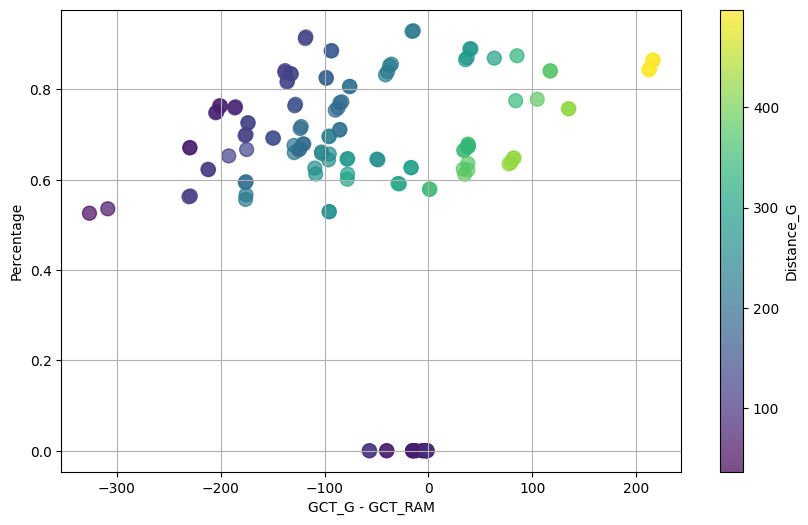

In [37]:

# Calculate GCT_G - GCT_RAM
df['GCT_Difference'] = df['GCT_G'] - df['GCT_RAM']


# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['GCT_Difference'], df['Percentage'], c=df['Distance_G'], cmap='viridis', s=100, alpha=0.7)
plt.xlabel('GCT_G - GCT_RAM')
plt.ylabel('Percentage')
# plt.title('Plot of GCT_G - GCT_RAM against Percentage with Distance_G')
plt.colorbar(scatter, label='Distance_G')
plt.grid(True)
plt.show()

# Percentage above around 80 and distance above around 250 miles in case of Tennessee state

In [38]:
df_new = df.copy()
from sklearn.preprocessing import MinMaxScaler

# # Standardizing the values
# scaler = StandardScaler()
# df_new.loc[:, ['GCT_G', 'GCT_RAM']] = scaler.fit_transform(df_new[['GCT_G', 'GCT_RAM']])

scaler = MinMaxScaler()
df_new[['GCT_G', 'GCT_RAM']] = scaler.fit_transform(df_new[['GCT_G', 'GCT_RAM']])

# Calculate the P_RAM column
df_new['P_RAM'] = 1 / (1 + np.exp(df_new['GCT_RAM'] - df_new['GCT_G'])) # due to negative sign we swap the place

# Display the updated dataframe
df_new.head()

Origin Destination  Distance_G     GCT_G       GCT_A   GCT_RAM  Percentage  \
0  16860       17420        53.1  0.029618  136.127740  0.043363    0.000000   
1  16860       27180       260.0  0.477380  192.050801  0.690378    0.644082   
2  16860       27740       225.0  0.403968  196.789023  0.583301    0.832395   
3  16860       28700       223.0  0.399411  194.784362  0.566538    0.852652   
4  16860       28940       115.0  0.158061  203.719521  0.584594    0.837686   

   GCT_Difference     P_RAM  
0       -5.966334  0.496564  
1      -48.614329  0.446951  
2      -41.285534  0.455287  
3      -37.418700  0.458315  
4     -138.149269  0.394955

In [39]:
# Calculate the P_RAM column
df_new['P_G'] = 1 / (1 + np.exp(df_new['GCT_G'] - df_new['GCT_RAM']))
df_new.head()

Origin Destination  Distance_G     GCT_G       GCT_A   GCT_RAM  Percentage  \
0  16860       17420        53.1  0.029618  136.127740  0.043363    0.000000   
1  16860       27180       260.0  0.477380  192.050801  0.690378    0.644082   
2  16860       27740       225.0  0.403968  196.789023  0.583301    0.832395   
3  16860       28700       223.0  0.399411  194.784362  0.566538    0.852652   
4  16860       28940       115.0  0.158061  203.719521  0.584594    0.837686   

   GCT_Difference     P_RAM       P_G  
0       -5.966334  0.496564  0.503436  
1      -48.614329  0.446951  0.553049  
2      -41.285534  0.455287  0.544713  
3      -37.418700  0.458315  0.541685  
4     -138.149269  0.394955  0.605045

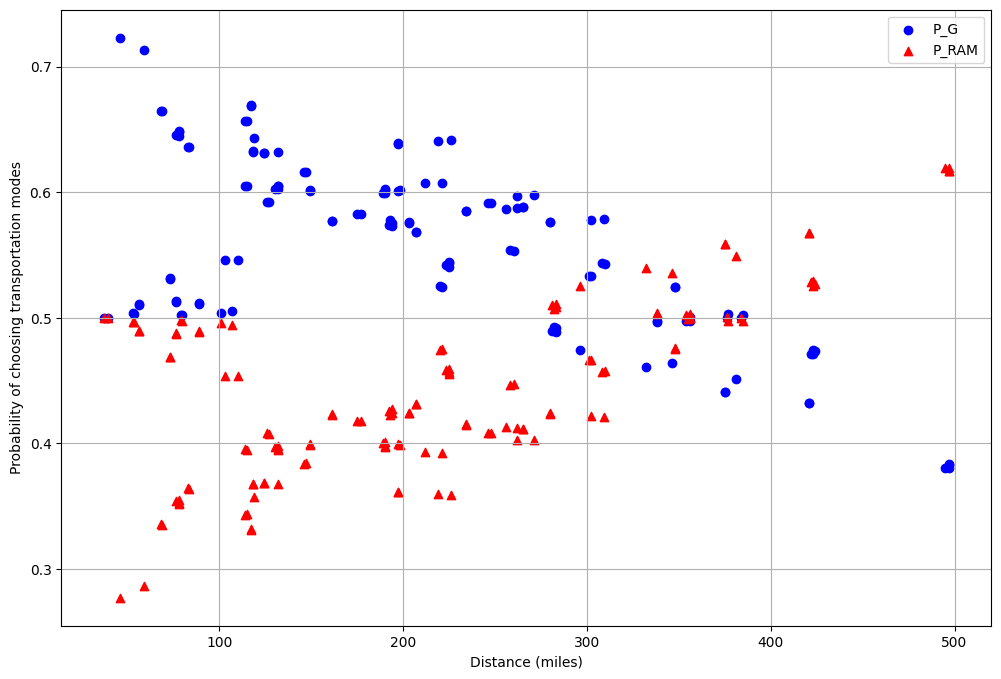

In [40]:
# Plot settings
plt.figure(figsize=(12, 8))

# Scatter plot for GCT_G
plt.scatter(df_new['Distance_G'], df_new['P_G'], label='P_G', color='blue', marker='o')
# Scatter plot for GCT_RAM
plt.scatter(df_new['Distance_G'], df_new['P_RAM'], label='P_RAM', color='red', marker='^')

# # Annotate some outliers
# outliers = df[ (df_new['GCT_RAM'] > 350)]
# for i, row in outliers.iterrows():
#     plt.annotate(f"{row['Origin']}-{row['Destination']}",
#                  (row['Distance_G'], row['GCT_RAM']),
#                  textcoords="offset points", xytext=(0,10), ha='center')

# Titles and labels
# plt.title('GCT vs Distance for Ground, Air, and RAM')
plt.xlabel('Distance (miles)')
plt.ylabel('Probability of choosing transportation modes')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

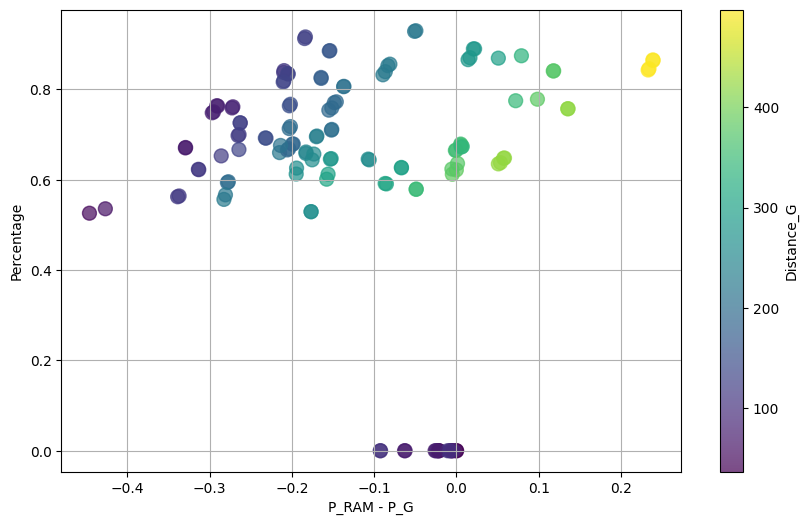

In [41]:
# Calculate GCT_G - GCT_RAM
df_new['P_Difference'] = df_new['P_RAM'] - df_new['P_G']


# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_new['P_Difference'], df_new['Percentage'], c=df_new['Distance_G'], cmap='viridis', s=100, alpha=0.7)
plt.xlabel('P_RAM - P_G')
plt.ylabel('Percentage')
# plt.title('Plot of GCT_G - GCT_RAM against Percentage with Distance_G')
plt.colorbar(scatter, label='Distance_G')
plt.grid(True)
plt.show()

# Percentage above around 80 and distance above around 250 miles in case of Tennessee state

# GCT_RAM with more airports

In [42]:
df=pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/FinalDistanceAndTimeRTN_more_airports.csv")
# Converting 'Distance' column to numeric values for comparison
df['Distance_G'] = df['Distance'].str.replace(' mi', '').astype(float)

In [43]:
# Load coefficients from the file
with open('/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Regression/polynomial_cost_coefficients.pkl', 'rb') as file:
    loaded_coefficients = pickle.load(file)



distances = df['Distance_H'].values  # Read the distance values from the 'distance' column

# Assuming 'loaded_coefficients' contains the polynomial coefficients for prediction
predicted_cost = np.polyval(loaded_coefficients, distances)

df=df.copy()

# Add the predicted cost column to the original DataFrame
df.loc[:, 'Cost_Airlines'] = predicted_cost * df['Distance_H']

In [44]:
# Load coefficients from the file
with open('/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Regression/polynomial_blockTime_coefficients.pkl', 'rb') as file:
    loaded_coefficients = pickle.load(file)



distances = df['Distance_H'].values  # Read the distance values from the 'distance' column

# Assuming 'loaded_coefficients' contains the polynomial coefficients for prediction
predicted_blockTime = np.polyval(loaded_coefficients, distances)

df=df.copy()

# Add the predicted cost column to the original DataFrame
df.loc[:, 'Time_Airlines'] = predicted_blockTime

In [45]:
# Function to convert time string to total minutes
def time_to_minutes(time_str):
    parts = time_str.split()
    hours = 0
    minutes = 0
    for i in range(0, len(parts), 2):
        if 'hour' in parts[i+1]:
            hours = int(parts[i])
        elif 'min' in parts[i+1]:
            minutes = int(parts[i])
    return hours * 60 + minutes

# Apply the function to the time column
df.loc[:,'Time_Ground'] = (df['Time'].apply(time_to_minutes))/60

In [46]:
df.loc[:,'GCT_G'] = (df['Distance_G'] * Business_mean)/100  + TN_Wages_Median * df['Time_Ground'] + df['Distance_G'] * mean_VSL * mean_fatal_accident_rate_ground  # Wages are not from MSAs, can be improved.

In [47]:
df.loc[:,'GCT_A'] = df['Cost_Airlines']  + TN_Wages_Median * df['Time_Airlines'] + df['Distance_H'] * mean_VSL * mean_fatal_accident_rate_air  # Wages are not from MSAs, can be improved.
df_total=df_OD_pairs.copy()
df

Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   261 mi  3 hours 57 mins       261.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
547   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
548   RTN3         MOR  270.414853   304 mi  4 hours 40 mins       304.0   
549   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
550   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
551   RTN3        RTN1  180.008711   219 mi  3 hours 39 mins       219.0   

     Cost_Airlines  Time_Airlines  Time_Ground       GCT_G       GCT_A  
0       128.148189       0.427514     1.016667   49.906844  136.127740  
1       171.626150       1.094275     3.950000  225.759301  192.050801  
2       176.735000       1.074419     3.516667  196.701127  196.789023  
3       174.570284       1.082994     3.483333  194.913960  194.784362  
4       189.552107       0.759036     1.783333  100.273439  203.719521  
..             ...            ...          ...         ...         ...  
547     194.498798       0.883126     2.050000  117.483276  210.982344  
548     155.002458       1.151163     4.666667  264.183392  176.488922  
549     151.687790       1.213533     5.400000  314.568571  174.338379  
550     162.116729       1.128098     3.983333  231.041469  183.172683  
551     180.184376       1.060031     3.650000  195.694792  199.969850  

[552 rows x 11 columns]

In [48]:
# List of relevant locations
locations = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA', '0A9', '0M1', 'CKV', 'CSV', 'HDI', 'M53','MOR']

# Extracting unique origin-destination pairs where either Origin or Destination is in locations but not both
unique_pairs = df[((df['Origin'].isin(locations)) & (~df['Destination'].isin(locations))) |
                  ((~df['Origin'].isin(locations)) & (df['Destination'].isin(locations)))]

# Finding the nearest airport from each unique origin not including the airports in the origin
nearest_Airport = unique_pairs.loc[unique_pairs.groupby('Origin')['Distance_G'].idxmin()]
nearest_Airport = nearest_Airport[~nearest_Airport['Origin'].isin(locations)] # Remove rows where Origin is in the list of relevant locations

# Display the resulting DataFrame
nearest_Airport=nearest_Airport[['Origin','Destination']]

# Rename columns in one line
nearest_Airport.rename(columns={'Origin': 'Origin', 'Destination': 'Nearest_Airport_Origin'}, inplace=True)

nearest_Airport

Origin Nearest_Airport_Origin
12   16860                    CHA
220  17300                    CKV
38   17420                    HDI
62   27180                    M53
78   27740                    0A9
111  28700                    TRI
135  28940                    TYS
155  32820                    MEM
179  34100                    MOR
195  34980                    BNA
521   RTN1                    CSV
540   RTN3                    0M1

In [49]:
# List of relevant locations
locations = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA', '0A9', '0M1', 'CKV', 'CSV', 'HDI', 'M53','MOR']
other_locations = ['16860', '17300', '17420', '27180', '27740', '28700', '28940', '32820', '34100', '34980', 'RTN1', 'RTN3']

# Ensure df has necessary columns
assert 'Origin' in df.columns and 'Destination' in df.columns and 'Distance' in df.columns

# Extract relevant origin-destination pairs
relevant_pairs = df[(df['Origin'].isin(locations) & df['Destination'].isin(other_locations)) |
                    (df['Destination'].isin(locations) & df['Origin'].isin(other_locations))]

# Create a DataFrame to store the shortest distances
shortest_distances = pd.DataFrame(columns=['Origin', 'Destination', 'Distance'])

# Iterate through each location to find the shortest distances to other locations
for loc in locations:
    # Extract pairs where loc is the origin and destination is in other_locations
    temp_df = relevant_pairs[(relevant_pairs['Origin'] == loc) & (relevant_pairs['Destination'].isin(other_locations))]
    shortest_distances = pd.concat([shortest_distances, temp_df])

# Reset index for clarity
shortest_distances.reset_index(drop=True, inplace=True)

# Find the shortest distance for each unique destination
nearest_MSA = shortest_distances.loc[shortest_distances.groupby('Destination')['Distance_G'].idxmin()]

# Reset index for clarity
nearest_MSA.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
nearest_MSA=nearest_MSA[['Origin','Destination']]

# Rename columns in one line
nearest_MSA.rename(columns={'Origin': 'Nearest_Airport_Destination', 'Destination': 'Destination'}, inplace=True)


nearest_MSA

Nearest_Airport_Destination Destination
0                          CHA       16860
1                          CKV       17300
2                          HDI       17420
3                          M53       27180
4                          0A9       27740
5                          TRI       28700
6                          TYS       28940
7                          MEM       32820
8                          MOR       34100
9                          BNA       34980
10                         CSV        RTN1
11                         0M1        RTN3

In [50]:
df

Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   261 mi  3 hours 57 mins       261.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
547   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
548   RTN3         MOR  270.414853   304 mi  4 hours 40 mins       304.0   
549   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
550   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
551   RTN3        RTN1  180.008711   219 mi  3 hours 39 mins       219.0   

     Cost_Airlines  Time_Airlines  Time_Ground       GCT_G       GCT_A  
0       128.148189       0.427514     1.016667   49.906844  136.127740  
1       171.626150       1.094275     3.950000  225.759301  192.050801  
2       176.735000       1.074419     3.516667  196.701127  196.789023  
3       174.570284       1.082994     3.483333  194.913960  194.784362  
4       189.552107       0.759036     1.783333  100.273439  203.719521  
..             ...            ...          ...         ...         ...  
547     194.498798       0.883126     2.050000  117.483276  210.982344  
548     155.002458       1.151163     4.666667  264.183392  176.488922  
549     151.687790       1.213533     5.400000  314.568571  174.338379  
550     162.116729       1.128098     3.983333  231.041469  183.172683  
551     180.184376       1.060031     3.650000  195.694792  199.969850  

[552 rows x 11 columns]

In [51]:
# Merge the dataframes on the 'Origin' column
merged_df = df.merge(nearest_Airport, on='Origin', how='left')

# Replace NaN values in 'Nearest_Airport' with values from 'Origin'
merged_df['Nearest_Airport_Origin'].fillna(merged_df['Origin'], inplace=True)

# Display the resulting dataframe
merged_df

/tmp/ipykernel_6550/3259639705.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Nearest_Airport_Origin'].fillna(merged_df['Origin'], inplace=True)


Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   261 mi  3 hours 57 mins       261.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
547   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
548   RTN3         MOR  270.414853   304 mi  4 hours 40 mins       304.0   
549   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
550   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
551   RTN3        RTN1  180.008711   219 mi  3 hours 39 mins       219.0   

     Cost_Airlines  Time_Airlines  Time_Ground       GCT_G       GCT_A  \
0       128.148189       0.427514     1.016667   49.906844  136.127740   
1       171.626150       1.094275     3.950000  225.759301  192.050801   
2       176.735000       1.074419     3.516667  196.701127  196.789023   
3       174.570284       1.082994     3.483333  194.913960  194.784362   
4       189.552107       0.759036     1.783333  100.273439  203.719521   
..             ...            ...          ...         ...         ...   
547     194.498798       0.883126     2.050000  117.483276  210.982344   
548     155.002458       1.151163     4.666667  264.183392  176.488922   
549     151.687790       1.213533     5.400000  314.568571  174.338379   
550     162.116729       1.128098     3.983333  231.041469  183.172683   
551     180.184376       1.060031     3.650000  195.694792  199.969850   

    Nearest_Airport_Origin  
0                      CHA  
1                      CHA  
2                      CHA  
3                      CHA  
4                      CHA  
..                     ...  
547                    0M1  
548                    0M1  
549                    0M1  
550                    0M1  
551                    0M1  

[552 rows x 12 columns]

In [52]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Origin                  552 non-null    object 
 1   Destination             552 non-null    object 
 2   Distance_H              552 non-null    float64
 3   Distance                552 non-null    object 
 4   Time                    552 non-null    object 
 5   Distance_G              552 non-null    float64
 6   Cost_Airlines           552 non-null    float64
 7   Time_Airlines           552 non-null    float64
 8   Time_Ground             552 non-null    float64
 9   GCT_G                   552 non-null    float64
 10  GCT_A                   552 non-null    float64
 11  Nearest_Airport_Origin  552 non-null    object 
dtypes: float64(7), object(5)
memory usage: 51.9+ KB


In [53]:
# Merge the result with nearest_MSA on the 'Destination' column
merged_df = merged_df.merge(nearest_MSA, on='Destination', how='left')

# Replace NaN values in 'Nearest_Airport' with values from 'Origin'
merged_df['Nearest_Airport_Destination'].fillna(merged_df['Destination'], inplace=True)

merged_df

/tmp/ipykernel_6550/3102152047.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Nearest_Airport_Destination'].fillna(merged_df['Destination'], inplace=True)


Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   261 mi  3 hours 57 mins       261.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
547   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
548   RTN3         MOR  270.414853   304 mi  4 hours 40 mins       304.0   
549   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
550   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
551   RTN3        RTN1  180.008711   219 mi  3 hours 39 mins       219.0   

     Cost_Airlines  Time_Airlines  Time_Ground       GCT_G       GCT_A  \
0       128.148189       0.427514     1.016667   49.906844  136.127740   
1       171.626150       1.094275     3.950000  225.759301  192.050801   
2       176.735000       1.074419     3.516667  196.701127  196.789023   
3       174.570284       1.082994     3.483333  194.913960  194.784362   
4       189.552107       0.759036     1.783333  100.273439  203.719521   
..             ...            ...          ...         ...         ...   
547     194.498798       0.883126     2.050000  117.483276  210.982344   
548     155.002458       1.151163     4.666667  264.183392  176.488922   
549     151.687790       1.213533     5.400000  314.568571  174.338379   
550     162.116729       1.128098     3.983333  231.041469  183.172683   
551     180.184376       1.060031     3.650000  195.694792  199.969850   

    Nearest_Airport_Origin Nearest_Airport_Destination  
0                      CHA                         HDI  
1                      CHA                         M53  
2                      CHA                         0A9  
3                      CHA                         TRI  
4                      CHA                         TYS  
..                     ...                         ...  
547                    0M1                         MEM  
548                    0M1                         MOR  
549                    0M1                         TRI  
550                    0M1                         TYS  
551                    0M1                         CSV  

[552 rows x 13 columns]

In [54]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Origin                       552 non-null    object 
 1   Destination                  552 non-null    object 
 2   Distance_H                   552 non-null    float64
 3   Distance                     552 non-null    object 
 4   Time                         552 non-null    object 
 5   Distance_G                   552 non-null    float64
 6   Cost_Airlines                552 non-null    float64
 7   Time_Airlines                552 non-null    float64
 8   Time_Ground                  552 non-null    float64
 9   GCT_G                        552 non-null    float64
 10  GCT_A                        552 non-null    float64
 11  Nearest_Airport_Origin       552 non-null    object 
 12  Nearest_Airport_Destination  552 non-null    object 
dtypes: float64(7), objec

In [55]:
# List of airports
airports = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA', '0A9', '0M1', 'CKV', 'CSV', 'HDI', 'M53','MOR']

# Function to find the cost
def find_cost(origin, destination, df_total):
    row = df_total[(df_total['Origin'] == origin) & (df_total['Destination'] == destination)]
    if not row.empty:
        if origin in airports and destination in airports:
            # Both origin and destination are airports, choose GCT_A
            # print("airports")
            return row['GCT_A'].values[0]
        else:
            # Otherwise, choose GCT_G
            return row['GCT_G'].values[0]
    return 0

# Define the function to calculate the total trip cost
def calculate_total_trip_cost(row, df_total):
    cost1 = find_cost(row['Origin'], row['Nearest_Airport_Origin'], df_total)
    cost2 = find_cost(row['Nearest_Airport_Origin'], row['Nearest_Airport_Destination'], df_total)
    cost3 = find_cost(row['Nearest_Airport_Destination'], row['Destination'], df_total)
    return cost2, cost1 + cost3, cost1 + cost2 + cost3

# Apply the function to the dataframe and assign the results to new columns
merged_df[['Cost_RAM_A', 'Cost_RAM_G', 'Total_Trip_Cost']] = merged_df.apply(
    lambda row: calculate_total_trip_cost(row, df_total=df), axis=1, result_type='expand'
)

# Calculate the percentage of Cost_RAM_A in the Total_Trip_Cost and assign it to a new column
merged_df['Percentage'] = (merged_df['Cost_RAM_A'] / merged_df['Total_Trip_Cost'])

merged_df

Origin Destination  Distance_H Distance             Time  Distance_G  \
0    16860       17420   40.387499  53.1 mi     1 hour 1 min        53.1   
1    16860       27180  204.203970   261 mi  3 hours 57 mins       261.0   
2    16860       27740  189.655384   225 mi  3 hours 31 mins       225.0   
3    16860       28700  195.743709   223 mi  3 hours 29 mins       223.0   
4    16860       28940   93.080011   115 mi   1 hour 47 mins       115.0   
..     ...         ...         ...      ...              ...         ...   
547   RTN3         MEM  113.814439   136 mi   2 hours 3 mins       136.0   
548   RTN3         MOR  270.414853   304 mi  4 hours 40 mins       304.0   
549   RTN3         TRI  325.926717   367 mi  5 hours 24 mins       367.0   
550   RTN3         TYS  235.292065   269 mi  3 hours 59 mins       269.0   
551   RTN3        RTN1  180.008711   219 mi  3 hours 39 mins       219.0   

     Cost_Airlines  Time_Airlines  Time_Ground       GCT_G       GCT_A  \
0       128.148189       0.427514     1.016667   49.906844  136.127740   
1       171.626150       1.094275     3.950000  225.759301  192.050801   
2       176.735000       1.074419     3.516667  196.701127  196.789023   
3       174.570284       1.082994     3.483333  194.913960  194.784362   
4       189.552107       0.759036     1.783333  100.273439  203.719521   
..             ...            ...          ...         ...         ...   
547     194.498798       0.883126     2.050000  117.483276  210.982344   
548     155.002458       1.151163     4.666667  264.183392  176.488922   
549     151.687790       1.213533     5.400000  314.568571  174.338379   
550     162.116729       1.128098     3.983333  231.041469  183.172683   
551     180.184376       1.060031     3.650000  195.694792  199.969850   

    Nearest_Airport_Origin Nearest_Airport_Destination  Cost_RAM_A  \
0                      CHA                         HDI   99.424521   
1                      CHA                         M53  189.201244   
2                      CHA                         0A9  195.541119   
3                      CHA                         TRI  198.098821   
4                      CHA                         TYS  199.723451   
..                     ...                         ...         ...   
547                    0M1                         MEM  210.667410   
548                    0M1                         MOR  176.737894   
549                    0M1                         TRI  174.280942   
550                    0M1                         TYS  183.931855   
551                    0M1                         CSV  202.576436   

     Cost_RAM_G  Total_Trip_Cost  Percentage  
0     37.788340       137.212861    0.724601  
1     24.946005       214.147249    0.883510  
2     34.779172       230.320291    0.848996  
3     34.544923       232.643744    0.851511  
4     38.699258       238.422708    0.837686  
..          ...              ...         ...  
547   19.815004       230.482414    0.914028  
548   19.815004       196.552898    0.899187  
549   19.815004       194.095946    0.897911  
550   19.815004       203.746859    0.902747  
551   46.183841       248.760277    0.814344  

[552 rows x 17 columns]

In [56]:
df=merged_df[['Origin','Destination','Distance_G', 'GCT_G','GCT_A','Total_Trip_Cost' ,'Percentage']].copy()
# Rename columns in one line
df.rename(columns={'Total_Trip_Cost': 'GCT_RAM'}, inplace=True)
df

Origin Destination  Distance_G       GCT_G       GCT_A     GCT_RAM  \
0    16860       17420        53.1   49.906844  136.127740  137.212861   
1    16860       27180       261.0  225.759301  192.050801  214.147249   
2    16860       27740       225.0  196.701127  196.789023  230.320291   
3    16860       28700       223.0  194.913960  194.784362  232.643744   
4    16860       28940       115.0  100.273439  203.719521  238.422708   
..     ...         ...         ...         ...         ...         ...   
547   RTN3         MEM       136.0  117.483276  210.982344  230.482414   
548   RTN3         MOR       304.0  264.183392  176.488922  196.552898   
549   RTN3         TRI       367.0  314.568571  174.338379  194.095946   
550   RTN3         TYS       269.0  231.041469  183.172683  203.746859   
551   RTN3        RTN1       219.0  195.694792  199.969850  248.760277   

     Percentage  
0      0.724601  
1      0.883510  
2      0.848996  
3      0.851511  
4      0.837686  
..          ...  
547    0.914028  
548    0.899187  
549    0.897911  
550    0.902747  
551    0.814344  

[552 rows x 7 columns]

In [57]:
# Values to delete
values_to_delete = ['BNA', 'MEM', 'TRI', 'TYS', 'CHA', '0A9', '0M1', 'CKV', 'CSV', 'HDI', 'M53','MOR']

# Deleting rows where 'origin' or 'destination' is in the list of values_to_delete to find the pairs of MSAs as OD
df = df[~df['Origin'].isin(values_to_delete) & ~df['Destination'].isin(values_to_delete)]
df

Origin Destination  Distance_G       GCT_G       GCT_A     GCT_RAM  \
0    16860       17420        53.1   49.906844  136.127740  137.212861   
1    16860       27180       261.0  225.759301  192.050801  214.147249   
2    16860       27740       225.0  196.701127  196.789023  230.320291   
3    16860       28700       223.0  194.913960  194.784362  232.643744   
4    16860       28940       115.0  100.273439  203.719521  238.422708   
..     ...         ...         ...         ...         ...         ...   
535   RTN3       32820       132.0  115.153276  210.079251  241.111249   
536   RTN3       34100       302.0  262.396225  176.853913  201.022065   
537   RTN3       34980       101.0   88.696520  201.270266  224.518310   
538   RTN3       17300       103.0   97.638603  182.291901  231.236074   
551   RTN3        RTN1       219.0  195.694792  199.969850  248.760277   

     Percentage  
0      0.724601  
1      0.883510  
2      0.848996  
3      0.851511  
4      0.837686  
..          ...  
535    0.873735  
536    0.879196  
537    0.892877  
538    0.835584  
551    0.814344  

[132 rows x 7 columns]

In [58]:
# Create a function to determine the lowest GCT value
def find_lowest_gct_between_ground_and_RAM(row):
    min_value = min(row['GCT_G'], row['GCT_RAM'])
    if row['GCT_G'] == min_value:
        return 'GCT_G'
    else:
        return 'GCT_RAM'

# Apply the function to each row
df['Lowest_GCT'] = df.apply(find_lowest_gct_between_ground_and_RAM, axis=1)

# Create a pivot table to get the lowest GCT type for each Origin-Destination pair
pivot_table = df.pivot_table(index='Origin', columns='Destination', values='Lowest_GCT', aggfunc='first')

# Map GCT types to numeric values for the heatmap
gct_mapping = {'GCT_G': 0, 'GCT_RAM': 1}
numeric_pivot_table = pivot_table.replace(gct_mapping)

# Create a custom colormap
cmap = ListedColormap(['blue', 'green'])

# # Plot the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(numeric_pivot_table, annot=pivot_table, fmt='', cmap=cmap, cbar=False, linewidths=.5, linecolor='black')
# plt.title('Heatmap of Lowest GCT Values by Origin-Destination Pairs')
# plt.show()

/tmp/ipykernel_6550/1677351113.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lowest_GCT'] = df.apply(find_lowest_gct_between_ground_and_RAM, axis=1)
/tmp/ipykernel_6550/1677351113.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_pivot_table = pivot_table.replace(gct_mapping)


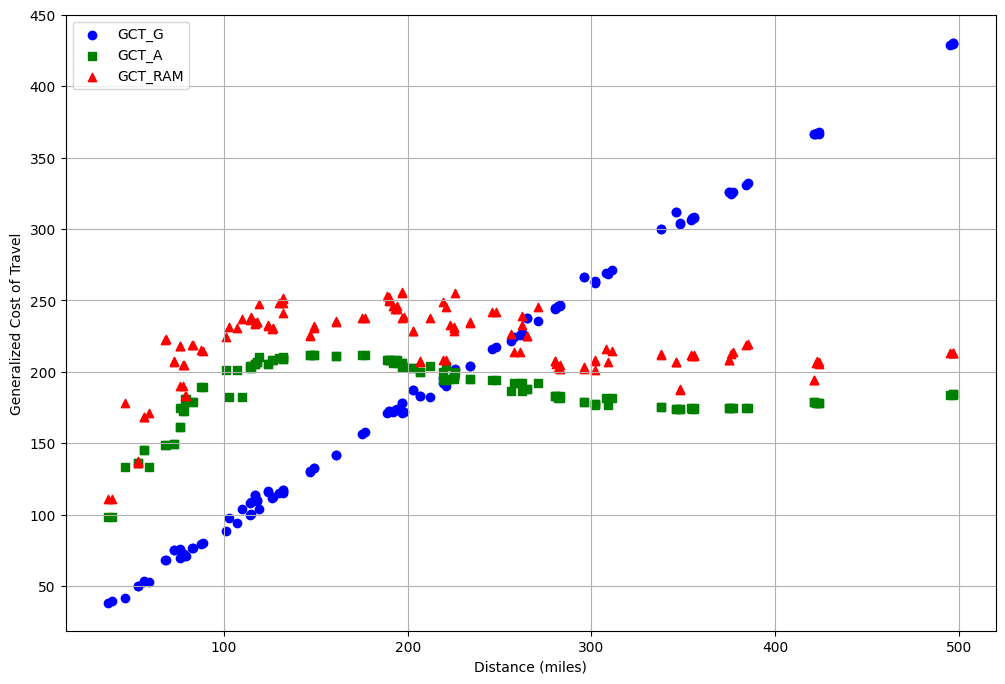

In [59]:
# Plot settings
plt.figure(figsize=(12, 8))

# Scatter plot for GCT_G
plt.scatter(df['Distance_G'], df['GCT_G'], label='GCT_G', color='blue', marker='o')
# Scatter plot for GCT_A
plt.scatter(df['Distance_G'], df['GCT_A'], label='GCT_A', color='green', marker='s')
# Scatter plot for GCT_RAM
plt.scatter(df['Distance_G'], df['GCT_RAM'], label='GCT_RAM', color='red', marker='^')

# Annotate some outliers
outliers = df[ (df['GCT_RAM'] > 350)]
for i, row in outliers.iterrows():
    plt.annotate(f"{row['Origin']}-{row['Destination']}",
                 (row['Distance_G'], row['GCT_RAM']),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Titles and labels
# plt.title('GCT vs Distance for Ground, Air, and RAM')
plt.xlabel('Distance (miles)')
plt.ylabel('Generalized Cost of Travel')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [60]:
df

Origin Destination  Distance_G       GCT_G       GCT_A     GCT_RAM  \
0    16860       17420        53.1   49.906844  136.127740  137.212861   
1    16860       27180       261.0  225.759301  192.050801  214.147249   
2    16860       27740       225.0  196.701127  196.789023  230.320291   
3    16860       28700       223.0  194.913960  194.784362  232.643744   
4    16860       28940       115.0  100.273439  203.719521  238.422708   
..     ...         ...         ...         ...         ...         ...   
535   RTN3       32820       132.0  115.153276  210.079251  241.111249   
536   RTN3       34100       302.0  262.396225  176.853913  201.022065   
537   RTN3       34980       101.0   88.696520  201.270266  224.518310   
538   RTN3       17300       103.0   97.638603  182.291901  231.236074   
551   RTN3        RTN1       219.0  195.694792  199.969850  248.760277   

     Percentage Lowest_GCT  
0      0.724601      GCT_G  
1      0.883510    GCT_RAM  
2      0.848996      GCT_G  
3      0.851511      GCT_G  
4      0.837686      GCT_G  
..          ...        ...  
535    0.873735      GCT_G  
536    0.879196    GCT_RAM  
537    0.892877      GCT_G  
538    0.835584      GCT_G  
551    0.814344      GCT_G  

[132 rows x 8 columns]

/tmp/ipykernel_6550/1602562448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ram_switched['OD_Pair'] = df_ram_switched['Origin'].astype(str) + '-' + df_ram_switched['Destination'].astype(str)


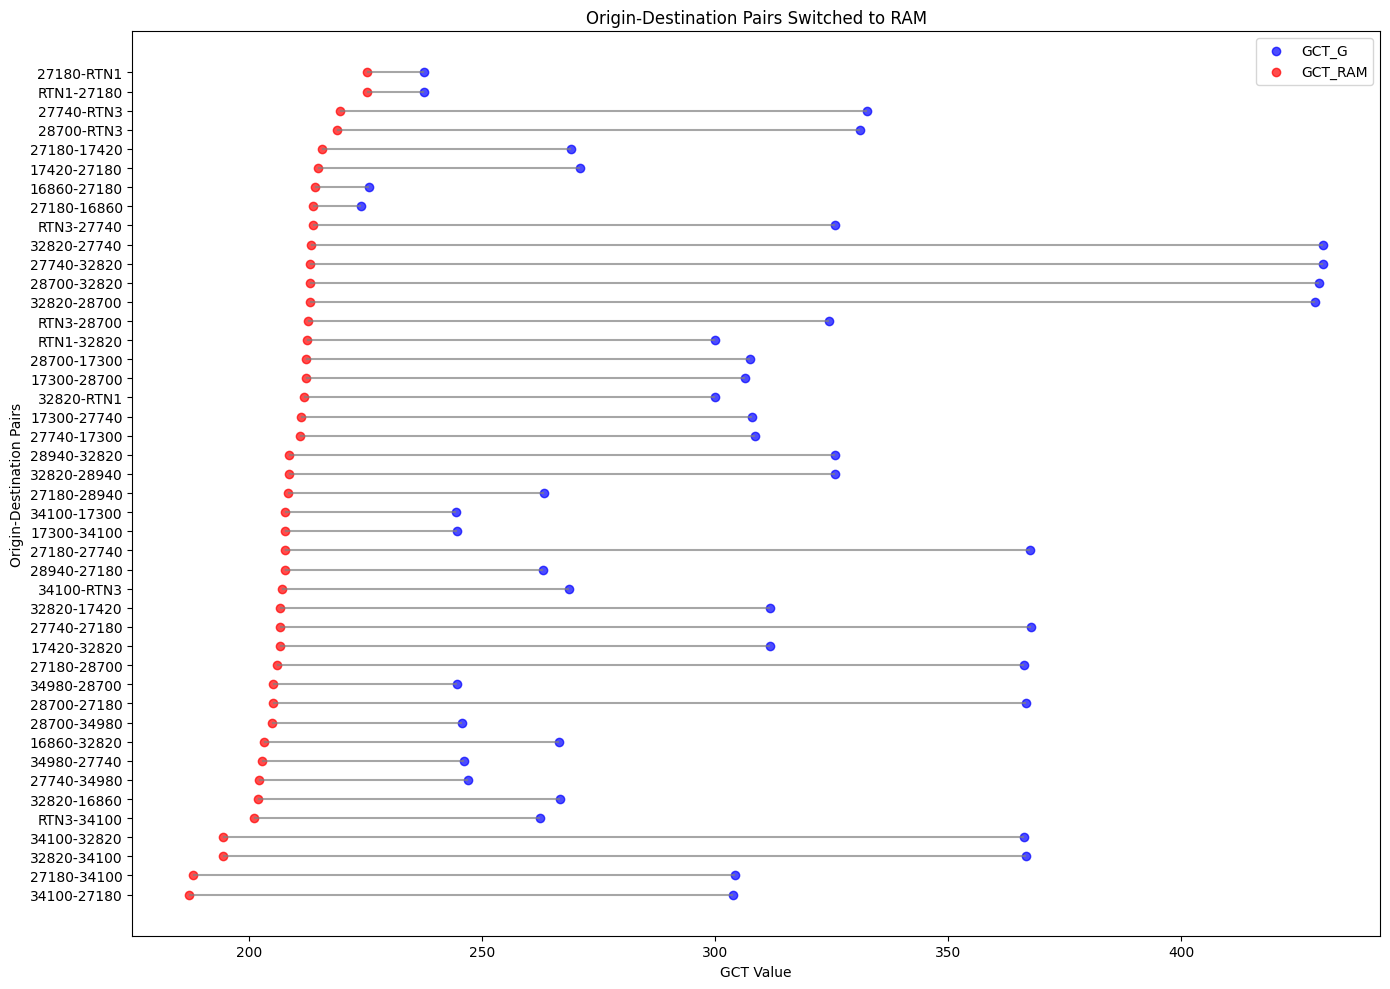

In [61]:
# Filter the dataframe for rows where Lowest_GCT is 'GCT_RAM'
df_ram_switched = df[df['Lowest_GCT'] == 'GCT_RAM']

# Create a new column for the Origin-Destination pair
df_ram_switched['OD_Pair'] = df_ram_switched['Origin'].astype(str) + '-' + df_ram_switched['Destination'].astype(str)

# Sort the dataframe by GCT_RAM to have a clear and structured plot
df_ram_switched = df_ram_switched.sort_values(by='GCT_RAM')

# Create the lollipop plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the stems
ax.hlines(y=df_ram_switched['OD_Pair'], xmin=df_ram_switched['GCT_G'], xmax=df_ram_switched['GCT_RAM'], color='gray', alpha=0.7)

# Plot the points
ax.scatter(df_ram_switched['GCT_G'], df_ram_switched['OD_Pair'], color='blue', alpha=0.7, label='GCT_G')
ax.scatter(df_ram_switched['GCT_RAM'], df_ram_switched['OD_Pair'], color='red', alpha=0.7, label='GCT_RAM')

# Add labels
ax.set_ylabel('Origin-Destination Pairs')
ax.set_xlabel('GCT Value')
ax.set_title('Origin-Destination Pairs Switched to RAM')
ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_6550/3874087193.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OD_Pair'] = df.apply(


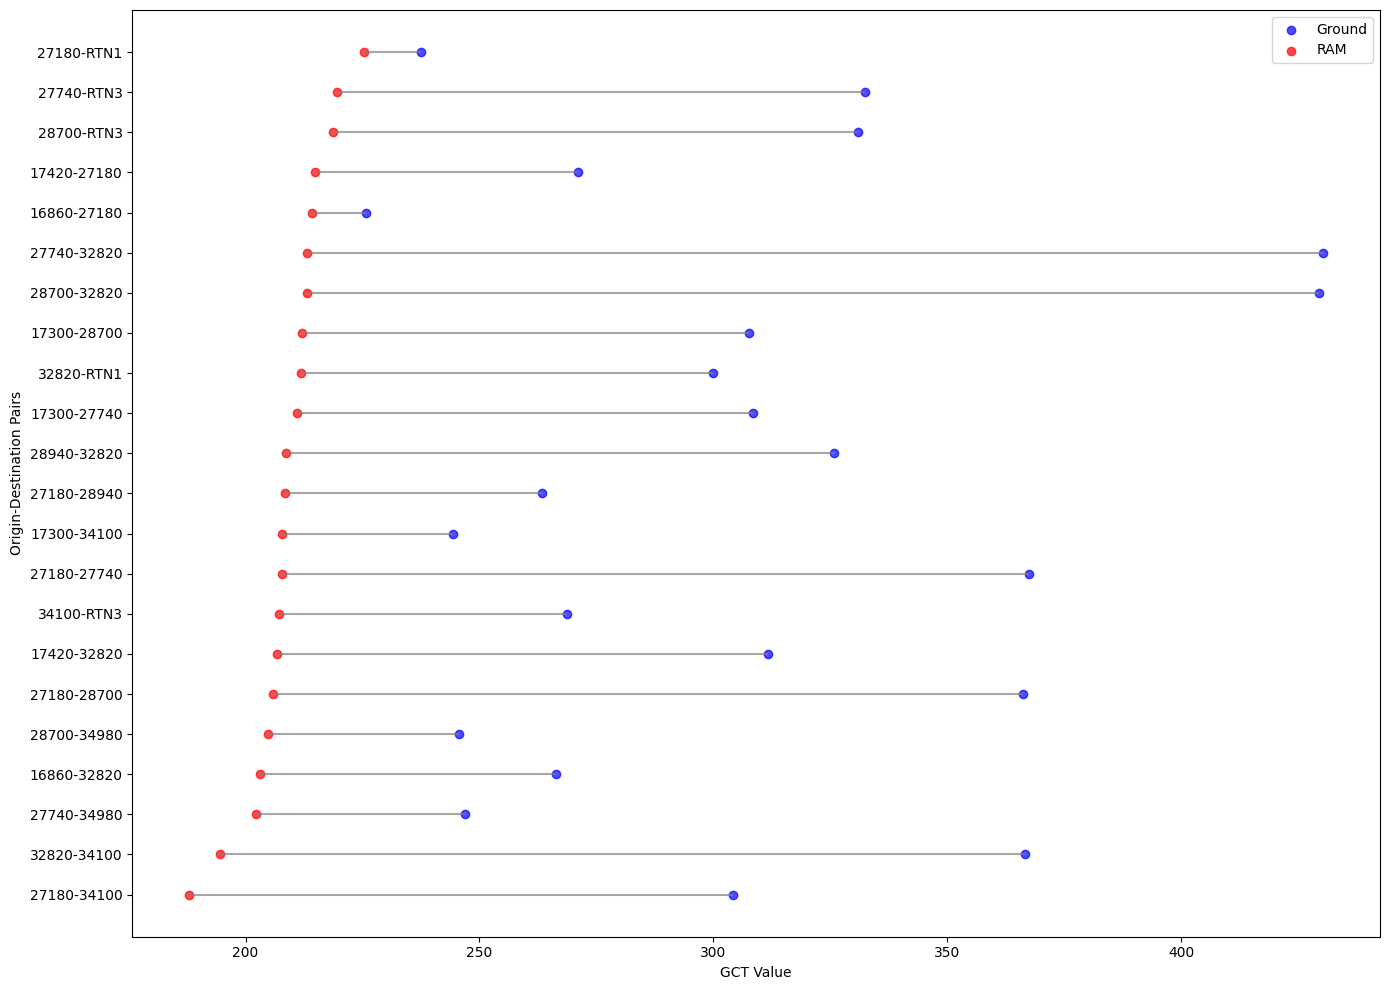

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a new column for the sorted Origin-Destination pair to handle duplicates
df['OD_Pair'] = df.apply(
    lambda row: '-'.join(sorted([str(row['Origin']), str(row['Destination'])])), axis=1
)

# Drop duplicates based on the new OD_Pair column
df_unique = df.drop_duplicates(subset=['OD_Pair'])

# Separate the data into switched and unswitched pairs
df_switched = df_unique[df_unique['Lowest_GCT'] == 'GCT_RAM']
df_unswitched = df_unique[df_unique['Lowest_GCT'] != 'GCT_RAM']

# Sort the dataframes by GCT_RAM to have a clear and structured plot
df_switched = df_switched.sort_values(by='GCT_RAM')
df_unswitched = df_unswitched.sort_values(by='GCT_RAM')

# Create the plot for switched pairs
fig1, ax1 = plt.subplots(figsize=(14, 10))
ax1.hlines(y=df_switched['OD_Pair'], xmin=df_switched['GCT_G'], xmax=df_switched['GCT_RAM'], color='gray', alpha=0.7)
ax1.scatter(df_switched['GCT_G'], df_switched['OD_Pair'], color='blue', alpha=0.7, label='Ground', marker='o')
ax1.scatter(df_switched['GCT_RAM'], df_switched['OD_Pair'], color='red', alpha=0.7, label='RAM', marker='o')
ax1.set_ylabel('Origin-Destination Pairs')
ax1.set_xlabel('GCT Value')
# ax1.set_title('Origin-Destination Pairs Switched to RAM')
ax1.legend()
plt.tight_layout()
plt.show()


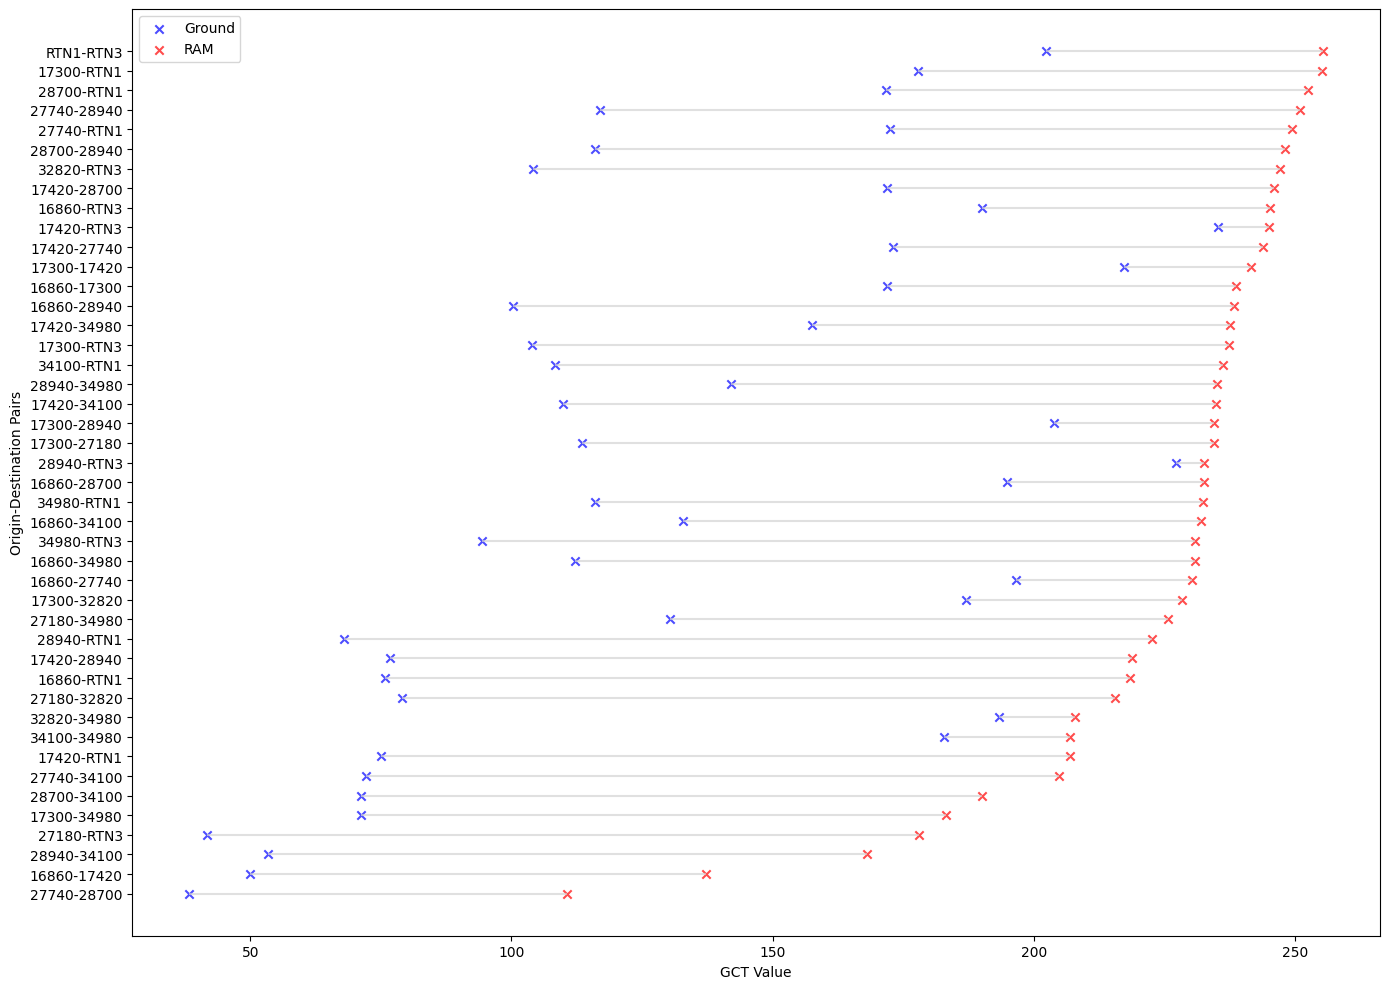

In [63]:
# Create the plot for unswitched pairs
fig2, ax2 = plt.subplots(figsize=(14, 10))
ax2.hlines(y=df_unswitched['OD_Pair'], xmin=df_unswitched['GCT_G'], xmax=df_unswitched['GCT_RAM'], color='lightgray', alpha=0.7)
ax2.scatter(df_unswitched['GCT_G'], df_unswitched['OD_Pair'], color='blue', alpha=0.7, label='Ground', marker='x')
ax2.scatter(df_unswitched['GCT_RAM'], df_unswitched['OD_Pair'], color='red', alpha=0.7, label='RAM', marker='x')
ax2.set_ylabel('Origin-Destination Pairs')
ax2.set_xlabel('GCT Value')
# ax2.set_title('Origin-Destination Pairs Unswitched to RAM')
ax2.legend()
plt.tight_layout()
plt.show()

In [64]:
df_new=df[ (df['GCT_RAM'] < df['GCT_G'])]
df_new.describe()

Distance_G       GCT_G       GCT_A     GCT_RAM  Percentage
count   44.000000   44.000000   44.000000   44.000000   44.000000
mean   350.954545  306.218971  179.141316  208.554993    0.860281
std     68.121627   57.815083    4.901983    7.889743    0.032354
min    258.000000  224.011800  173.947578  187.127486    0.796570
25%    296.000000  262.862850  174.489721  205.140604    0.840857
50%    347.000000  305.248568  178.038731  208.434906    0.863261
75%    384.250000  331.382762  182.905682  213.133751    0.883952
max    497.000000  430.423346  192.050801  225.380642    0.929503

In [65]:
df_new['Percentage'].min()

np.float64(0.7965704335547229)

/tmp/ipykernel_6550/1574037693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GCT_Difference'] = df['GCT_G'] - df['GCT_RAM']


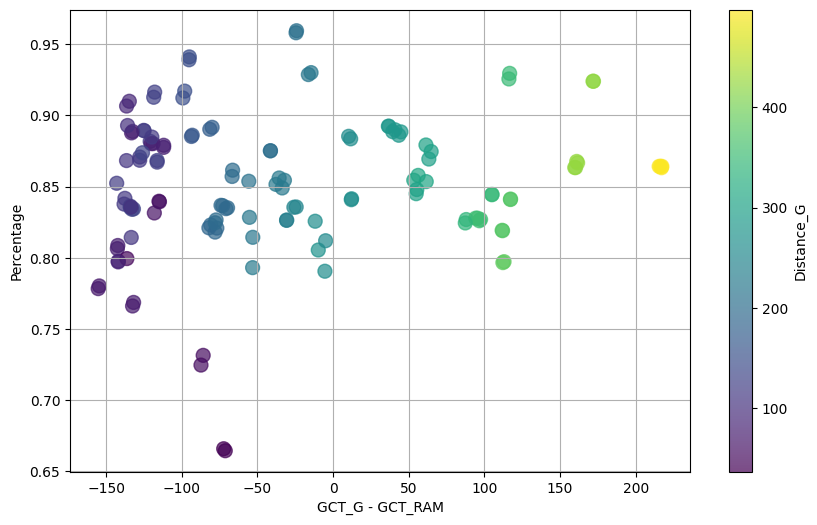

In [66]:

# Calculate GCT_G - GCT_RAM
df['GCT_Difference'] = df['GCT_G'] - df['GCT_RAM']


# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['GCT_Difference'], df['Percentage'], c=df['Distance_G'], cmap='viridis', s=100, alpha=0.7)
plt.xlabel('GCT_G - GCT_RAM')
plt.ylabel('Percentage')
# plt.title('Plot of GCT_G - GCT_RAM against Percentage with Distance_G')
plt.colorbar(scatter, label='Distance_G')
plt.grid(True)
plt.show()

# Percentage above around 80 and distance above around 250 miles in case of Tennessee state

In [67]:
df

Origin Destination  Distance_G       GCT_G       GCT_A     GCT_RAM  \
0    16860       17420        53.1   49.906844  136.127740  137.212861   
1    16860       27180       261.0  225.759301  192.050801  214.147249   
2    16860       27740       225.0  196.701127  196.789023  230.320291   
3    16860       28700       223.0  194.913960  194.784362  232.643744   
4    16860       28940       115.0  100.273439  203.719521  238.422708   
..     ...         ...         ...         ...         ...         ...   
535   RTN3       32820       132.0  115.153276  210.079251  241.111249   
536   RTN3       34100       302.0  262.396225  176.853913  201.022065   
537   RTN3       34980       101.0   88.696520  201.270266  224.518310   
538   RTN3       17300       103.0   97.638603  182.291901  231.236074   
551   RTN3        RTN1       219.0  195.694792  199.969850  248.760277   

     Percentage Lowest_GCT      OD_Pair  GCT_Difference  
0      0.724601      GCT_G  16860-17420      -87.306018  
1      0.883510    GCT_RAM  16860-27180       11.612052  
2      0.848996      GCT_G  16860-27740      -33.619165  
3      0.851511      GCT_G  16860-28700      -37.729784  
4      0.837686      GCT_G  16860-28940     -138.149269  
..          ...        ...          ...             ...  
535    0.873735      GCT_G   32820-RTN3     -125.957974  
536    0.879196    GCT_RAM   34100-RTN3       61.374160  
537    0.892877      GCT_G   34980-RTN3     -135.821790  
538    0.835584      GCT_G   17300-RTN3     -133.597471  
551    0.814344      GCT_G    RTN1-RTN3      -53.065485  

[132 rows x 10 columns]

# Finding the Probability of choosing the mode of transportation

In [68]:
df_new = df.copy()
from sklearn.preprocessing import MinMaxScaler

# # Standardizing the values
# scaler = StandardScaler()
# df_new.loc[:, ['GCT_G', 'GCT_RAM']] = scaler.fit_transform(df_new[['GCT_G', 'GCT_RAM']])

scaler = MinMaxScaler()
df_new[['GCT_G', 'GCT_RAM']] = scaler.fit_transform(df_new[['GCT_G', 'GCT_RAM']])

# Calculate the P_RAM column
df_new['P_RAM'] = 1 / (1 + np.exp(df_new['GCT_RAM'] - df_new['GCT_G'])) # due to negative sign we swap the place

# Display the updated dataframe
df_new.head()

Origin Destination  Distance_G     GCT_G       GCT_A   GCT_RAM  Percentage  \
0  16860       17420        53.1  0.029618  136.127740  0.183257    0.724601   
1  16860       27180       261.0  0.478072  192.050801  0.712957    0.883510   
2  16860       27740       225.0  0.403968  196.789023  0.824310    0.848996   
3  16860       28700       223.0  0.399411  194.784362  0.840307    0.851511   
4  16860       28940       115.0  0.158061  203.719521  0.880095    0.837686   

  Lowest_GCT      OD_Pair  GCT_Difference     P_RAM  
0      GCT_G  16860-17420      -87.306018  0.461665  
1    GCT_RAM  16860-27180       11.612052  0.441547  
2      GCT_G  16860-27740      -33.619165  0.396435  
3      GCT_G  16860-28700      -37.729784  0.391528  
4      GCT_G  16860-28940     -138.149269  0.326945

In [69]:
# Calculate the P_RAM column
df_new['P_G'] = 1 / (1 + np.exp(df_new['GCT_G'] - df_new['GCT_RAM']))
df_new.head()

Origin Destination  Distance_G     GCT_G       GCT_A   GCT_RAM  Percentage  \
0  16860       17420        53.1  0.029618  136.127740  0.183257    0.724601   
1  16860       27180       261.0  0.478072  192.050801  0.712957    0.883510   
2  16860       27740       225.0  0.403968  196.789023  0.824310    0.848996   
3  16860       28700       223.0  0.399411  194.784362  0.840307    0.851511   
4  16860       28940       115.0  0.158061  203.719521  0.880095    0.837686   

  Lowest_GCT      OD_Pair  GCT_Difference     P_RAM       P_G  
0      GCT_G  16860-17420      -87.306018  0.461665  0.538335  
1    GCT_RAM  16860-27180       11.612052  0.441547  0.558453  
2      GCT_G  16860-27740      -33.619165  0.396435  0.603565  
3      GCT_G  16860-28700      -37.729784  0.391528  0.608472  
4      GCT_G  16860-28940     -138.149269  0.326945  0.673055

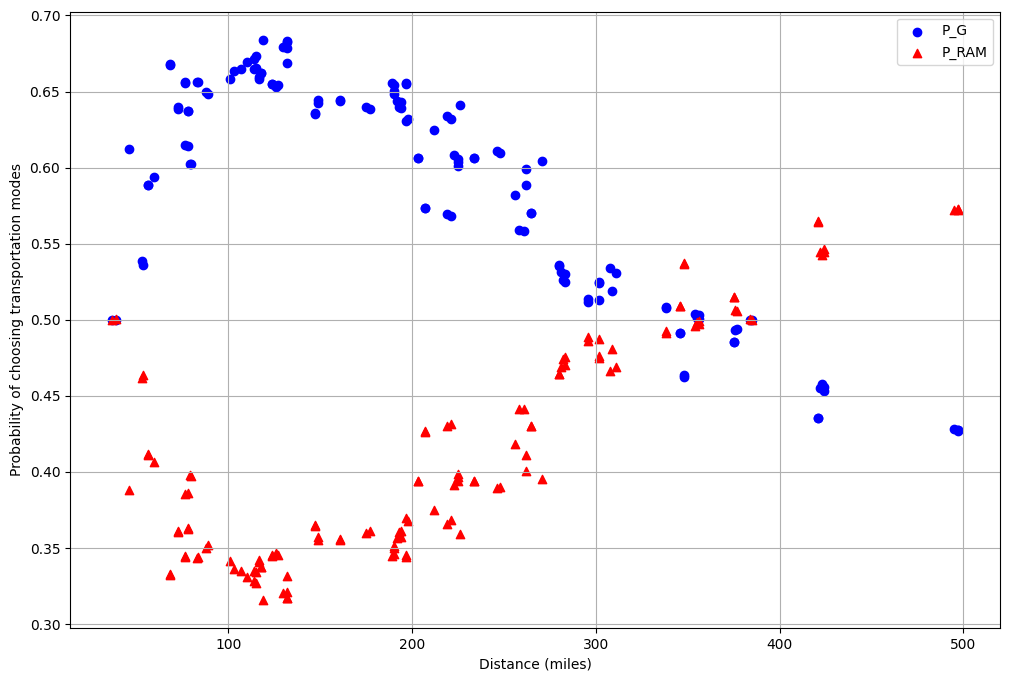

In [70]:
# Plot settings
plt.figure(figsize=(12, 8))

# Scatter plot for GCT_G
plt.scatter(df_new['Distance_G'], df_new['P_G'], label='P_G', color='blue', marker='o')
# Scatter plot for GCT_RAM
plt.scatter(df_new['Distance_G'], df_new['P_RAM'], label='P_RAM', color='red', marker='^')

# # Annotate some outliers
# outliers = df[ (df_new['GCT_RAM'] > 350)]
# for i, row in outliers.iterrows():
#     plt.annotate(f"{row['Origin']}-{row['Destination']}",
#                  (row['Distance_G'], row['GCT_RAM']),
#                  textcoords="offset points", xytext=(0,10), ha='center')

# Titles and labels
# plt.title('GCT vs Distance for Ground, Air, and RAM')
plt.xlabel('Distance (miles)')
plt.ylabel('Probability of choosing transportation modes')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

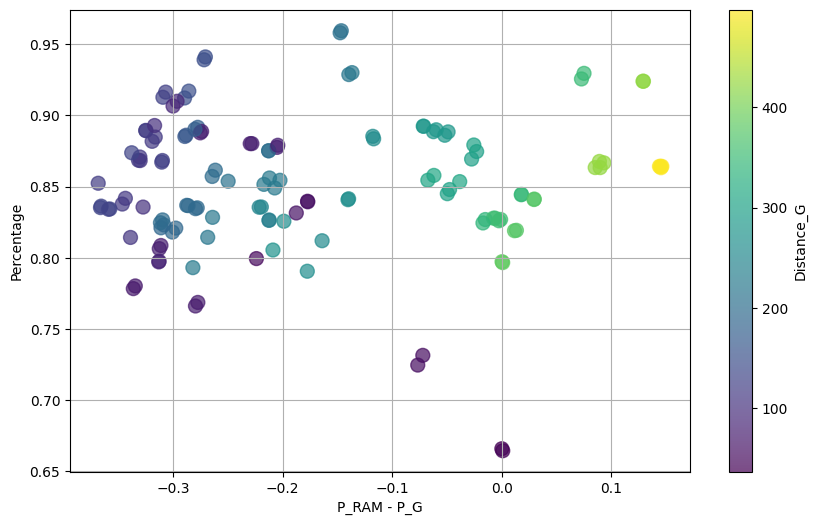

In [71]:
# Calculate GCT_G - GCT_RAM
df_new['P_Difference'] = df_new['P_RAM'] - df_new['P_G']


# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_new['P_Difference'], df_new['Percentage'], c=df_new['Distance_G'], cmap='viridis', s=100, alpha=0.7)
plt.xlabel('P_RAM - P_G')
plt.ylabel('Percentage')
# plt.title('Plot of GCT_G - GCT_RAM against Percentage with Distance_G')
plt.colorbar(scatter, label='Distance_G')
plt.grid(True)
plt.show()

# Percentage above around 80 and distance above around 250 miles in case of Tennessee state

# Finding Monthly trip demand for Ground transportation and RAM for all Origins

We have data in monthly basis for 2021 and 2022, we will average the data that will provide the trip demand data for that month. Two ways for finding RAM demand

1. We will use the pair of switched OD pairs and find the demand from those.
2. We will use the trip which are greater than 300 miles to be considered as the RAM trip



## First Method

In [72]:
MSA = {
    "Chattanooga, TN-GA": "16860",
    "Clarksville, TN-KY": "17300",
    "Cleveland, TN": "17420",
    "Jackson, TN": "27180",
    "Johnson City, TN": "27740",
    "Kingsport-Bristol-Bristol, TN-VA": "28700",
    "Knoxville, TN": "28940",
    "Memphis, TN-MS-AR": "32820",
    "Morristown, TN": "34100",
    "Nashville-Davidson-Murfreesboro-Franklin, TN": "34980",
    "TN-NonMSA areas (E)": "RTN1",
    "TN-NonMSA areas (W)": "RTN3"
}


In [73]:
df=pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Data/Final_Monthly/Regional_Tennessee_21_22.csv")
df

year  month     origin_zone_name  \
0     2021      1   Chattanooga, TN-GA   
1     2021      1   Chattanooga, TN-GA   
2     2021      1   Chattanooga, TN-GA   
3     2021      1   Chattanooga, TN-GA   
4     2021      1   Chattanooga, TN-GA   
...    ...    ...                  ...   
3451  2022     12  TN-NonMSA areas (W)   
3452  2022     12  TN-NonMSA areas (W)   
3453  2022     12  TN-NonMSA areas (W)   
3454  2022     12  TN-NonMSA areas (W)   
3455  2022     12  TN-NonMSA areas (W)   

                             destination_zone_name  mode_air  mode_rail  \
0                               Chattanooga, TN-GA         0          2   
1                               Clarksville, TN-KY         0          0   
2                                    Cleveland, TN         0          0   
3                                      Jackson, TN         0          0   
4                                 Johnson City, TN         0          0   
...                                            ...       ...        ...   
3451                             Memphis, TN-MS-AR         0          0   
3452                                Morristown, TN         0          0   
3453  Nashville-Davidson-Murfreesboro-Franklin, TN         0          0   
3454                           TN-NonMSA areas (E)         0          0   
3455                           TN-NonMSA areas (W)         0          0   

      mode_vehicle  mode_atf  purpose_work  purpose_nonwork  ...  \
0            24234         0          3776            20460  ...   
1             3684         0           309             3375  ...   
2            15699         0          2721            12978  ...   
3             1759         0           395             1364  ...   
4             3554         0           363             3191  ...   
...            ...       ...           ...              ...  ...   
3451        165429         0         39576           125853  ...   
3452          1514         0           385             1129  ...   
3453        508996         0        123092           385904  ...   
3454         47272         0         12531            34741  ...   
3455        366803         0         90777           276026  ...   

      vehicle_75_100mi  vehicle_100_150mi  vehicle_150_300mi  vehicle_gt300mi  \
0                 2908                  0                  0               26   
1                    0                  0               3684                0   
2                 4206                173                  0                7   
3                    0                  0               1596              163   
4                    0                  0               3554                0   
...                ...                ...                ...              ...   
3451             34805              56187               9844              247   
3452                 0                  0                768              746   
3453            145219              83295              24087                0   
3454              7010               8044              10703             6725   
3455             72953              32166               5551                0   

      atf_50_75mi  atf_75_100mi  atf_100_150mi  atf_150_300mi  atf_gt300mi  \
0               0             0              0              0            0   
1               0             0              0              0            0   
2               0             0              0              0            0   
3               0             0              0              0            0   
4               0             0              0              0            0   
...           ...           ...            ...            ...          ...   
3451            0             0              0              0            0   
3452            0             0              0              0            0   
3453            0             0              0              0            0   
3454            0             

In [74]:
# Replace values in origin_zone_name and destination_zone_name with the corresponding CBSA code from the MSA dictionary
df['origin_zone_name'] = df['origin_zone_name'].map(MSA)
df['destination_zone_name'] = df['destination_zone_name'].map(MSA)

# Display the updated dataframe
df

year  month origin_zone_name destination_zone_name  mode_air  mode_rail  \
0     2021      1            16860                 16860         0          2   
1     2021      1            16860                 17300         0          0   
2     2021      1            16860                 17420         0          0   
3     2021      1            16860                 27180         0          0   
4     2021      1            16860                 27740         0          0   
...    ...    ...              ...                   ...       ...        ...   
3451  2022     12             RTN3                 32820         0          0   
3452  2022     12             RTN3                 34100         0          0   
3453  2022     12             RTN3                 34980         0          0   
3454  2022     12             RTN3                  RTN1         0          0   
3455  2022     12             RTN3                  RTN3         0          0   

      mode_vehicle  mode_atf  purpose_work  purpose_nonwork  ...  \
0            24234         0          3776            20460  ...   
1             3684         0           309             3375  ...   
2            15699         0          2721            12978  ...   
3             1759         0           395             1364  ...   
4             3554         0           363             3191  ...   
...            ...       ...           ...              ...  ...   
3451        165429         0         39576           125853  ...   
3452          1514         0           385             1129  ...   
3453        508996         0        123092           385904  ...   
3454         47272         0         12531            34741  ...   
3455        366803         0         90777           276026  ...   

      vehicle_75_100mi  vehicle_100_150mi  vehicle_150_300mi  vehicle_gt300mi  \
0                 2908                  0                  0               26   
1                    0                  0               3684                0   
2                 4206                173                  0                7   
3                    0                  0               1596              163   
4                    0                  0               3554                0   
...                ...                ...                ...              ...   
3451             34805              56187               9844              247   
3452                 0                  0                768              746   
3453            145219              83295              24087                0   
3454              7010               8044              10703             6725   
3455             72953              32166               5551                0   

      atf_50_75mi  atf_75_100mi  atf_100_150mi  atf_150_300mi  atf_gt300mi  \
0               0             0              0              0            0   
1               0             0              0              0            0   
2               0             0              0              0            0   
3               0             0              0              0            0   
4               0             0              0              0            0   
...           ...           ...            ...            ...          ...   
3451            0             0              0              0            0   
3452            0             0              0              0            0   
3453            0             0              0              0            0   
3454            0             0              0              0            0   
3455            0             0              0              0            0   

      Demand  
0      24236  
1       3684  
2      15699  
3       1759  
4       3554  
...      ...  
3451  165429  
3452    1514  
3453  508996  
3454   47272  
3455  366803  

[3456 rows x 46 columns]

In [75]:
new_df = df[['year', 'month', 'origin_zone_name', 'destination_zone_name', 'mode_vehicle', 'vehicle_50_75mi', 'vehicle_75_100mi', 'vehicle_100_150mi', 'vehicle_150_300mi', 'vehicle_gt300mi']]
new_df

year  month origin_zone_name destination_zone_name  mode_vehicle  \
0     2021      1            16860                 16860         24234   
1     2021      1            16860                 17300          3684   
2     2021      1            16860                 17420         15699   
3     2021      1            16860                 27180          1759   
4     2021      1            16860                 27740          3554   
...    ...    ...              ...                   ...           ...   
3451  2022     12             RTN3                 32820        165429   
3452  2022     12             RTN3                 34100          1514   
3453  2022     12             RTN3                 34980        508996   
3454  2022     12             RTN3                  RTN1         47272   
3455  2022     12             RTN3                  RTN3        366803   

      vehicle_50_75mi  vehicle_75_100mi  vehicle_100_150mi  vehicle_150_300mi  \
0               21300              2908                  0                  0   
1                   0                 0                  0               3684   
2               11313              4206                173                  0   
3                   0                 0                  0               1596   
4                   0                 0                  0               3554   
...               ...               ...                ...                ...   
3451            64346             34805              56187               9844   
3452                0                 0                  0                768   
3453           256395            145219              83295              24087   
3454            14790              7010               8044              10703   
3455           256133             72953              32166               5551   

      vehicle_gt300mi  
0                  26  
1                   0  
2                   7  
3                 163  
4                   0  
...               ...  
3451              247  
3452              746  
3453                0  
3454             6725  
3455                0  

[3456 rows x 10 columns]

In [76]:
# Group by month, origin_zone_name, and destination_zone_name, then aggregate by summing up the values
monthly_df = new_df.groupby(['month', 'origin_zone_name', 'destination_zone_name']).agg({
    'mode_vehicle': 'mean',
    'vehicle_50_75mi': 'mean',
    'vehicle_75_100mi': 'mean',
    'vehicle_100_150mi': 'mean',
    'vehicle_150_300mi': 'mean',
    'vehicle_gt300mi': 'mean'
}).reset_index()

# Round the numeric mean values to the nearest integer
numeric_columns = ['mode_vehicle', 'vehicle_50_75mi', 'vehicle_75_100mi', 'vehicle_100_150mi', 'vehicle_150_300mi', 'vehicle_gt300mi']
monthly_df[numeric_columns] = monthly_df[numeric_columns].round(0).astype(int)

monthly_df

month origin_zone_name destination_zone_name  mode_vehicle  \
0         1            16860                 16860         15994   
1         1            16860                 17300          3558   
2         1            16860                 17420         11902   
3         1            16860                 27180          1930   
4         1            16860                 27740          4446   
...     ...              ...                   ...           ...   
1723     12             RTN3                 32820        205996   
1724     12             RTN3                 34100          2036   
1725     12             RTN3                 34980        648686   
1726     12             RTN3                  RTN1         75164   
1727     12             RTN3                  RTN3        486486   

      vehicle_50_75mi  vehicle_75_100mi  vehicle_100_150mi  vehicle_150_300mi  \
0               14070              1910                  0                  0   
1                   0                 0                  0               3558   
2                9302              2510                 86                  0   
3                   0                 0                  0               1799   
4                   0                 0                  0               4446   
...               ...               ...                ...                ...   
1723            62056             40261              83450              19500   
1724                0                 0                  0               1206   
1725           268532            201221             134919              44014   
1726            23416              9836              12863              17054   
1727           317858            106538              50627              11458   

      vehicle_gt300mi  
0                  13  
1                   0  
2                   4  
3                 130  
4                   0  
...               ...  
1723              730  
1724              830  
1725                1  
1726            11994  
1727                4  

[1728 rows x 9 columns]

In [77]:
# Using first method ie focussin on the switched OD pairs

# df_switched_first = df_switched[['OD_Pair']]
df_switched_first = df_ram_switched[['OD_Pair']]
df_switched_first

OD_Pair
163  34100-27180
52   27180-34100
144  32820-34100
167  34100-32820
536   RTN3-34100
138  32820-16860
76   27740-34980
187  34980-27740
5    16860-32820
99   28700-34980
94   28700-27180
188  34980-28700
49   27180-28700
28   17420-32820
71   27740-27180
139  32820-17420
183   34100-RTN3
117  28940-27180
48   27180-27740
214  17300-34100
169  34100-17300
50   27180-28940
143  32820-28940
120  28940-32820
77   27740-17300
210  17300-27740
159   32820-RTN1
211  17300-28700
100  28700-17300
512   RTN1-32820
533   RTN3-28700
142  32820-28700
97   28700-32820
74   27740-32820
141  32820-27740
532   RTN3-27740
46   27180-16860
1    16860-27180
24   17420-27180
47   27180-17420
114   28700-RTN3
91    27740-RTN3
508   RTN1-27180
67    27180-RTN1

In [78]:
monthly_df_first= monthly_df.copy()

# Create a new column 'OD_Pair' with concatenated values of 'Origin Zone' and 'Destination Zone'
monthly_df_first['OD_Pair'] = monthly_df_first['origin_zone_name'] + '-' + monthly_df_first['destination_zone_name']

# Remove the 'Origin Zone' and 'Destination Zone' columns
monthly_df_first.drop(columns=[ 'destination_zone_name', 'vehicle_50_75mi', 'vehicle_75_100mi', 'vehicle_100_150mi', 'vehicle_150_300mi', 'vehicle_gt300mi'], inplace=True)


# # Renaming columns
# monthly_df_first.rename(columns={
#     'month': 'Month',
#     'origin_zone_name': 'Origin',
#     'mode_vehicle': 'Mode Vehicle',
#     'vehicle_gt300mi': 'Mode RAM'
# }, inplace=True)


monthly_df_first

month origin_zone_name  mode_vehicle      OD_Pair
0         1            16860         15994  16860-16860
1         1            16860          3558  16860-17300
2         1            16860         11902  16860-17420
3         1            16860          1930  16860-27180
4         1            16860          4446  16860-27740
...     ...              ...           ...          ...
1723     12             RTN3        205996   RTN3-32820
1724     12             RTN3          2036   RTN3-34100
1725     12             RTN3        648686   RTN3-34980
1726     12             RTN3         75164    RTN3-RTN1
1727     12             RTN3        486486    RTN3-RTN3

[1728 rows x 4 columns]

In [79]:
# Merge the two dataframes to identify rows to be switched
merged_df = monthly_df_first.merge(df_switched_first, on='OD_Pair', how='left', indicator=True)

# Add a new column 'RAM' and set it to 1 if the trip is a RAM trip
merged_df['RAM'] = merged_df.apply(
    lambda row: 1 if row['_merge'] == 'both' else 0, axis=1
)

# Drop the merge indicator column
merged_df.drop(columns=['_merge'], inplace=True)

# Display the updated dataframe
merged_df

month origin_zone_name  mode_vehicle      OD_Pair  RAM
0         1            16860         15994  16860-16860    0
1         1            16860          3558  16860-17300    0
2         1            16860         11902  16860-17420    0
3         1            16860          1930  16860-27180    1
4         1            16860          4446  16860-27740    0
...     ...              ...           ...          ...  ...
1723     12             RTN3        205996   RTN3-32820    0
1724     12             RTN3          2036   RTN3-34100    1
1725     12             RTN3        648686   RTN3-34980    0
1726     12             RTN3         75164    RTN3-RTN1    0
1727     12             RTN3        486486    RTN3-RTN3    0

[1728 rows x 5 columns]

In [80]:
# Group by 'month' and 'origin_zone_name' and sum the values of 'mode_vehicle' for categories where RAM is 1 and 0
grouped_df = merged_df.groupby(['month', 'origin_zone_name', 'RAM'])['mode_vehicle'].sum().reset_index()

# Pivot the dataframe to get separate columns for RAM=0 and RAM=1
pivot_df = grouped_df.pivot(index=['month', 'origin_zone_name'], columns='RAM', values='mode_vehicle').reset_index()

# Rename the columns for clarity
pivot_df.columns = ['month', 'origin_zone_name', 'mode_vehicle_RAM_0', 'mode_vehicle_RAM_1']

# Fill NaN values with 0 (in case there are no trips for RAM=1 or RAM=0 in some groups)
pivot_df.fillna(0, inplace=True)


# Renaming columns
pivot_df.rename(columns={
    'month': 'Month',
    'origin_zone_name': 'Origin',
    'mode_vehicle_RAM_0': 'Mode Vehicle',
    'mode_vehicle_RAM_1': 'Mode RAM'
}, inplace=True)

# Display the final dataframe
pivot_df

Month Origin  Mode Vehicle  Mode RAM
0        1  16860        665668      5596
1        1  17300        432505      2353
2        1  17420        145927      1820
3        1  27180        372034     10122
4        1  27740        164013     24951
..     ...    ...           ...       ...
139     12  32820        488245     30015
140     12  34100        226130      2967
141     12  34980       3044762     30086
142     12   RTN1       1787450     14884
143     12   RTN3       1740372      6042

[144 rows x 4 columns]

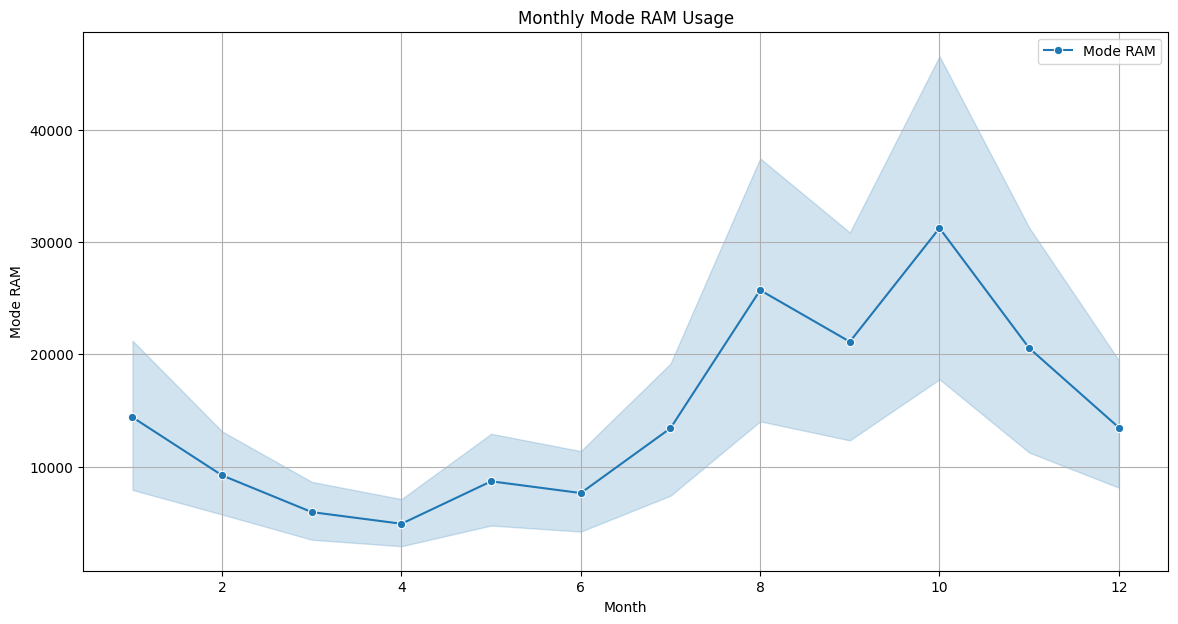

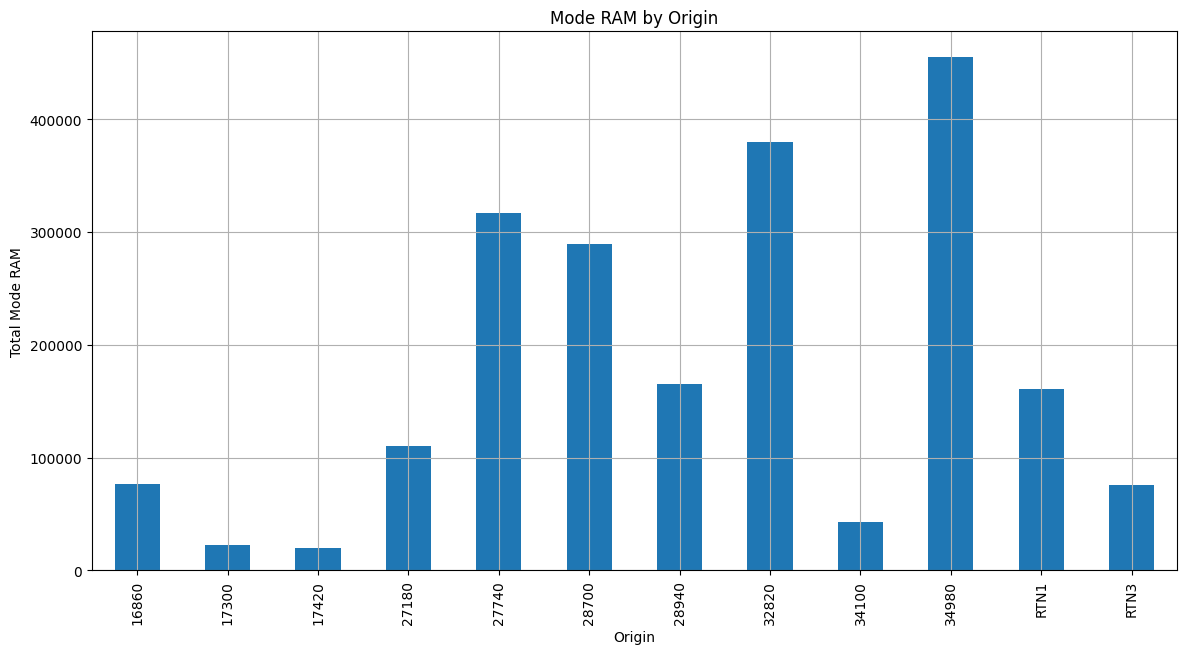

In [81]:
# Line plot of Mode RAM over Months
plt.figure(figsize=(14, 7))
sns.lineplot(data=pivot_df, x='Month', y='Mode RAM', label='Mode RAM', marker='o')
plt.title('Monthly Mode RAM Usage')
plt.xlabel('Month')
plt.ylabel('Mode RAM')
plt.legend()
plt.grid(True)
plt.show()

# Bar plot of Mode RAM for different Origins
plt.figure(figsize=(14, 7))
pivot_df.groupby('Origin')['Mode RAM'].sum().plot(kind='bar')
plt.title('Mode RAM by Origin')
plt.xlabel('Origin')
plt.ylabel('Total Mode RAM')
plt.grid(True)
plt.show()

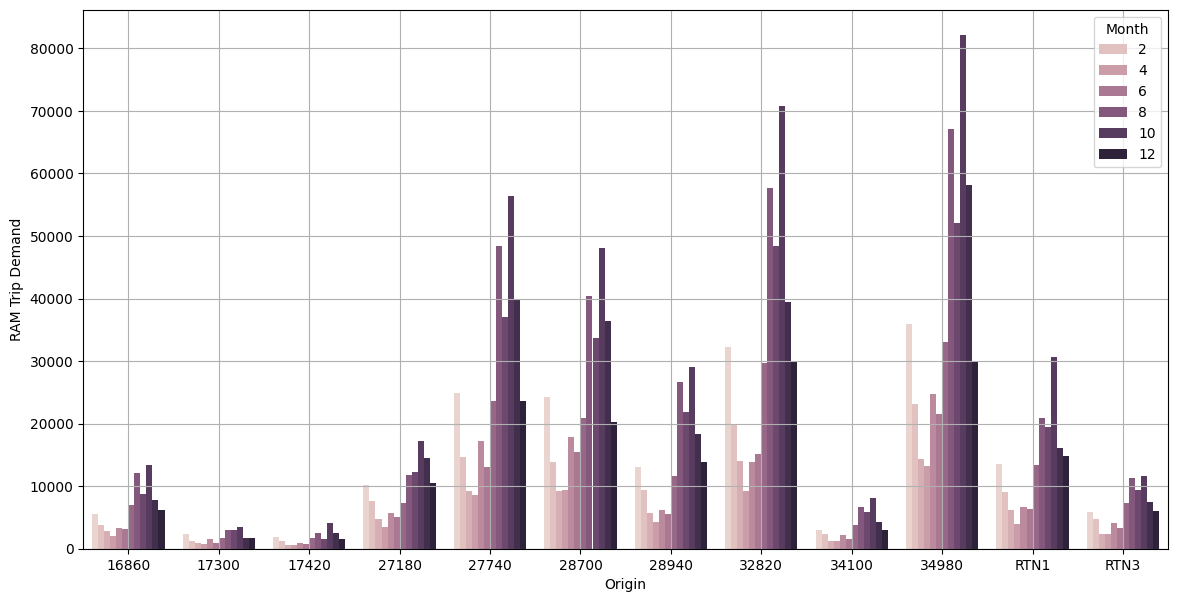

In [82]:
# Aggregate the data
pivot_df_aggregated = pivot_df.groupby(['Origin', 'Month'])['Mode RAM'].sum().reset_index()

# Pivot the data to have Months as columns
pivot_table = pivot_df_aggregated.pivot(index='Origin', columns='Month', values='Mode RAM').fillna(0)

# Reset the index and melt the DataFrame for easier plotting
pivot_table_reset = pivot_table.reset_index()
melted_df = pivot_table_reset.melt(id_vars='Origin', var_name='Month', value_name='Mode RAM')


plt.figure(figsize=(14, 7))
sns.barplot(data=melted_df, x='Origin', y='Mode RAM', hue='Month')
# plt.title('Mode RAM by Origin for Each Month')
plt.xlabel('Origin')
plt.ylabel('RAM Trip Demand')
plt.legend(title='Month')
plt.grid(True)
plt.show()

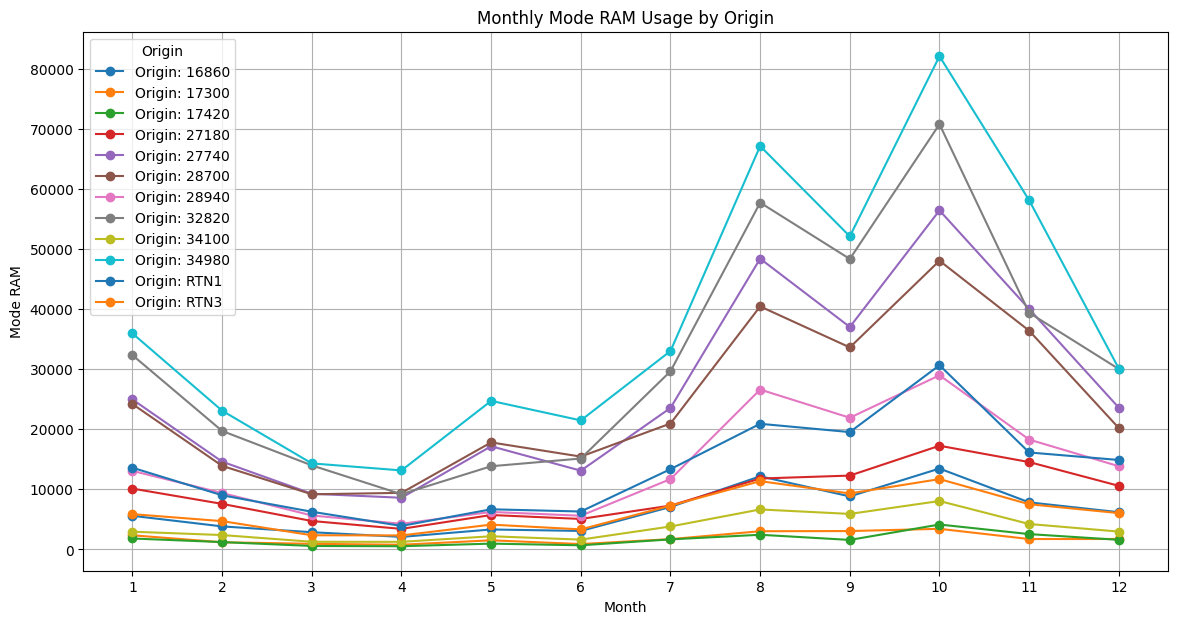

In [83]:
# Extract unique origins
unique_origins = pivot_df['Origin'].unique()

plt.figure(figsize=(14, 7))

# Loop through each unique origin and plot the data
for origin in unique_origins:
    subset = pivot_df[pivot_df['Origin'] == origin]
    plt.plot(subset['Month'], subset['Mode RAM'], marker='o', label=f'Origin: {origin}')

plt.title('Monthly Mode RAM Usage by Origin')
plt.xlabel('Month')
plt.ylabel('Mode RAM')
plt.legend(title='Origin')
plt.grid(True)
plt.xticks(ticks=pivot_df['Month'].unique())
plt.show()

In [84]:
# merged_df
df_filtered = merged_df[merged_df['RAM'] == 1]
df_filtered = df_filtered[['month', 'OD_Pair', 'mode_vehicle']]
df_filtered

month      OD_Pair  mode_vehicle
3         1  16860-27180          1930
7         1  16860-32820          3666
16        1  17300-27740           920
17        1  17300-28700           586
20        1  17300-34100           847
...     ...          ...           ...
1707     12   RTN1-27180          4805
1711     12   RTN1-32820         10079
1720     12   RTN3-27740          1370
1721     12   RTN3-28700          2636
1724     12   RTN3-34100          2036

[528 rows x 3 columns]

In [85]:
# Splitting the 'OD_Pair' column into 'Origin' and 'Destination'
df_filtered[['Origin', 'Destination']] = df_filtered['OD_Pair'].str.split('-', expand=True)

# Dropping the 'OD_Pair' column
df_filtered.drop(columns=['OD_Pair'], inplace=True)

# Renaming the 'mode_vehicle' column to 'Mode RAM'
df_filtered.rename(columns={'mode_vehicle': 'Mode RAM', 'month' : 'Month'}, inplace=True)

# Display the updated dataframe
df_filtered

Month  Mode RAM Origin Destination
3         1      1930  16860       27180
7         1      3666  16860       32820
16        1       920  17300       27740
17        1       586  17300       28700
20        1       847  17300       34100
...     ...       ...    ...         ...
1707     12      4805   RTN1       27180
1711     12     10079   RTN1       32820
1720     12      1370   RTN3       27740
1721     12      2636   RTN3       28700
1724     12      2036   RTN3       34100

[528 rows x 4 columns]

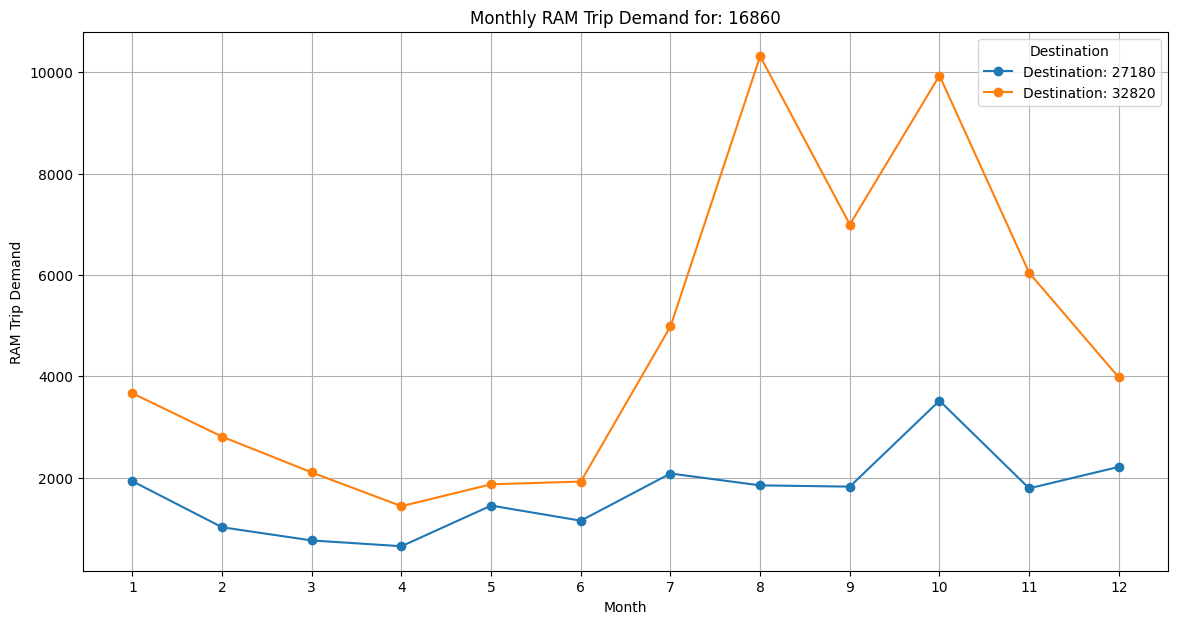

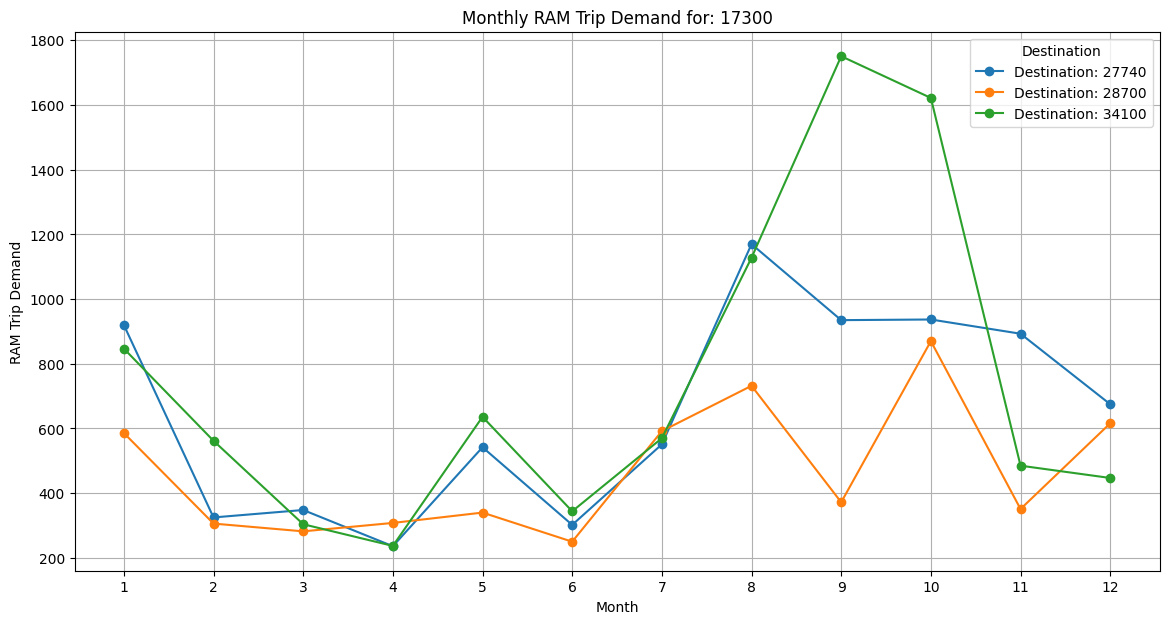

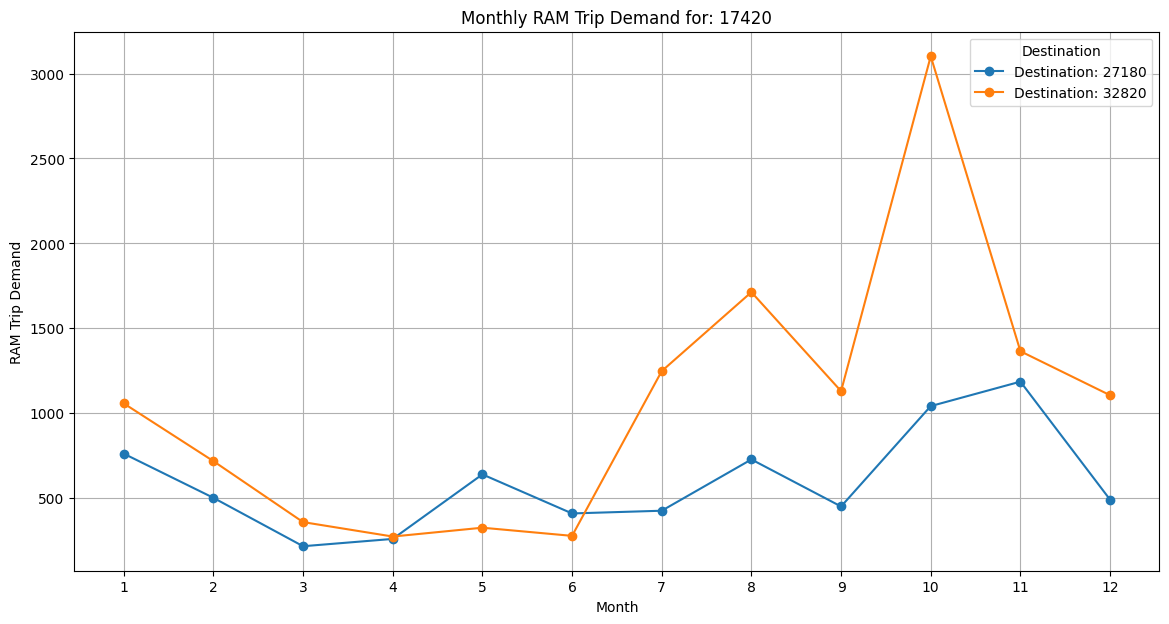

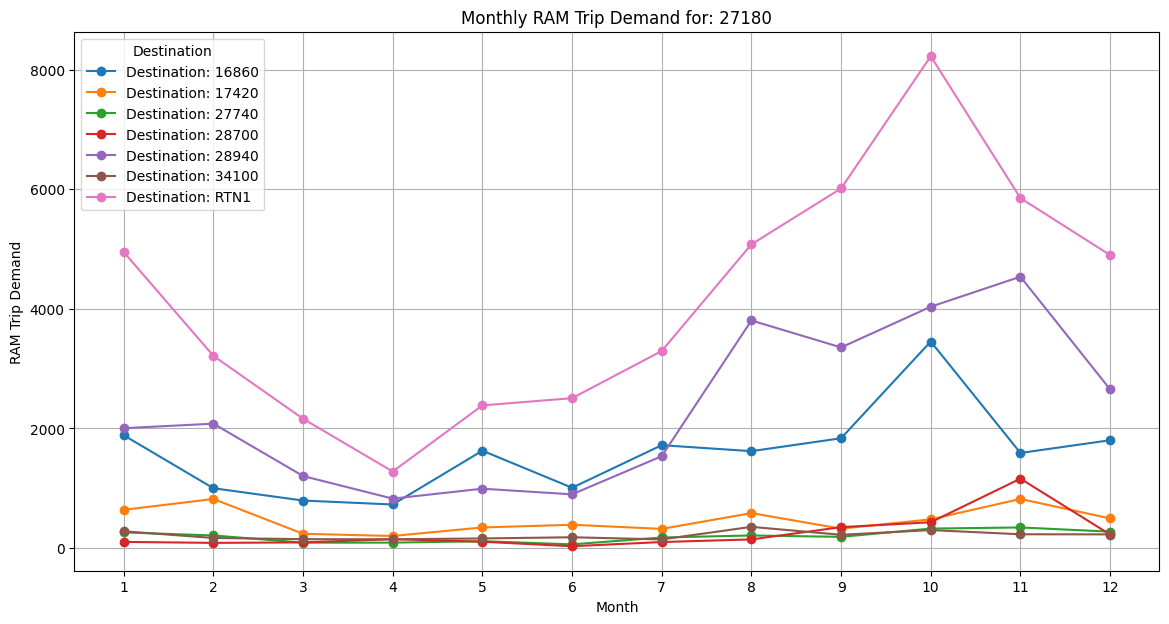

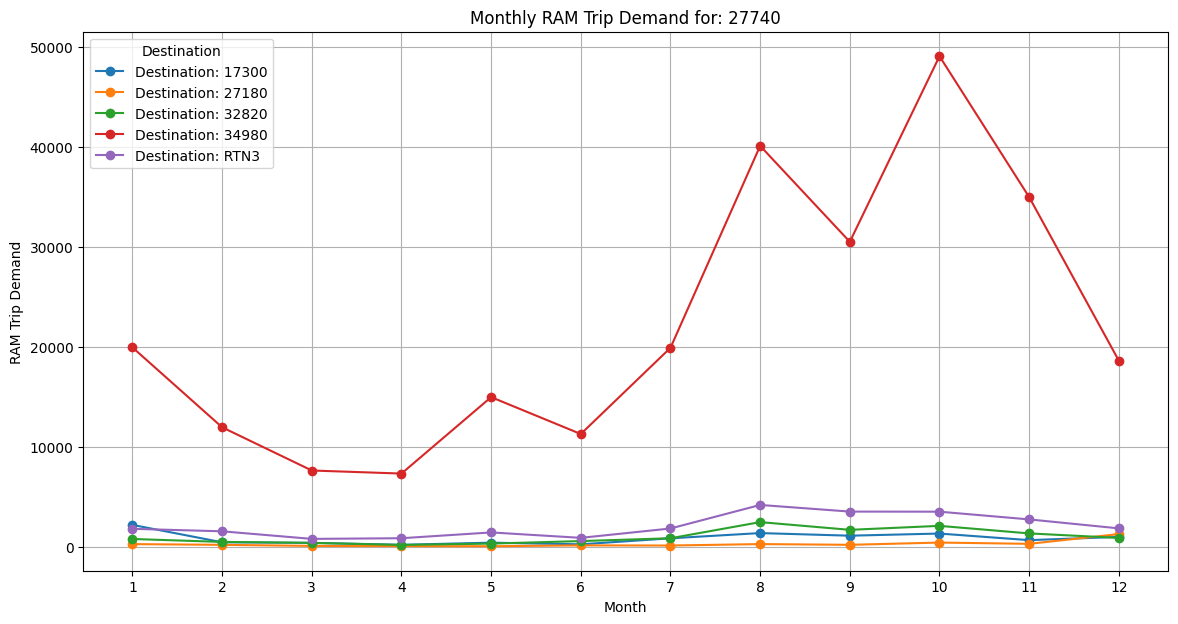

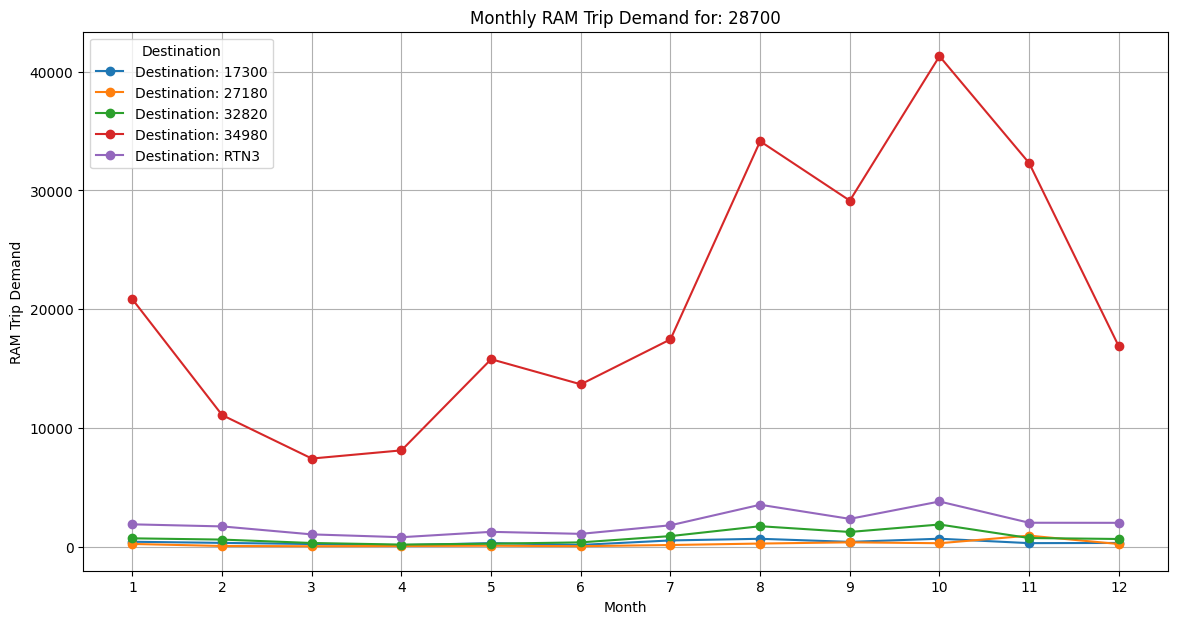

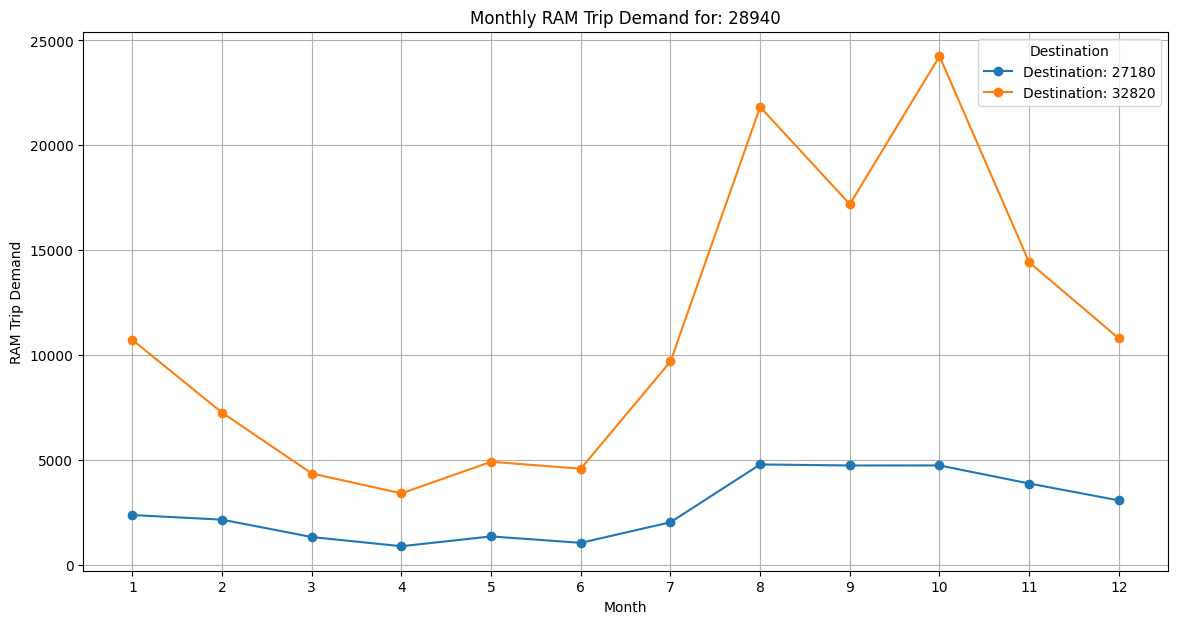

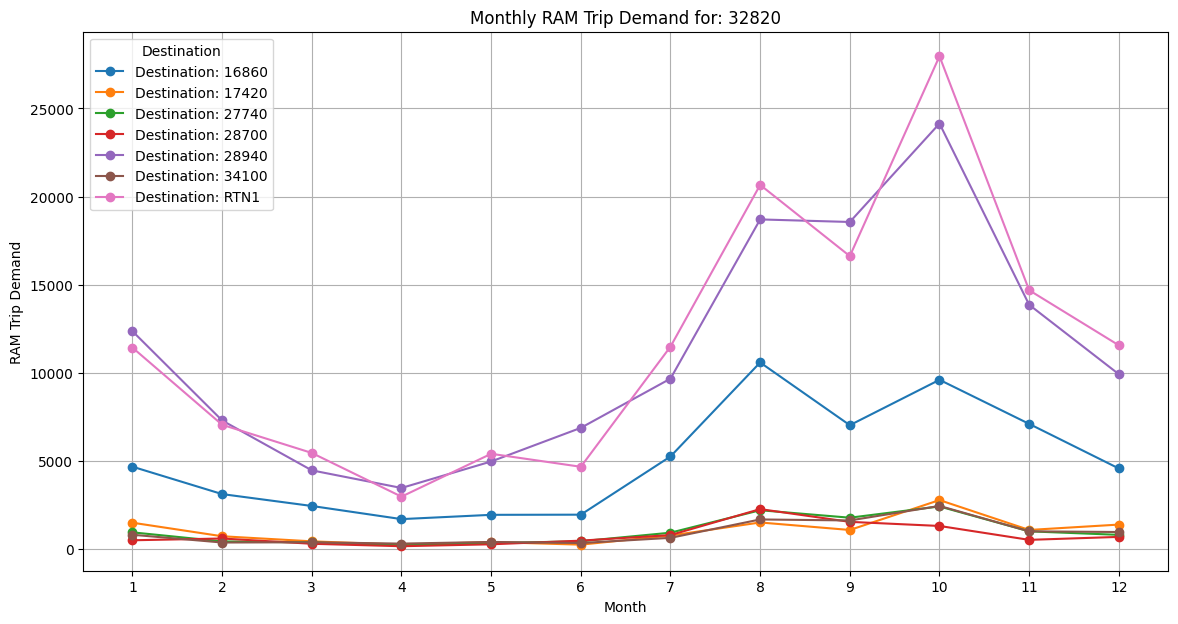

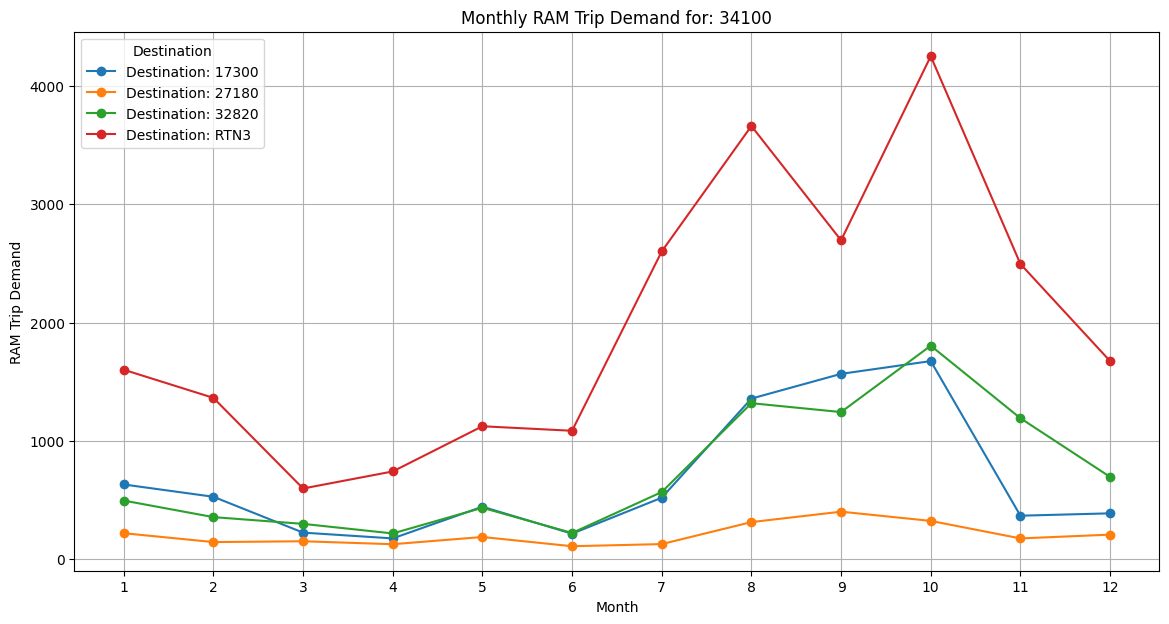

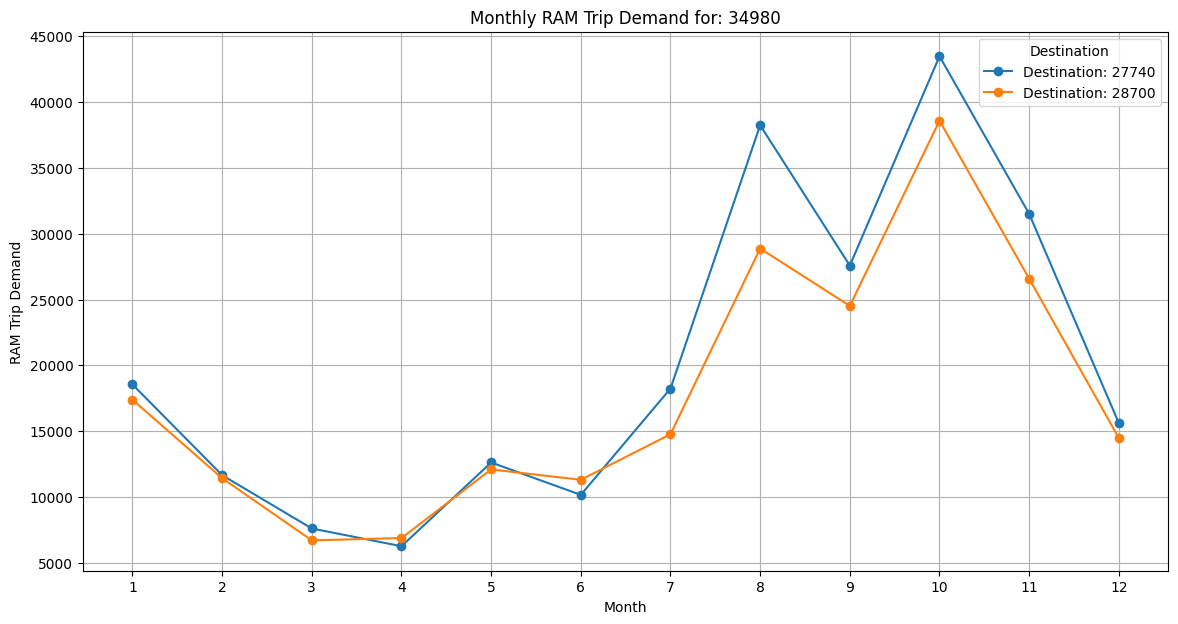

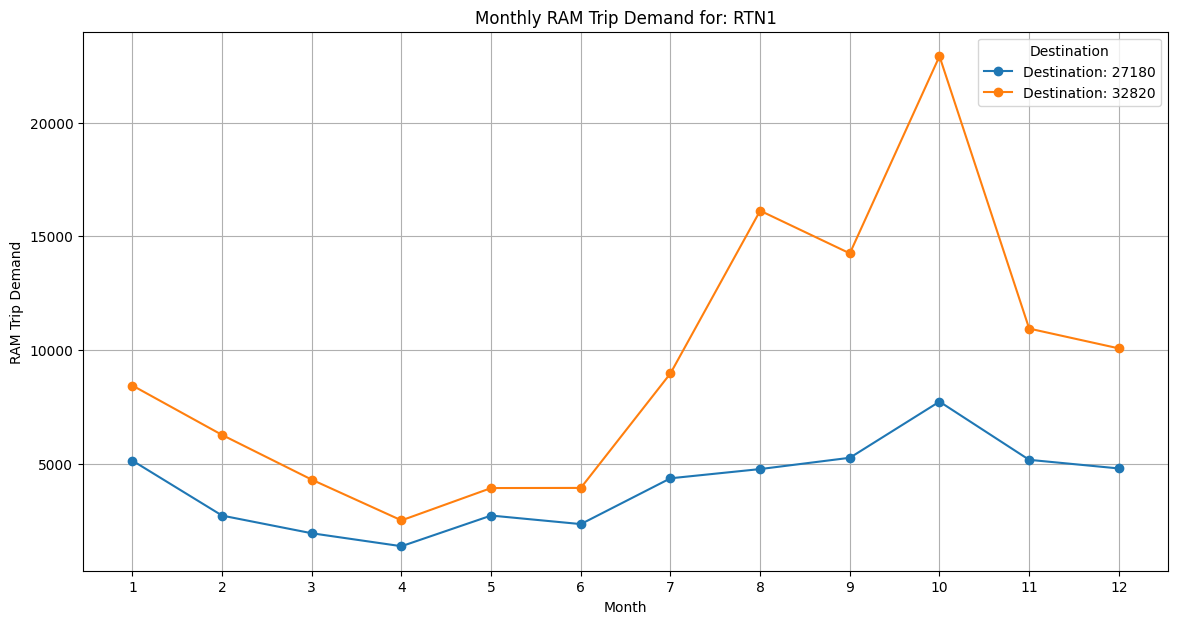

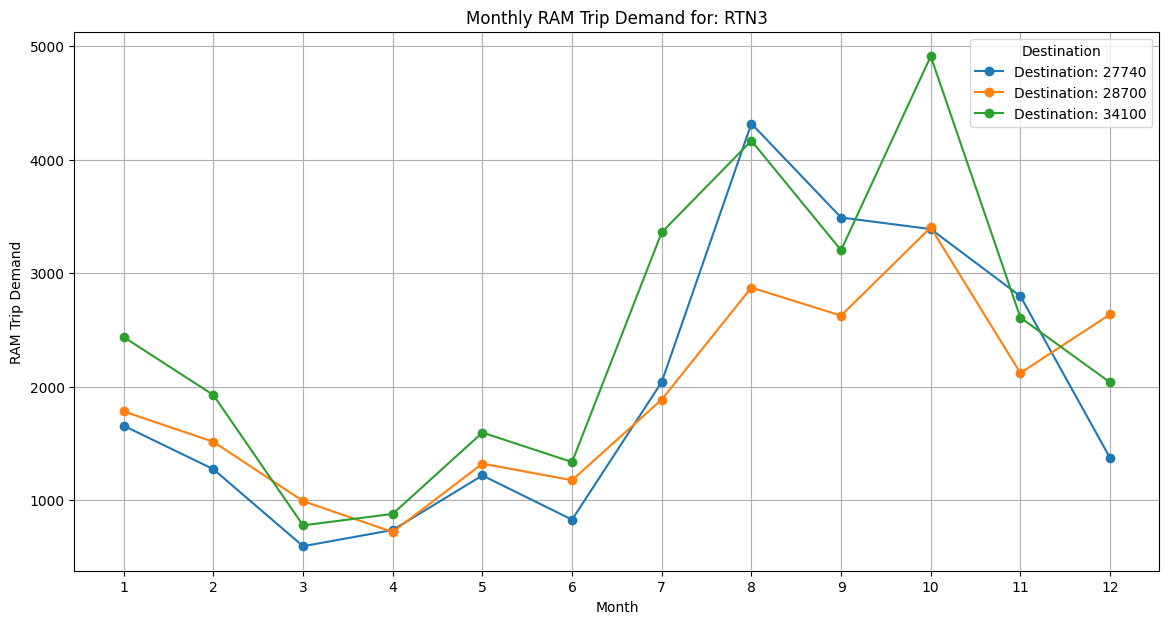

In [86]:
# Extract unique origins
unique_origins = df_filtered['Origin'].unique()

for origin in unique_origins:
    plt.figure(figsize=(14, 7))

    # Extract data for the current origin
    origin_data = df_filtered[df_filtered['Origin'] == origin]
    unique_destinations = origin_data['Destination'].unique()

    # Loop through each unique destination and plot the data
    for destination in unique_destinations:
        subset = origin_data[origin_data['Destination'] == destination]
        plt.plot(subset['Month'], subset['Mode RAM'], marker='o', label=f'Destination: {destination}')

    plt.title(f'Monthly RAM Trip Demand for: {origin}')
    plt.xlabel('Month')
    plt.ylabel('RAM Trip Demand')
    plt.legend(title='Destination')
    plt.grid(True)
    plt.xticks(ticks=df_filtered['Month'].unique())
    plt.show()

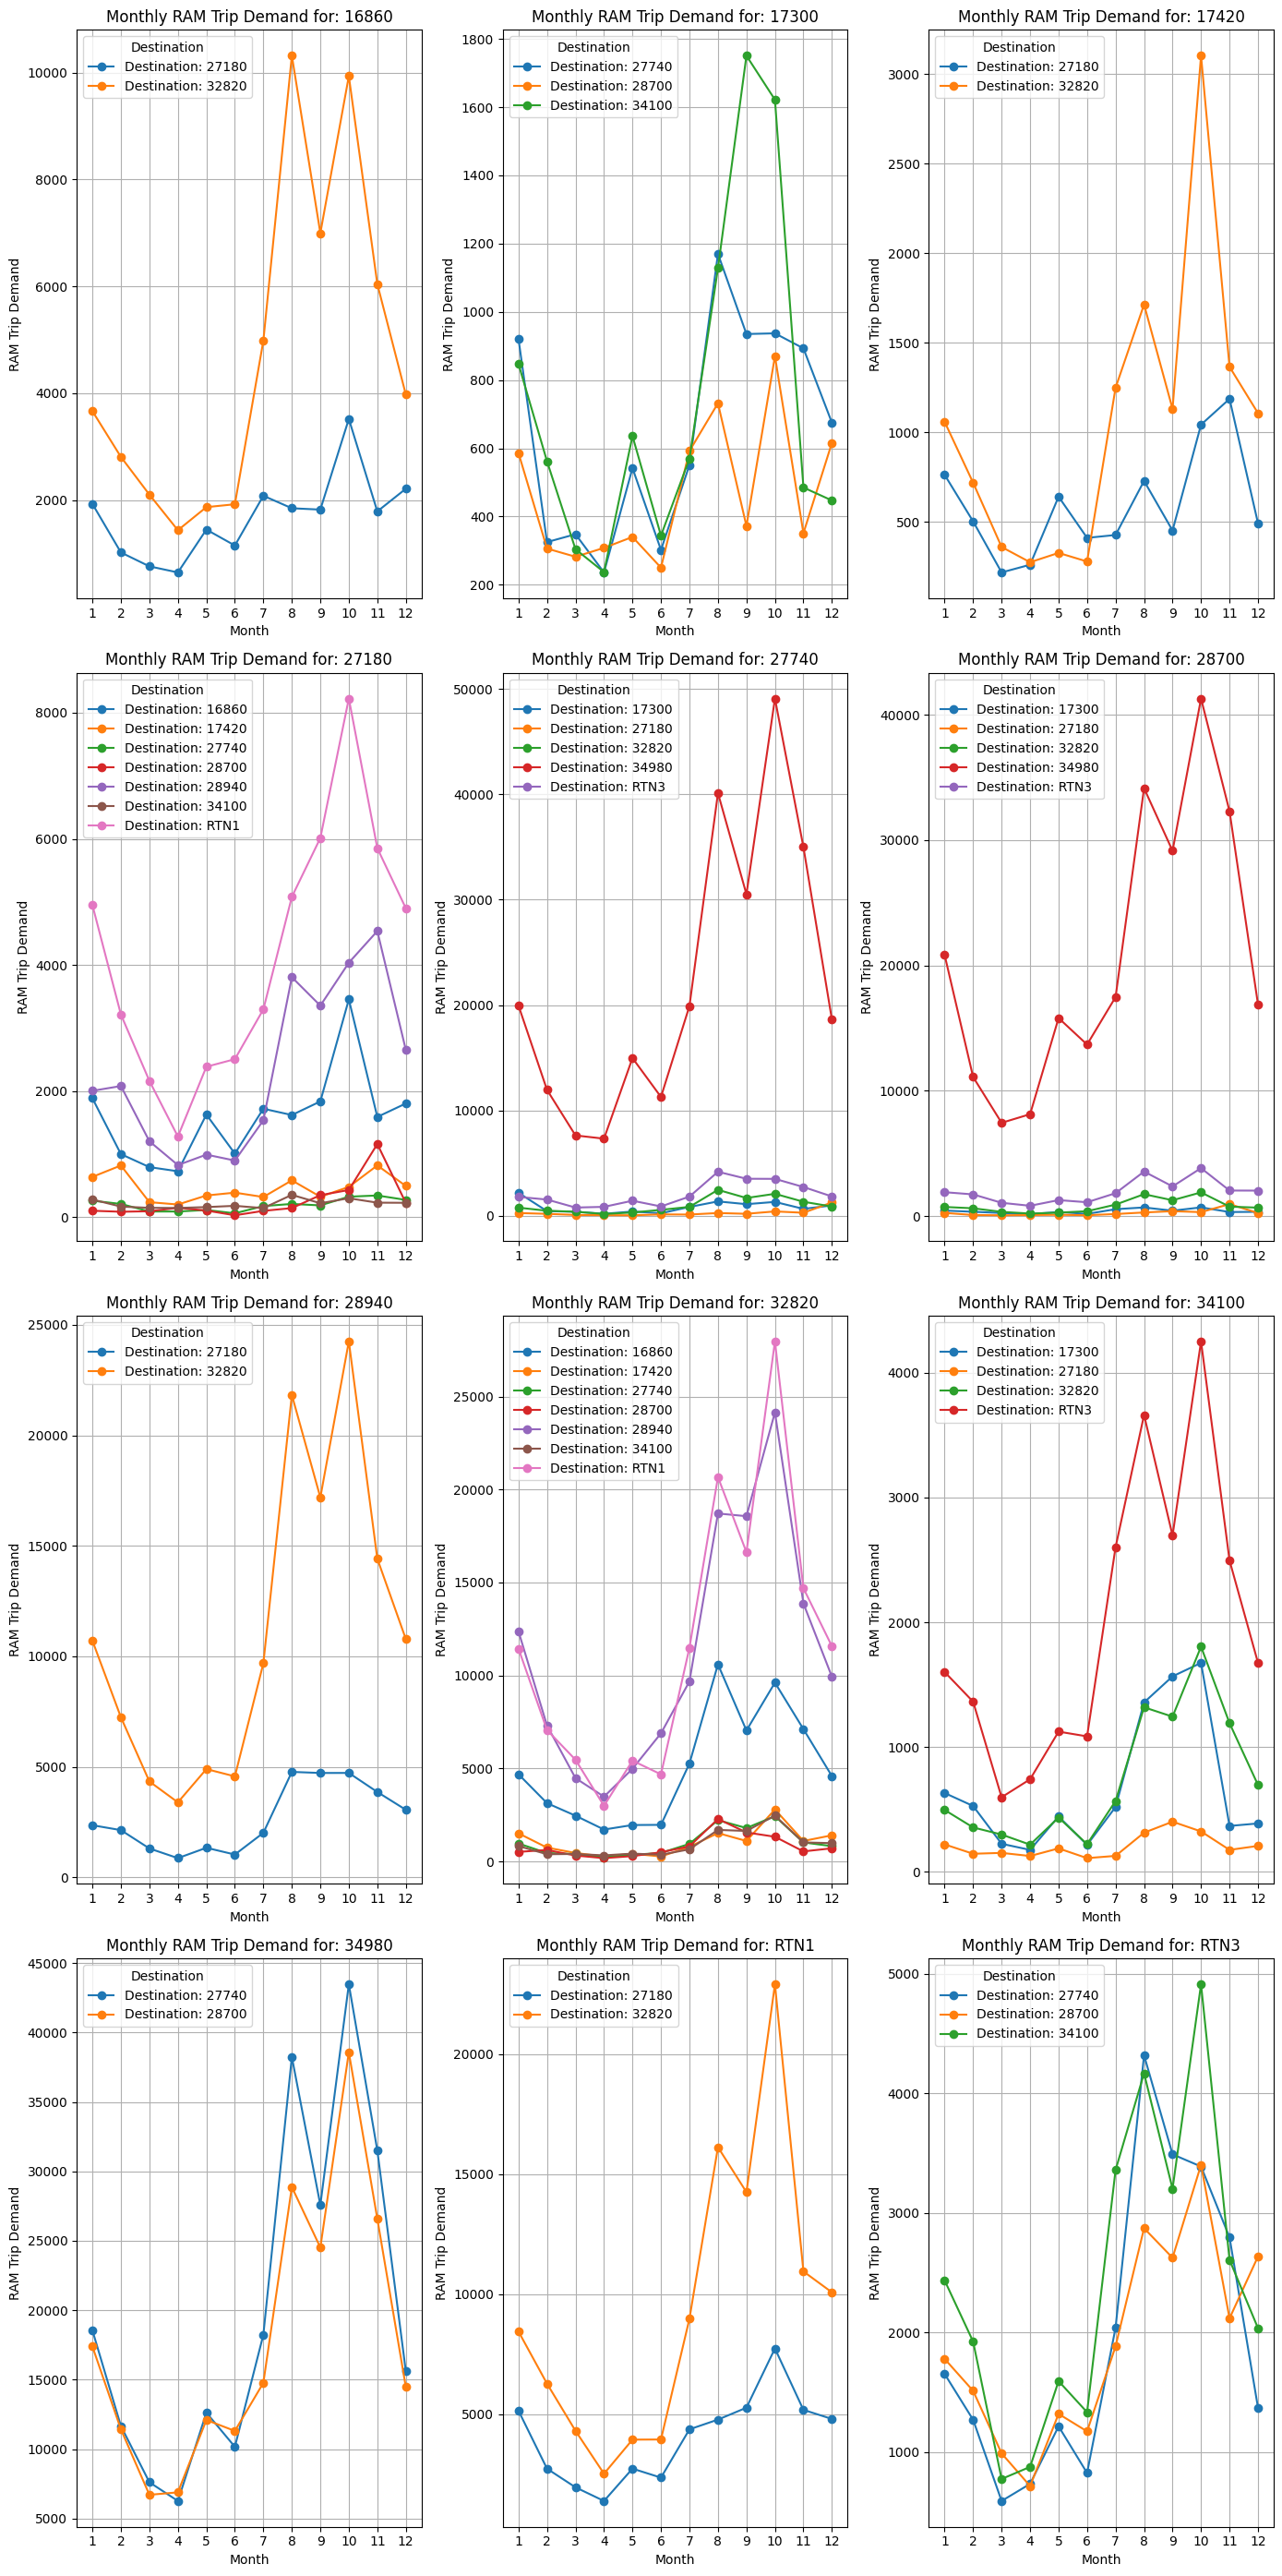

In [87]:
# Extract unique origins
unique_origins = df_filtered['Origin'].unique()
num_origins = len(unique_origins)

# Determine the layout for subplots
cols = 3  # Number of columns in the subplot grid
rows = (num_origins + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 7))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i, origin in enumerate(unique_origins):
    ax = axes[i]

    # Extract data for the current origin
    origin_data = df_filtered[df_filtered['Origin'] == origin]
    unique_destinations = origin_data['Destination'].unique()

    # Loop through each unique destination and plot the data
    for destination in unique_destinations:
        subset = origin_data[origin_data['Destination'] == destination]
        ax.plot(subset['Month'], subset['Mode RAM'], marker='o', label=f'Destination: {destination}')

    ax.set_title(f'Monthly RAM Trip Demand for: {origin}')
    ax.set_xlabel('Month')
    ax.set_ylabel('RAM Trip Demand')
    ax.legend(title='Destination')
    ax.grid(True)
    ax.set_xticks(df_filtered['Month'].unique())

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Second Method

In [88]:
# Using second method ie focussing on the trip of distance greater than 300 miles

monthly_df_second = monthly_df.groupby(['month', 'origin_zone_name']).agg({
    'mode_vehicle': 'sum',
    'vehicle_50_75mi': 'sum',
    'vehicle_75_100mi': 'sum',
    'vehicle_100_150mi': 'sum',
    'vehicle_150_300mi': 'sum',
    'vehicle_gt300mi': 'sum'
}).reset_index()

numeric_columns = ['mode_vehicle', 'vehicle_50_75mi', 'vehicle_75_100mi', 'vehicle_100_150mi', 'vehicle_150_300mi', 'vehicle_gt300mi']
monthly_df_second[numeric_columns] = monthly_df_second[numeric_columns].round(0).astype(int)

monthly_df_second

month origin_zone_name  mode_vehicle  vehicle_50_75mi  vehicle_75_100mi  \
0        1            16860        671264            99823             78260   
1        1            17300        434858           250780             96932   
2        1            17420        147747            28210             34056   
3        1            27180        382156           138605            124050   
4        1            27740        188964            28214             36792   
..     ...              ...           ...              ...               ...   
139     12            32820        518260           134561             94522   
140     12            34100        229097           128273             42270   
141     12            34980       3074848          1599468            532681   
142     12             RTN1       1802334           804700            404173   
143     12             RTN3       1746414           872865            415788   

     vehicle_100_150mi  vehicle_150_300mi  vehicle_gt300mi  
0               215385             272621             5173  
1                42904              40253             3991  
2                56308              27412             1757  
3                67391              46308             5803  
4                77537              26561            19860  
..                 ...                ...              ...  
139             122511             135219            31445  
140              20869              35282             2402  
141             384137             523901            34662  
142             384309             173541            35609  
143             311911             119385            26463  

[144 rows x 8 columns]

In [89]:
second_result = monthly_df_second[['month', 'origin_zone_name', 'mode_vehicle', 'vehicle_gt300mi']]

# Renaming columns
second_result.rename(columns={
    'month': 'Month',
    'origin_zone_name': 'Origin',
    'mode_vehicle': 'Mode Vehicle',
    'vehicle_gt300mi': 'Mode RAM'
}, inplace=True)


# Subtract 'Mode RAM' from 'Mode Vehicle' and store the result back in 'Mode Vehicle'
second_result['Mode Vehicle'] = second_result['Mode Vehicle'] - second_result['Mode RAM']


second_result

/tmp/ipykernel_6550/2203497899.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_result.rename(columns={
/tmp/ipykernel_6550/2203497899.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_result['Mode Vehicle'] = second_result['Mode Vehicle'] - second_result['Mode RAM']


Month Origin  Mode Vehicle  Mode RAM
0        1  16860        666091      5173
1        1  17300        430867      3991
2        1  17420        145990      1757
3        1  27180        376353      5803
4        1  27740        169104     19860
..     ...    ...           ...       ...
139     12  32820        486815     31445
140     12  34100        226695      2402
141     12  34980       3040186     34662
142     12   RTN1       1766725     35609
143     12   RTN3       1719951     26463

[144 rows x 4 columns]

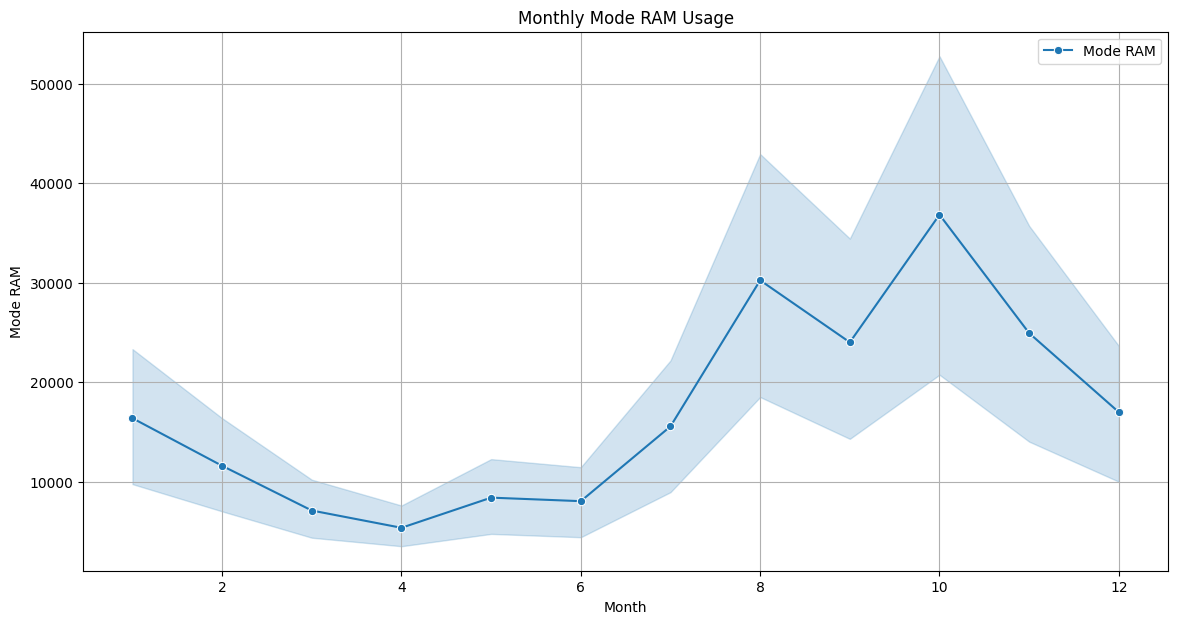

In [90]:
# Line plot of Mode RAM over Months
plt.figure(figsize=(14, 7))
sns.lineplot(data=second_result, x='Month', y='Mode RAM', label='Mode RAM', marker='o')
plt.title('Monthly Mode RAM Usage')
plt.xlabel('Month')
plt.ylabel('Mode RAM')
plt.legend()
plt.grid(True)
plt.show()


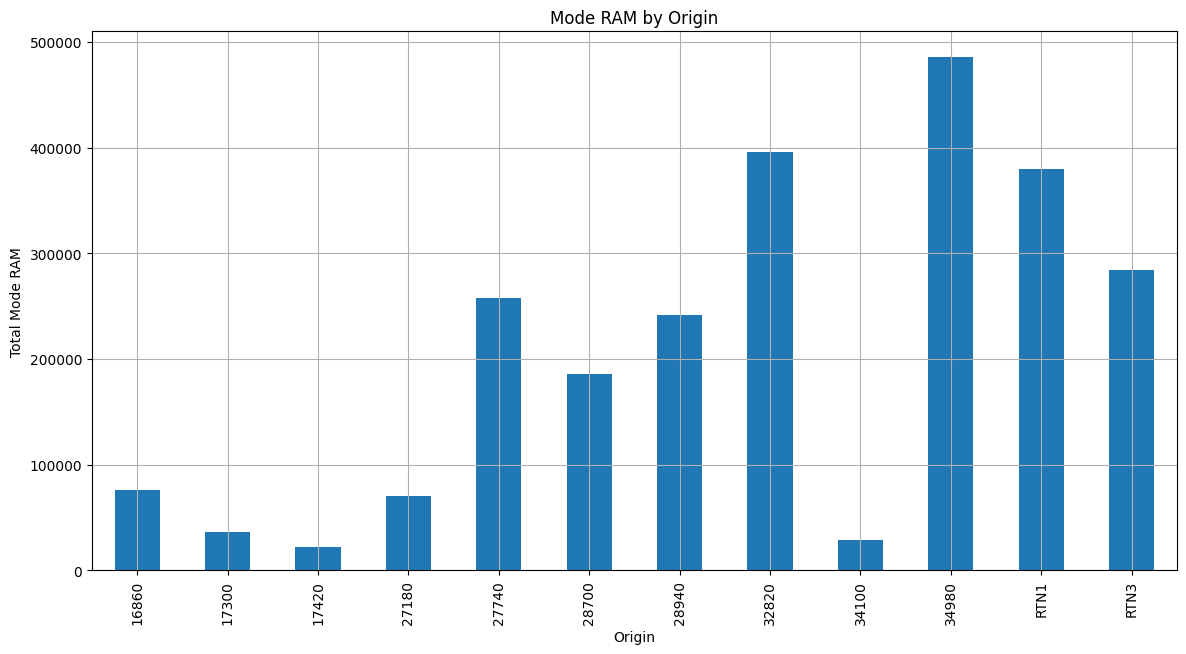

In [91]:
# Bar plot of Mode RAM for different Origins
plt.figure(figsize=(14, 7))
second_result.groupby('Origin')['Mode RAM'].sum().plot(kind='bar')
plt.title('Mode RAM by Origin')
plt.xlabel('Origin')
plt.ylabel('Total Mode RAM')
plt.grid(True)
plt.show()

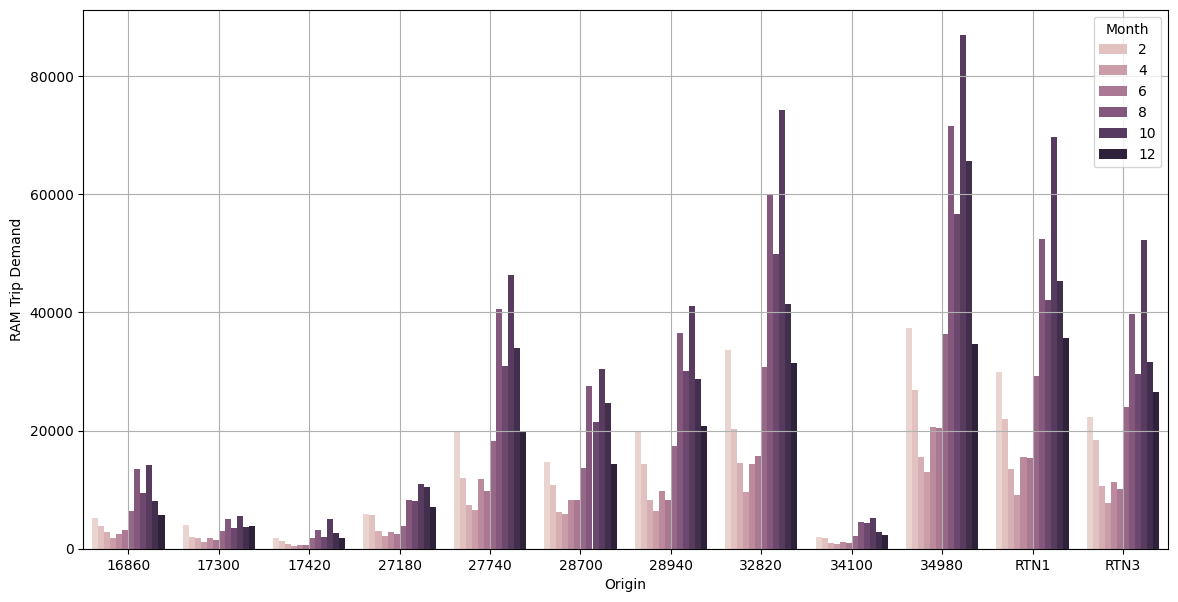

In [92]:
# Aggregate the data
pivot_df_aggregated = second_result.groupby(['Origin', 'Month'])['Mode RAM'].sum().reset_index()

# Pivot the data to have Months as columns
pivot_table = pivot_df_aggregated.pivot(index='Origin', columns='Month', values='Mode RAM').fillna(0)

# Reset the index and melt the DataFrame for easier plotting
pivot_table_reset = pivot_table.reset_index()
melted_df = pivot_table_reset.melt(id_vars='Origin', var_name='Month', value_name='Mode RAM')


plt.figure(figsize=(14, 7))
sns.barplot(data=melted_df, x='Origin', y='Mode RAM', hue='Month')
# plt.title('Mode RAM by Origin for Each Month')
plt.xlabel('Origin')
plt.ylabel('RAM Trip Demand')
plt.legend(title='Month')
plt.grid(True)
plt.show()

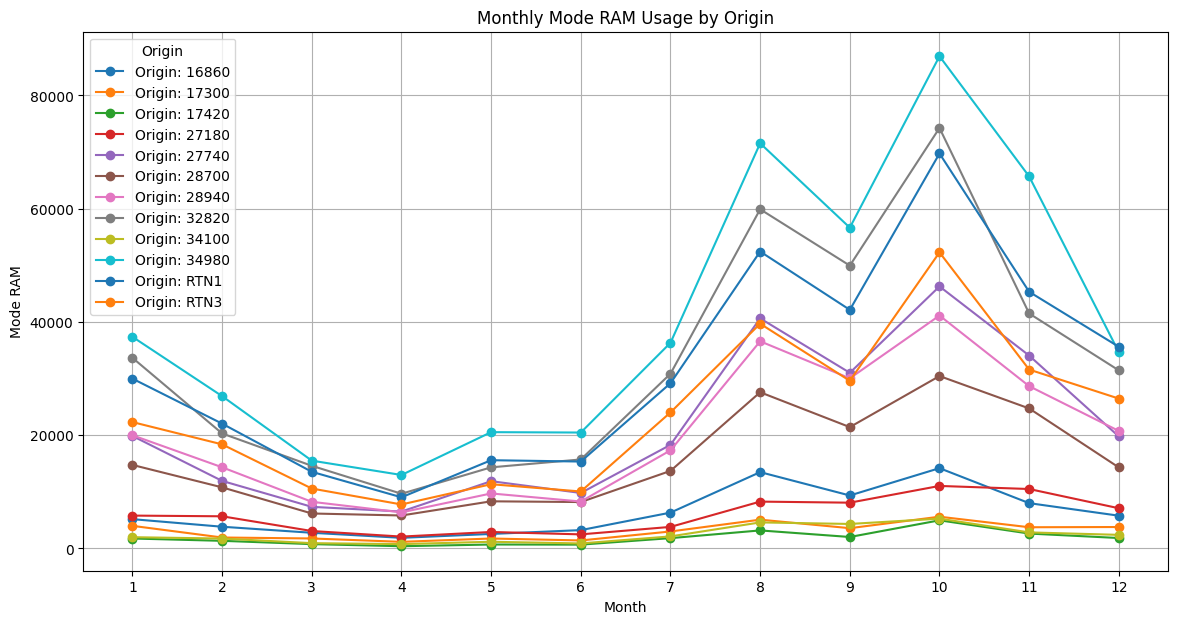

In [93]:
# Extract unique origins
unique_origins = second_result['Origin'].unique()

plt.figure(figsize=(14, 7))

# Loop through each unique origin and plot the data
for origin in unique_origins:
    subset = second_result[second_result['Origin'] == origin]
    plt.plot(subset['Month'], subset['Mode RAM'], marker='o', label=f'Origin: {origin}')

plt.title('Monthly Mode RAM Usage by Origin')
plt.xlabel('Month')
plt.ylabel('Mode RAM')
plt.legend(title='Origin')
plt.grid(True)
plt.xticks(ticks=second_result['Month'].unique())
plt.show()

## Finding monthly demand for all the unique OD pairs

In [94]:
monthly_df

month origin_zone_name destination_zone_name  mode_vehicle  \
0         1            16860                 16860         15994   
1         1            16860                 17300          3558   
2         1            16860                 17420         11902   
3         1            16860                 27180          1930   
4         1            16860                 27740          4446   
...     ...              ...                   ...           ...   
1723     12             RTN3                 32820        205996   
1724     12             RTN3                 34100          2036   
1725     12             RTN3                 34980        648686   
1726     12             RTN3                  RTN1         75164   
1727     12             RTN3                  RTN3        486486   

      vehicle_50_75mi  vehicle_75_100mi  vehicle_100_150mi  vehicle_150_300mi  \
0               14070              1910                  0                  0   
1                   0                 0                  0               3558   
2                9302              2510                 86                  0   
3                   0                 0                  0               1799   
4                   0                 0                  0               4446   
...               ...               ...                ...                ...   
1723            62056             40261              83450              19500   
1724                0                 0                  0               1206   
1725           268532            201221             134919              44014   
1726            23416              9836              12863              17054   
1727           317858            106538              50627              11458   

      vehicle_gt300mi  
0                  13  
1                   0  
2                   4  
3                 130  
4                   0  
...               ...  
1723              730  
1724              830  
1725                1  
1726            11994  
1727                4  

[1728 rows x 9 columns]

In [95]:
result = monthly_df[['month', 'origin_zone_name', 'destination_zone_name','mode_vehicle', 'vehicle_gt300mi']]

# Renaming columns
result.rename(columns={
    'month': 'Month',
    'origin_zone_name': 'Origin',
    'destination_zone_name': 'Destination',
    'mode_vehicle': 'Mode Vehicle',
    'vehicle_gt300mi': 'Mode RAM'
}, inplace=True)


# Subtract 'Mode RAM' from 'Mode Vehicle' and store the result back in 'Mode Vehicle'
result['Mode Vehicle'] = result['Mode Vehicle'] - result['Mode RAM']
result

/tmp/ipykernel_6550/3134240533.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.rename(columns={
/tmp/ipykernel_6550/3134240533.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['Mode Vehicle'] = result['Mode Vehicle'] - result['Mode RAM']


Month Origin Destination  Mode Vehicle  Mode RAM
0         1  16860       16860         15981        13
1         1  16860       17300          3558         0
2         1  16860       17420         11898         4
3         1  16860       27180          1800       130
4         1  16860       27740          4446         0
...     ...    ...         ...           ...       ...
1723     12   RTN3       32820        205266       730
1724     12   RTN3       34100          1206       830
1725     12   RTN3       34980        648685         1
1726     12   RTN3        RTN1         63170     11994
1727     12   RTN3        RTN3        486482         4

[1728 rows x 5 columns]

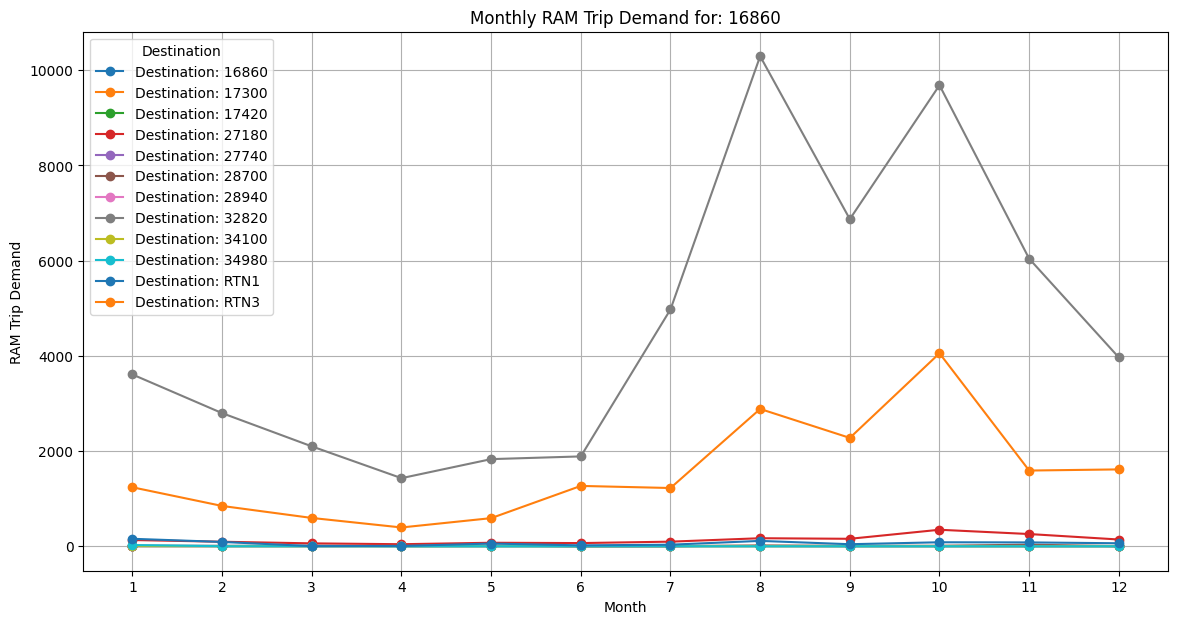

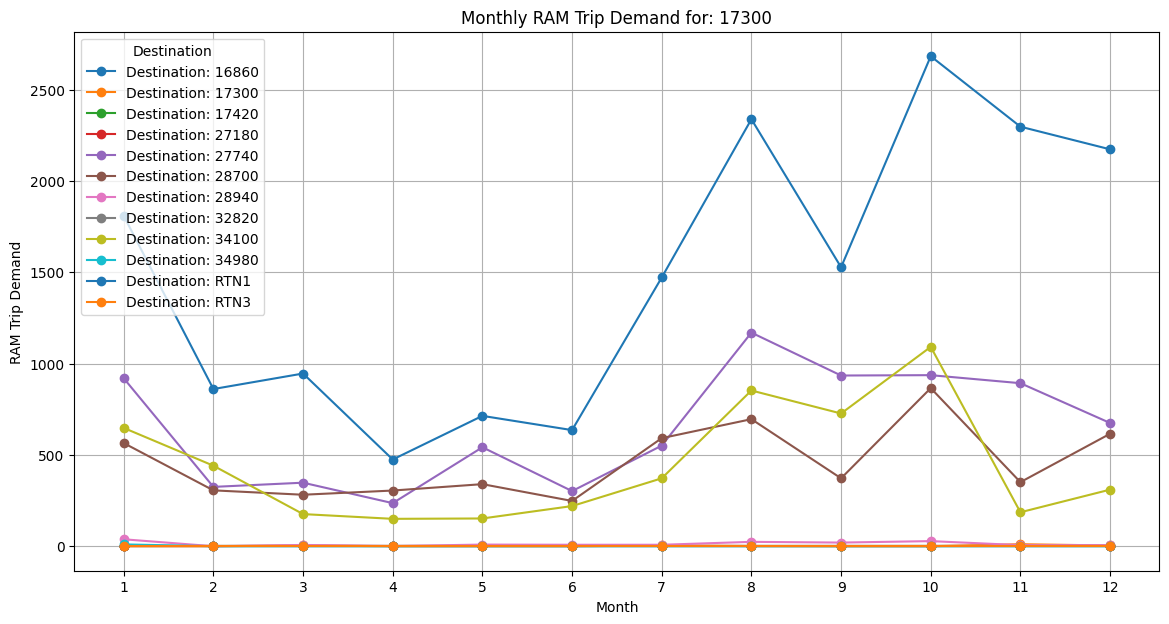

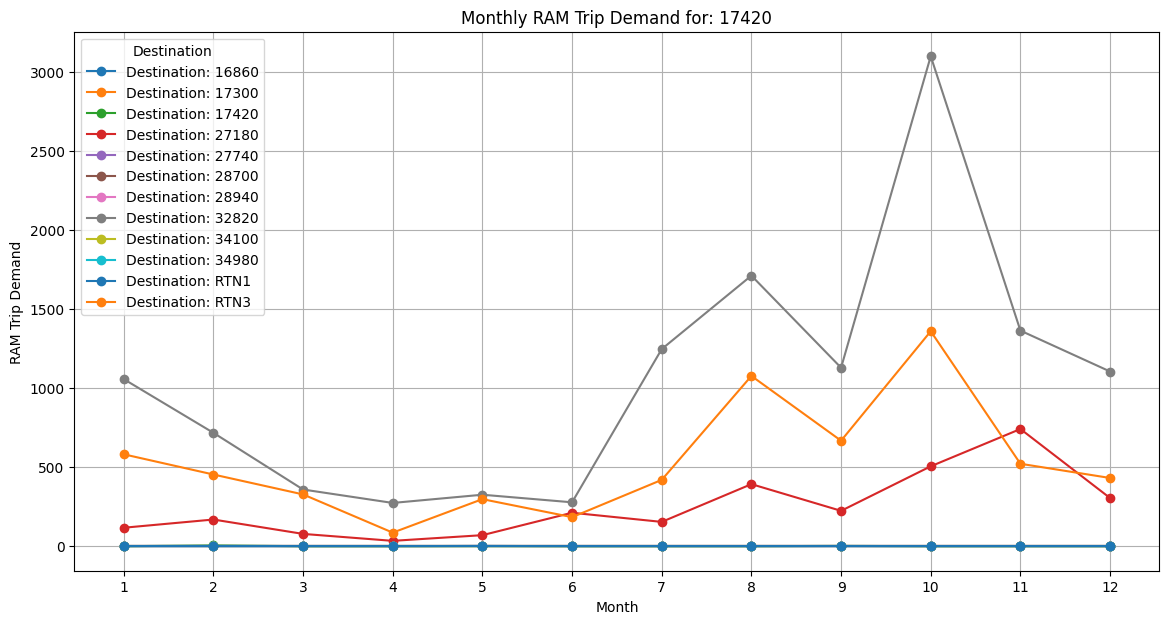

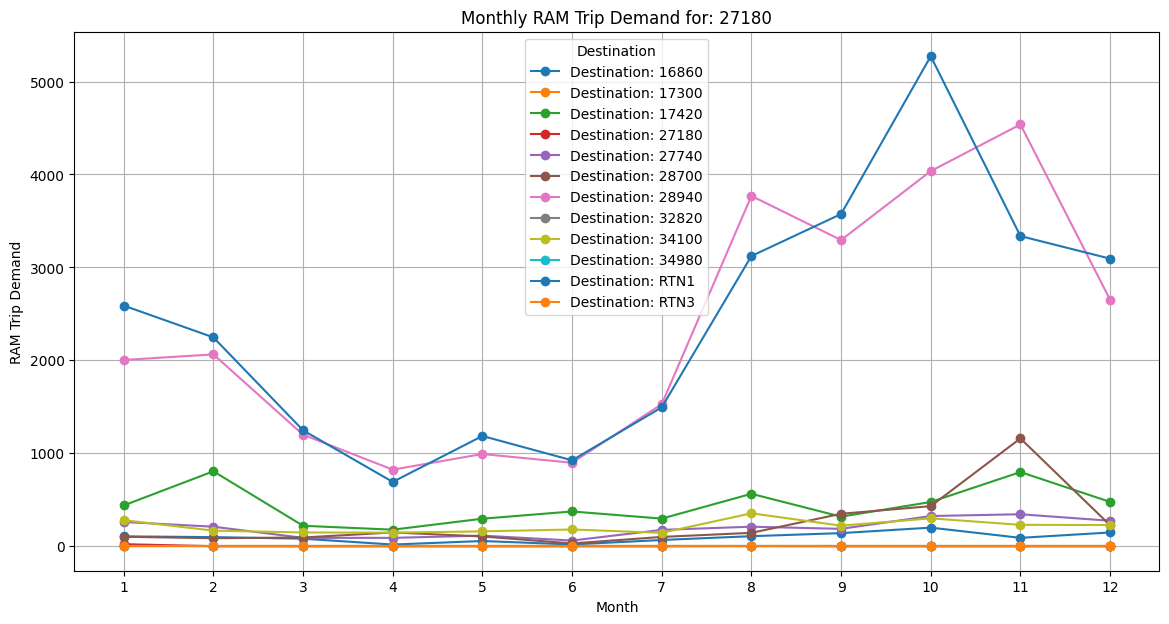

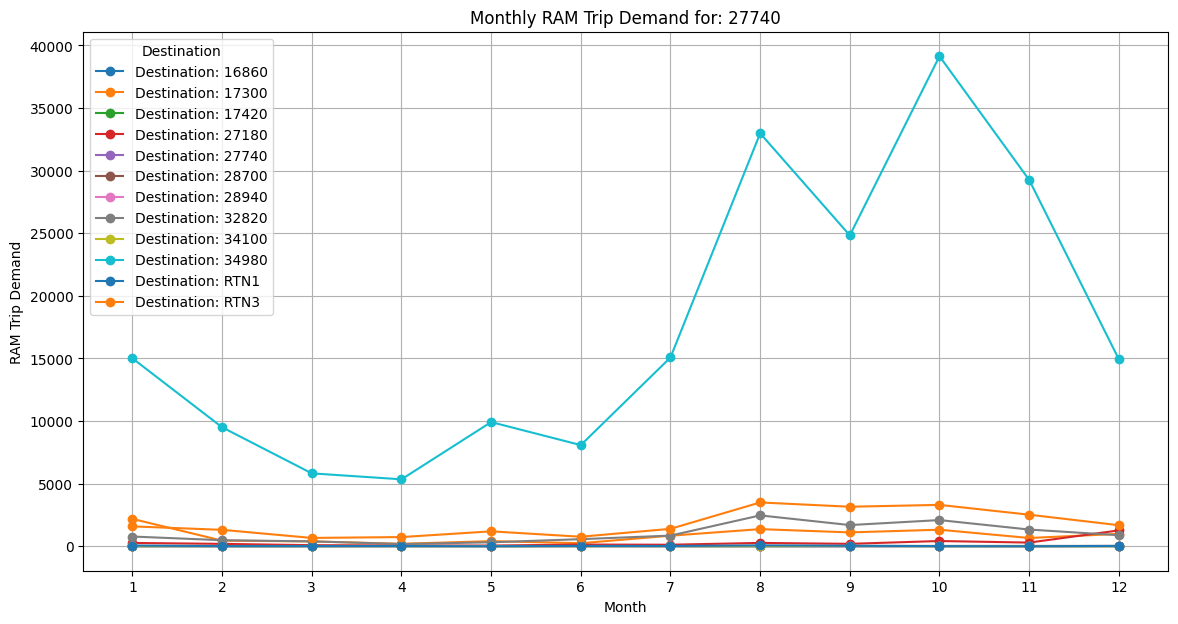

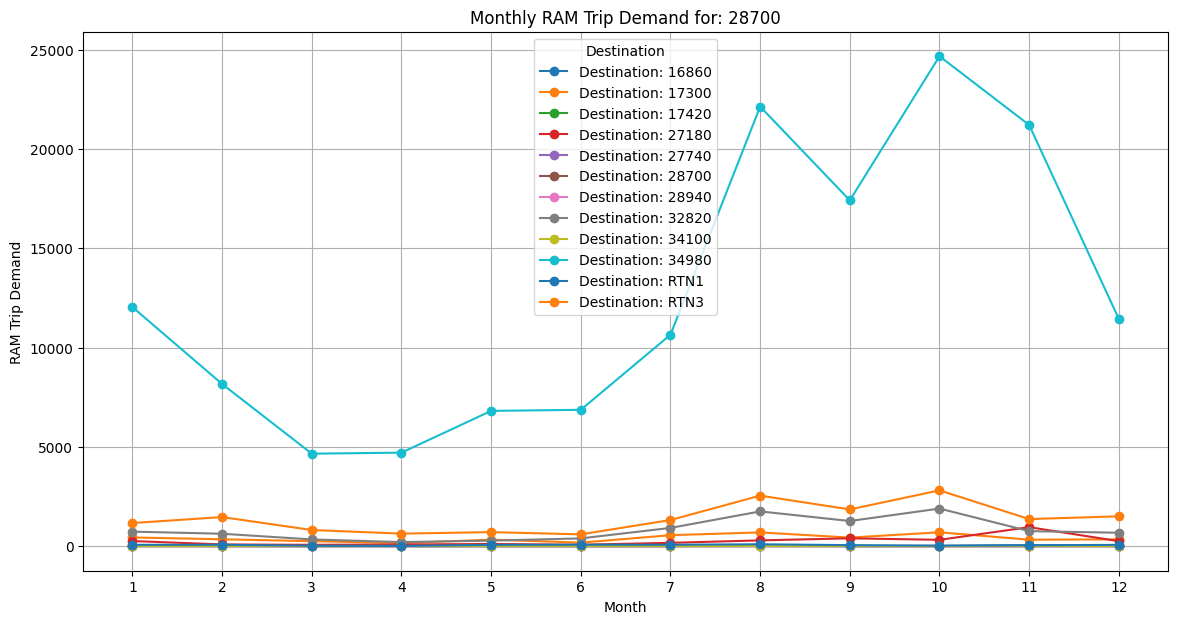

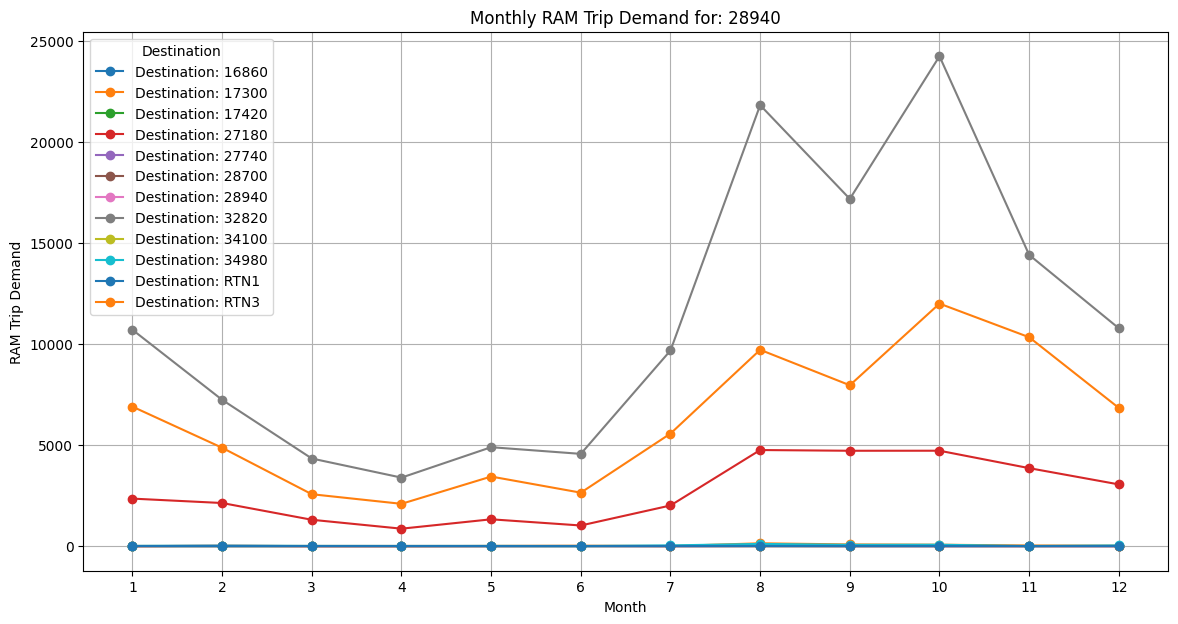

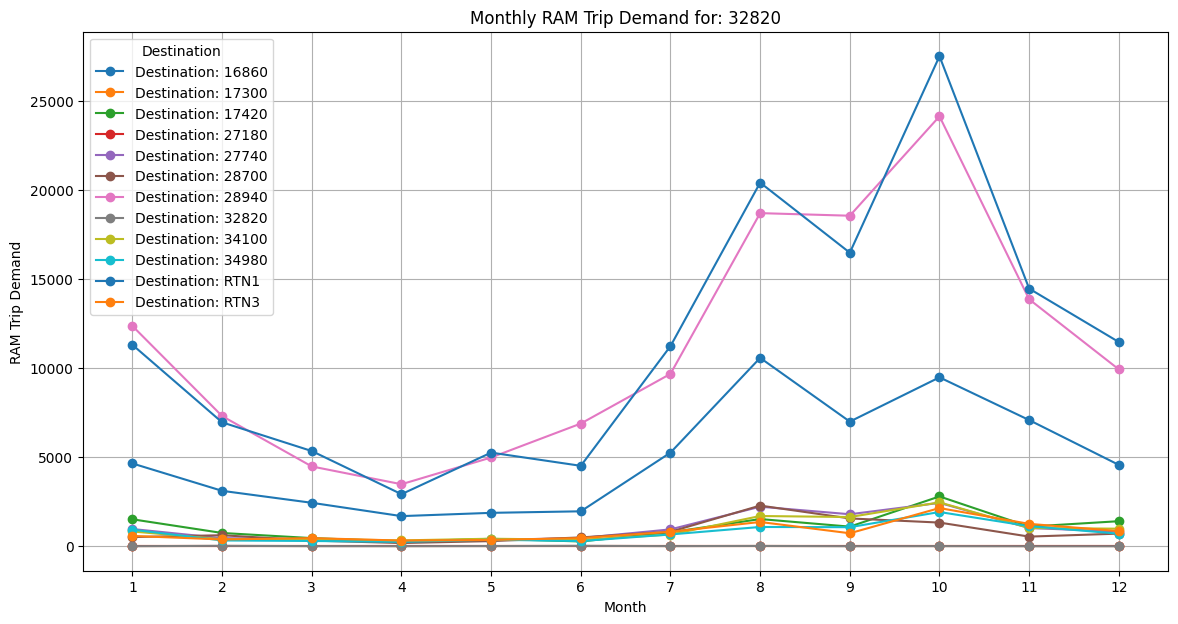

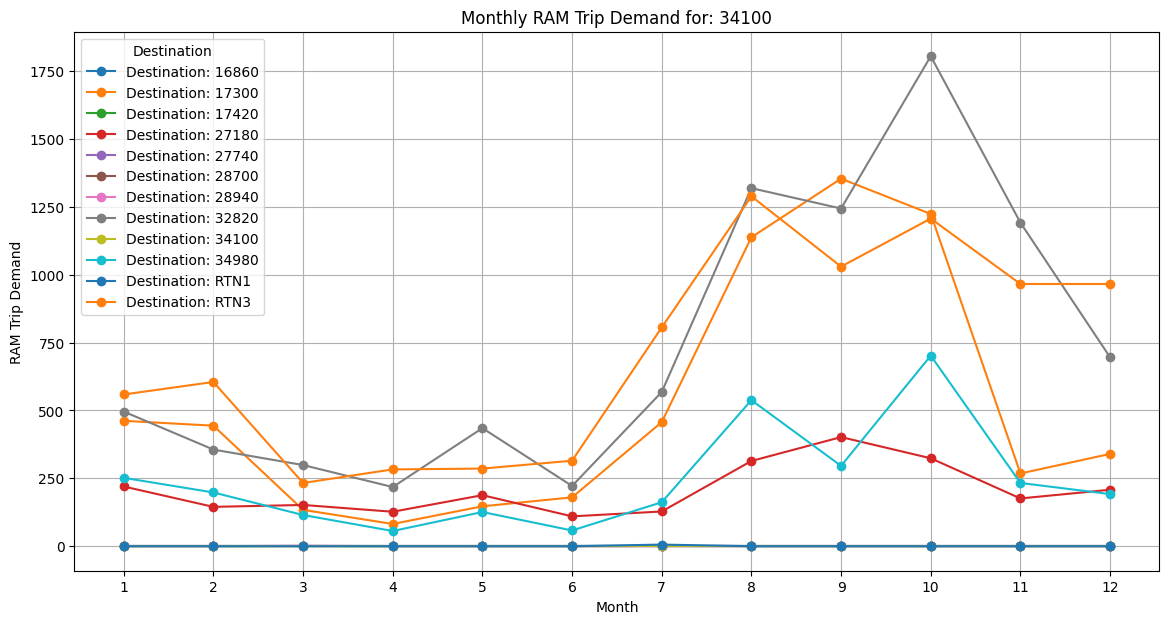

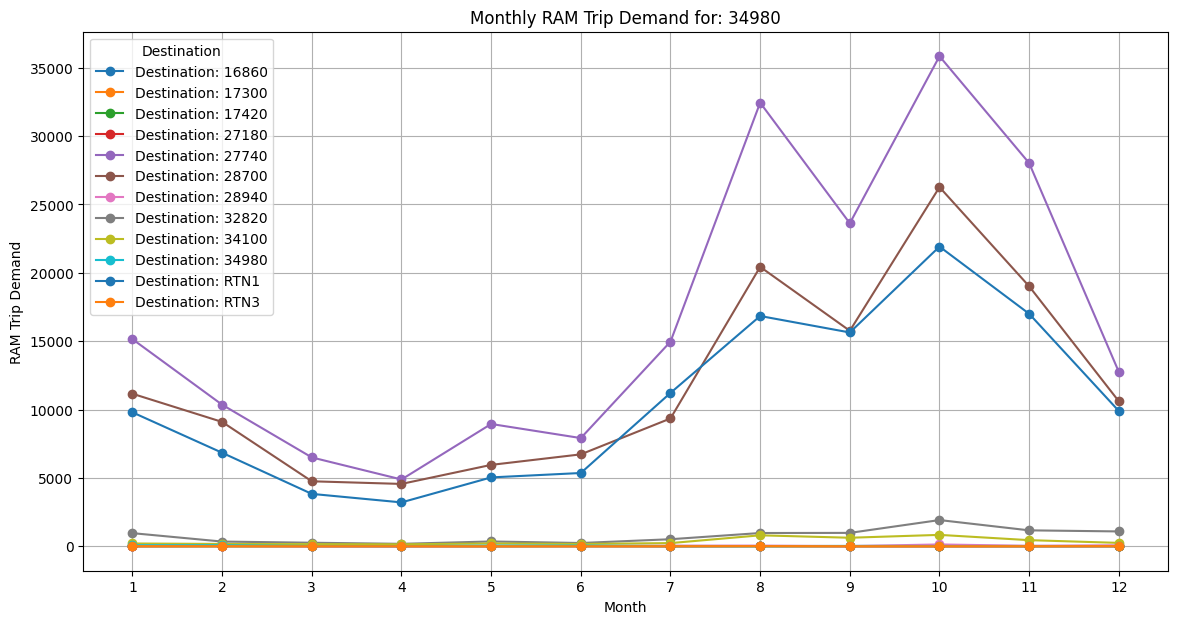

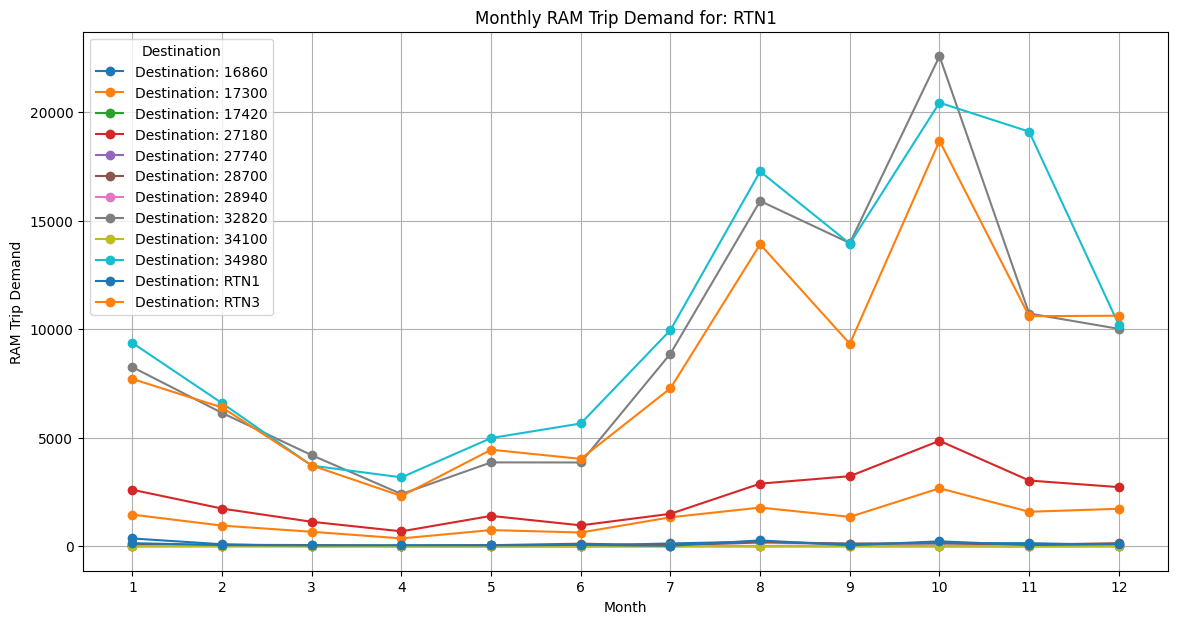

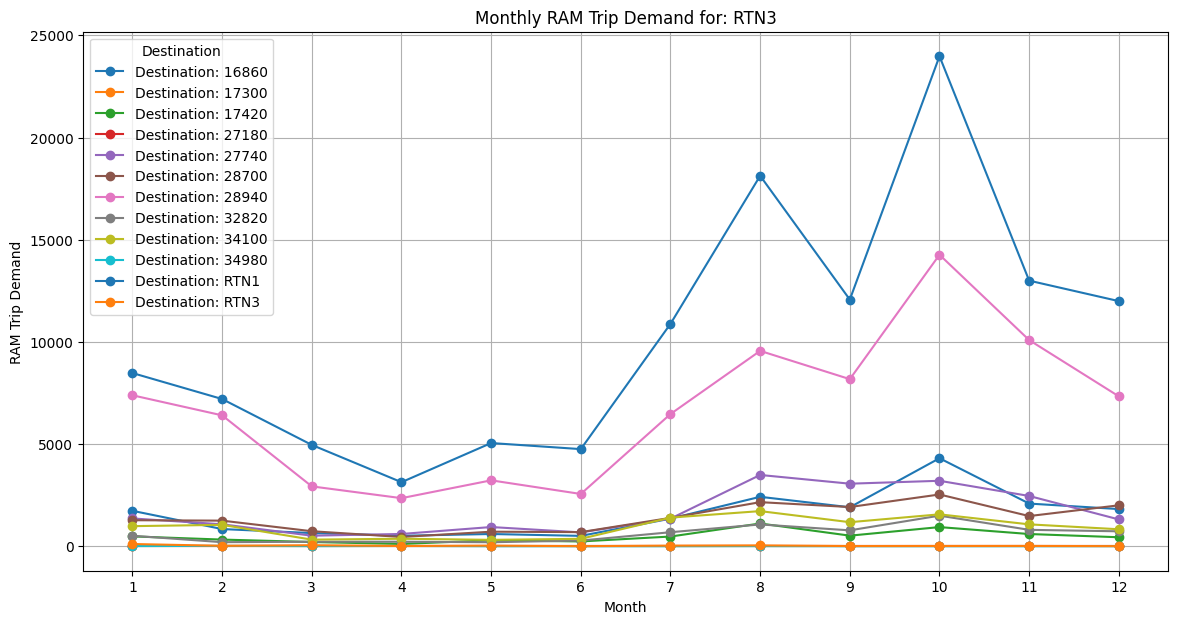

In [96]:
# Extract unique origins
unique_origins = result['Origin'].unique()

for origin in unique_origins:
    plt.figure(figsize=(14, 7))

    # Extract data for the current origin
    origin_data = result[result['Origin'] == origin]
    unique_destinations = origin_data['Destination'].unique()

    # Loop through each unique destination and plot the data
    for destination in unique_destinations:
        subset = origin_data[origin_data['Destination'] == destination]
        plt.plot(subset['Month'], subset['Mode RAM'], marker='o', label=f'Destination: {destination}')

    plt.title(f'Monthly RAM Trip Demand for: {origin}')
    plt.xlabel('Month')
    plt.ylabel('RAM Trip Demand')
    plt.legend(title='Destination')
    plt.grid(True)
    plt.xticks(ticks=result['Month'].unique())
    plt.show()

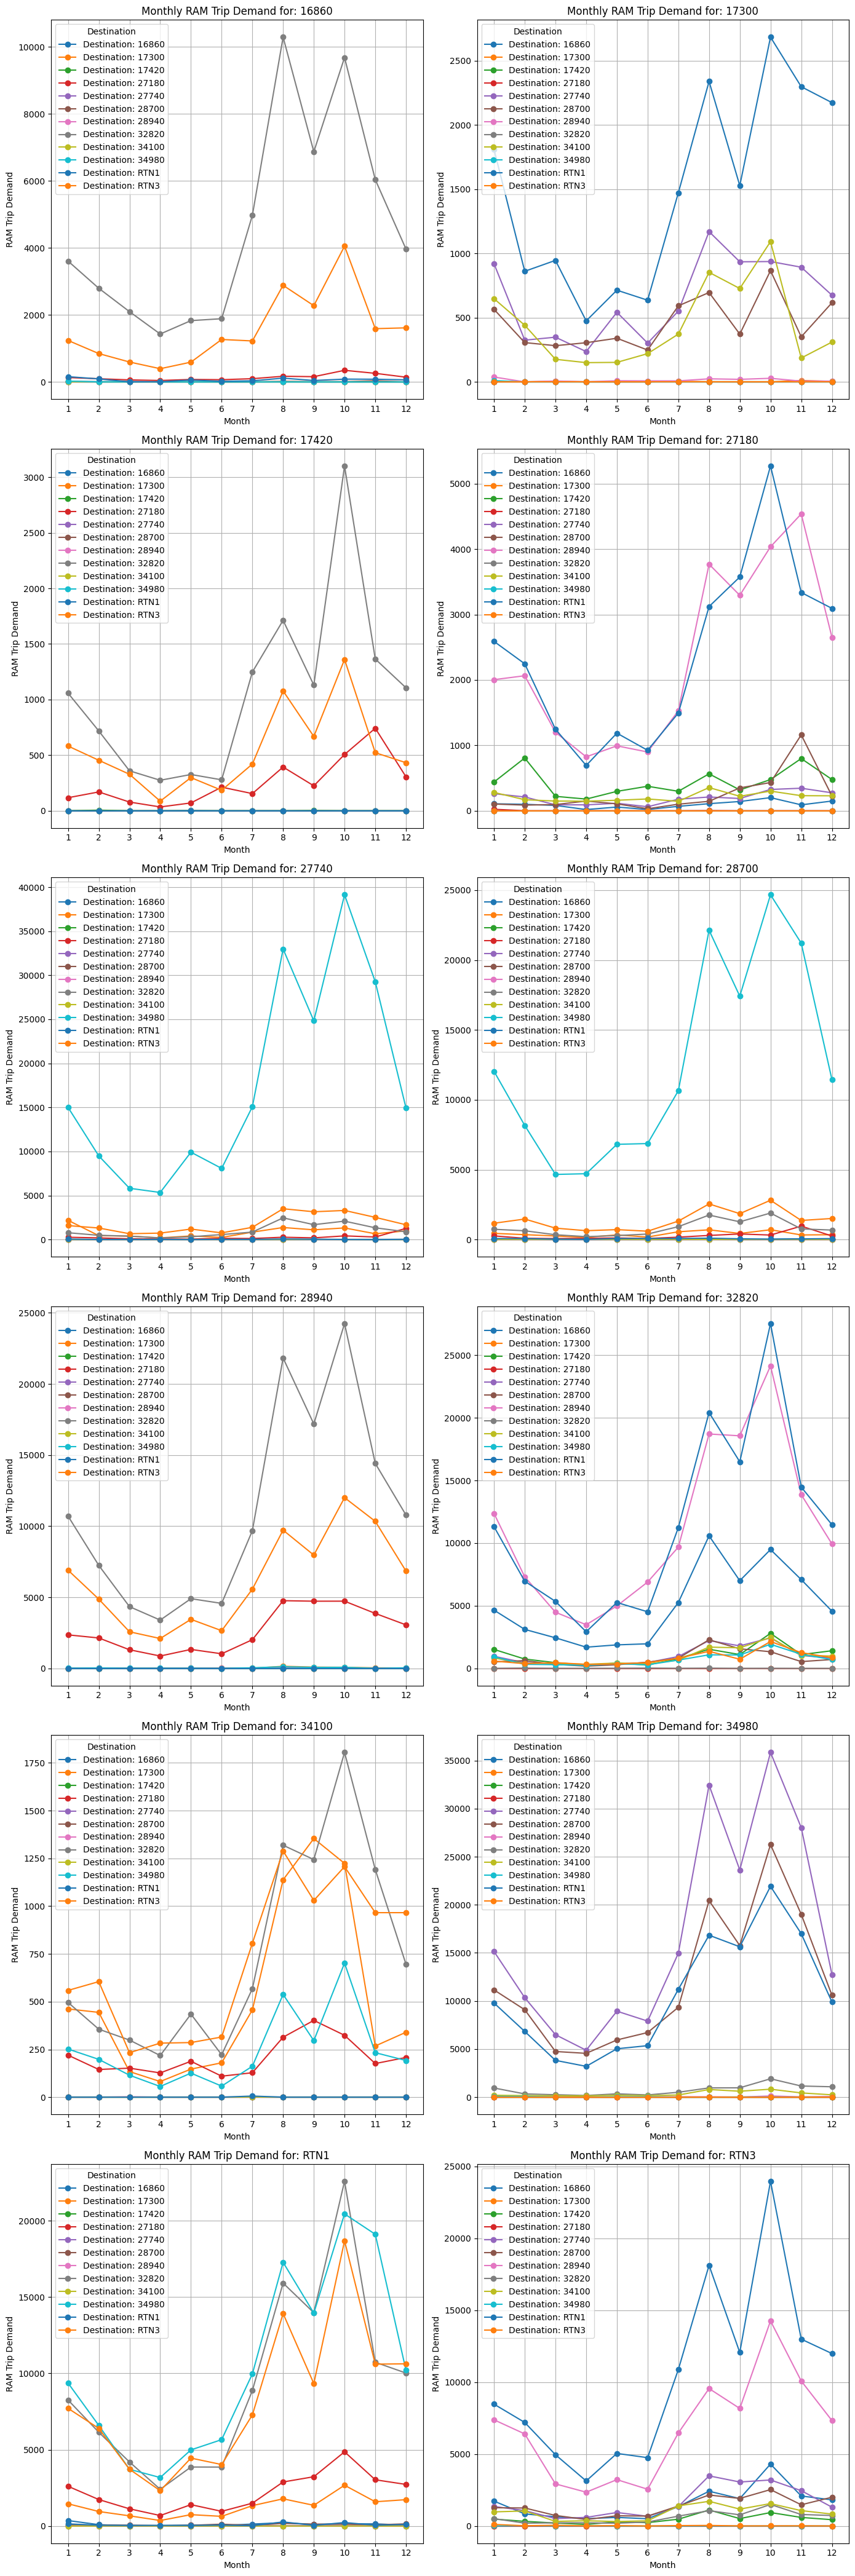

In [97]:
# Extract unique origins
unique_origins = result['Origin'].unique()
num_origins = len(unique_origins)

# Determine the layout for subplots
cols = 2  # Number of columns in the subplot grid
rows = (num_origins + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 7))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i, origin in enumerate(unique_origins):
    ax = axes[i]

    # Extract data for the current origin
    origin_data = result[result['Origin'] == origin]
    unique_destinations = origin_data['Destination'].unique()

    # Loop through each unique destination and plot the data
    for destination in unique_destinations:
        subset = origin_data[origin_data['Destination'] == destination]
        ax.plot(subset['Month'], subset['Mode RAM'], marker='o', label=f'Destination: {destination}')

    ax.set_title(f'Monthly RAM Trip Demand for: {origin}')
    ax.set_xlabel('Month')
    ax.set_ylabel('RAM Trip Demand')
    ax.legend(title='Destination')
    ax.grid(True)
    ax.set_xticks(result['Month'].unique())

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

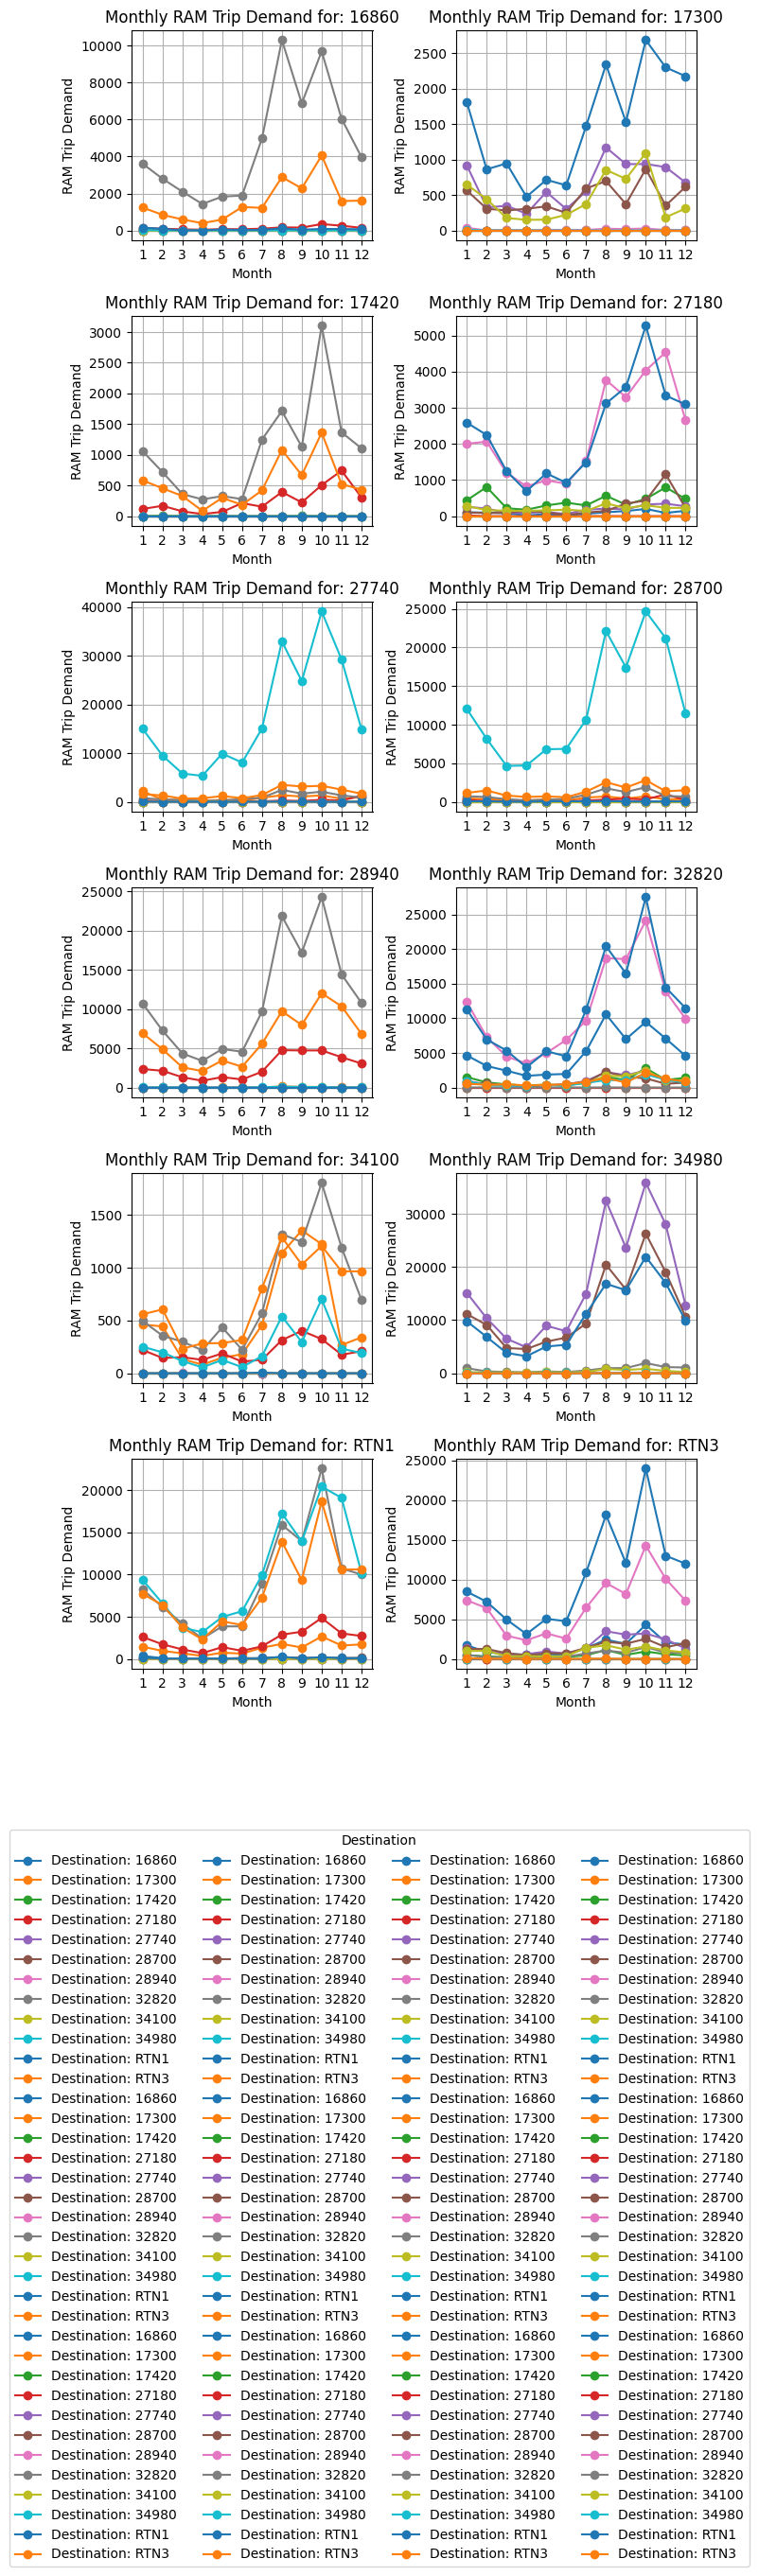

In [98]:
# Assuming the dataframe is named 'result' and loaded already
# Extract unique origins
unique_origins = result['Origin'].unique()
num_origins = len(unique_origins)

# Determine the layout for subplots
cols = 2  # Number of columns in the subplot grid
rows = (num_origins + cols - 1) // cols  # Calculate rows needed

# Define the figsize to fit research paper dimensions
figsize = (7, rows * 3.5)  # Width for double-column, height adjusted proportionally

fig, axes = plt.subplots(rows, cols, figsize=figsize)

# Flatten axes array for easy indexing
axes = axes.flatten()

handles_list = []
labels_list = []

for i, origin in enumerate(unique_origins):
    ax = axes[i]

    # Extract data for the current origin
    origin_data = result[result['Origin'] == origin]
    unique_destinations = origin_data['Destination'].unique()

    # Loop through each unique destination and plot the data
    for destination in unique_destinations:
        subset = origin_data[origin_data['Destination'] == destination]
        handle, = ax.plot(subset['Month'], subset['Mode RAM'], marker='o', label=f'{destination}')

        handles_list.append(handle)
        labels_list.append(f'Destination: {destination}')

    ax.set_title(f'Monthly RAM Trip Demand for: {origin}')
    ax.set_xlabel('Month')
    ax.set_ylabel('RAM Trip Demand')
    ax.grid(True)
    ax.set_xticks(result['Month'].unique())

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one legend for all subplots
fig.legend(handles=handles_list, labels=labels_list, loc='upper center', ncol=4, title='Destination', bbox_to_anchor=(0.5, 0.05))

plt.tight_layout(rect=[0, 0.1, 1, 0.97])  # Adjust layout to fit legend
plt.savefig('monthly_ram_trip_demand.png', dpi=300)
plt.show()